# 6DOF Equations of Motion

Acronym | Meaning
:-------|:-------
CG      | Center of Gravity
DAVE-ML | Dynamic Aerospace Vehicle Exchange Markup Language
EOM     | Equations of Motion
FRD     | Forward Right Down
IC      | Initial Condition
LLA     | Latitude, Longitude and Altitude
MathML  | Mathematical Markup Language
NED     | North, East, Down
PCPF    | Planet Centered, Planet Fixed (aka, ECEF on Earth)
SI      | International System of Units

The goal of the software is to implement a generic set of the EOM that could be used for dynamic simulations on any planet with any/no atmosphere.

The software implements flat earth and the oblate rotating planet EOM as derived in [Stevens and Lewis](https://bcs.wiley.com/he-bcs/Books?action=index&itemId=0471371459&itemTypeId=BKS&bcsId=2073). Stevens and Lewis derives the equations of motion; therefore they are not described here.

All internal calculations are in SI.

To upgrade jupyter: **pip3 install --upgrade jupyterlab**

## Greek Alphabet

Greek Alphabet            |  -                    |      -                     |   -          
:-------------------------|:----------------------|:---------------------------|:---------------------------
alpha $ \alpha \, A $     | beta $ \beta \, B $   | gamma $ \gamma \, \Gamma $ | delta $ \delta \, \Delta $
epsilon $ \epsilon \, E $ | zeta $ \zeta \, Z $   | eta $ \eta \, H $          | theta $ \theta \, \Theta $
iota $\iota \, I $        | kappa $ \kappa \, K $ | lambda $\lambda \, \Lambda $ | mu $\mu \, M $
nu $ \nu \, N $           | xi $ \xi \, \Xi $     | omicron $ o \, O $         | pi $ \pi \, \Pi $
rho $ \rho \, P $         | sigma $\sigma \, \Sigma $ | tau $\tau \, T $       | upsilon $ \upsilon \, \Upsilon$
phi $ \phi \, \Phi $      | chi $\chi \, X $      | psi $ \psi \, \Psi $       | omega $ \omega \, \Omega $

## Unit Test Class

Create a base class for doing unit testing.  Other classes derive from this class.

In [1]:
import logging

class ppUnitTest:
    FailCount = 0
    
    def TestValue(self, actualValue, testValue, label, tol):
        if abs(actualValue - testValue) > tol:
            self.FailCount += 1
            errStr = label + " test failed. Expected: ", actualValue, " Calculated: ", testValue
            logging.error(errStr)

## Conversion Class

Create a class for doing common conversions.

| unit           | abbreviation |
|:---------------|:-------------|
| second         | s            |
| minute         | min          |
| inch           | inch         |
| foot           | ft           |
| meter          | m            |
| nautical mile  | nmi          |
| statute mile   | smi          |
| kilometer      | km           |
| centimeter     | cm           |
| millimeter     | mm           |
| pound force    | lbf          |
| Newton         | N            |
| kilogram force | kgf          |
| kilogram       | kg           |
| pound mass     | lbm          |
| slug           | slug         |
| degree         | deg          |
| radian         | rad          |
| knot (nmi/hr)  | kt           |
| nondimensional | nd           |

In [2]:
import math

class ppConvert(ppUnitTest):
    KnotToFps = 1.6878097112860893
    FpsToKnot = (1.0 / KnotToFps)
    MinToSec = 60.0
    FeetToMeter = 0.3048
    MeterToFeet = (1.0 / FeetToMeter)
    NmToFeet = 6076.115485564304
    FeetToNm = (1.0 / NmToFeet)
    SqMeterToSqFeet = (MeterToFeet*MeterToFeet)
    SqFeetToSqMeter = 1.0 / SqMeterToSqFeet
    PoundToNewton = 4.4482216152605
    NewtonToPound = 1.0 / PoundToNewton
    SlugToKg = 14.593902937
    KgToSlug = 1.0 / SlugToKg
    Slugft2ToKgm2 = 1.3558179618926
    Kgm2ToSlugft2 = 1.0 / Slugft2ToKgm2
    DegToRad = math.radians(1.0)
    RadToDeg = math.degrees(1.0)
    MpsToKt = 1.94384
    
    EnglishToSI = {
        "lbf": PoundToNewton,
        "slug": SlugToKg,
        "slugft2": Slugft2ToKgm2,
        "ft": FeetToMeter,
        "ft_s": FeetToMeter,
        "ft2": SqFeetToSqMeter,
        "deg": DegToRad,
        "deg_s": DegToRad,
        "km": 1000.0,
        "km_s": 1000.0,
        "nd": 1
    }
    
    SiToEnglish = {
        "m": MeterToFeet,
        "m2": SqMeterToSqFeet,
        "rad": RadToDeg,
        "rad_s": RadToDeg,
        "m_s": MpsToKt,
        "n": NewtonToPound,
        "kg": KgToSlug,
        "kgm2": Kgm2ToSlugft2,
        "s": 1
    }
    
    # Convert English units to SI
    def SetIC(self, inIC):
        print("========= SetIC ==============")
        icData = {}
        for key,value in inIC.items():
            units = value[1].lower()
            factor = 1
            if units in self.EnglishToSI:
                factor = self.EnglishToSI[units]
            elif units not in self.SiToEnglish:
                warnStr = units + " not recognized in ppConvert.  No conversion done."
                logging.warning(warnStr)
            icData[key] = factor * value[0]
        return icData
    
    def ToSI(self, value, inUnits):
        units = inUnits.lower()
        factor = 1
        if units in self.EnglishToSI:
            factor = self.EnglishToSI[units]
        elif units not in self.SiToEnglish:
            warnStr = inUnits + " not recognized in ppConvert.  No conversion done."
            logging.warning(warnStr)
        return value*factor
    
    # Convert SI to English units
    def ToEnglish(self, value, inUnits):
        units = inUnits.lower()
        factor = 1
        if units in self.SiToEnglish:
            factor = self.SiToEnglish[units]
        elif units in self.EnglishToSI:
            warnStr = inUnits + " not recognized in ppConvert.  No conversion done."
            logging.warning(warnStr)
            
        convertedValue = []
        for v in value:
            convertedValue.append(v*factor)
        return convertedValue
    
    def UnitTest(self):
        self.TestValue(123.0, 72.876*self.KnotToFps, "ppConst KnotToFps", 0.001)
        self.TestValue(78.8, 133.0*self.FpsToKnot, "ppConst FpsToKnot", 0.001)
        self.TestValue(300.0, 5.0*self.MinToSec, "ppConst MinToSec", 1e-12)
        self.TestValue(395.9352, 1299.0*self.FeetToMeter, "ppConst FeetToMeter", 0.0001)
        self.TestValue(1299.0, 395.9352*self.MeterToFeet, "ppConst MeterToFeet", 0.0001)
        self.TestValue(3967703.4, 653.0*self.NmToFeet, "ppConst NmToFeet", 0.1)
        self.TestValue(653.0, 3967703.4*self.FeetToNm, "ppConst FeetToNm", 0.1)
        self.TestValue(10.763910, self.SqMeterToSqFeet, "ppConst SqMeterToSqFeet", 1e-6)
        self.TestValue(13.0, 2.92252*self.PoundToNewton, "ppConst PoundToNewton", 1e-4)
        self.TestValue(1.0, 0.73756215*self.Slugft2ToKgm2, "ppConst Slugft2ToKgm2", 1e-7)
        
        self.TestValue(54.864, self.FeetToMeter*180.0, "ppConvert FeetToMeters", 0.0001)
        self.TestValue(1742.12598, self.MeterToFeet*531.0, "ppConvert MetersToFeet", 0.00001)
        self.TestValue(178.5596, self.SqFeetToSqMeter*1922.0, "ppConvert SqFeetToSqMeters", 0.0001)
        self.TestValue(4412.64, self.PoundToNewton*992.0, "ppConvert PoundsToNewtons", 0.01)
        self.TestValue(21.6930872, self.Slugft2ToKgm2*16.0, "ppConvert SlugFt2ToKgM2", 1e-6)
        
        self.TestValue(161.0256, self.ToSI(36.2,"lbf"), "ppConvert ToSI lbf->N", 1e-3)
        self.TestValue(161.0256, self.ToSI(36.2,"LBf"), "ppConvert ToSI lbf->N", 1e-3)
        self.TestValue(105.7538001, self.ToSI(78.0,"slugft2"), "ppConvert ToSI slugf2->kgm2", 1e-6)
        self.TestValue(531.0, self.ToSI(1742.12598,"ft"), "ppConvert ToSI f->m", 1e-5)
        self.TestValue(9.7536, self.ToSI(32.0,"ft_s"), "ppConvert ToSI fps-mps", 1e-4)
        self.TestValue(140.6552, self.ToSI(1514,"ft2"), "ppConvert ToSI f2-m2", 1e-4)
        self.TestValue(math.pi, self.ToSI(180.0,"deg"), "ppConvert ToSI deg->rad", 1e-6)
        self.TestValue(0.25*math.pi, self.ToSI(45.0,"deg_s"), "ppConvert ToSI dps->rps", 1e-6)
        self.TestValue(93200, self.ToSI(93.2,"km"), "ppConvert ToSI km->m", 1e-6)
        self.TestValue(4221, self.ToSI(4.221,"km_s"), "ppConvert ToSI km_s->m_s", 1e-6)
        
        icTest = {
            "newtonTest": [36.2, "lbf"],
            "inertiaTest": [78.0, "slugft2"],
            "feetTest": [1742.12598, "ft"],
            "fpsTest": [32.0, "ft_s"],
            "ft2Test": [1514, "ft2"],
            "degTest": [180, "deg"],
            "dpsTest": [45.0, "deg_s"],
            "kmTest": [93.2, "km"],
            "kpsTest": [4.221, "km_s"]
        }
        icData = self.SetIC(icTest)
        self.TestValue(161.0256, icData["newtonTest"], "ppConvert IC lbf->N", 1e-3)
        self.TestValue(105.7538001, icData["inertiaTest"], "ppConvert IC slugf2->kgm2", 1e-6)
        self.TestValue(531.0, icData["feetTest"], "ppConvert IC f->m", 1e-5)
        self.TestValue(9.7536, icData["fpsTest"], "ppConvert IC fps-mps", 1e-4)
        self.TestValue(140.6552, icData["ft2Test"], "ppConvert IC f2-m2", 1e-4)
        self.TestValue(math.pi, icData["degTest"], "ppConvert IC deg->rad", 1e-6)
        self.TestValue(0.25*math.pi, icData["dpsTest"], "ppConvert IC dps->rps", 1e-6)
        self.TestValue(93200, icData["kmTest"], "ppConvert IC km->m", 1e-6)
        self.TestValue(4221, icData["kpsTest"], "ppConvert IC km_s->m_s", 1e-6)
        
        #TODO: add ToEnglish unit tests
        
        print("Number of ppConvert failed tests: ", self.FailCount)

Create an instance of the conversion class to be used globally.

In [3]:
gvConvert = ppConvert()
gvConvert.UnitTest()

========= SetIC ==============
Number of ppConvert failed tests:  0


## DAVE Model Parser

Parse a [DAVE-ML](http://daveml.org) model and store as a Python class.

In XML, you must escape:  
```
" with &quot;  
< with &lt;  
& with &amp;  
```

In [4]:
import xml.etree.ElementTree as ET
import math

# this function puts the namespace prefix on DAVE-ML tags
def Tag(name):
    daveNs = "{http://daveml.org/2010/DAVEML}"
    return (daveNs + name)

class ppVarDefStruct:
    name = None
    varID        = None
    units        = None
    axisSystem   = None
    sign         = None
    alias        = None
    symbol       = None
    hasInitialValue = False
    initialValue    = 0
    
    hasMath = False
    code = compile("1", "<string>", "eval")
    codeText = None

    isInput      = True
    isOutput     = False
    isStdAIAA    = False
    isState      = False
    isStateDeriv = False
    
class ppBpDefStruct:
    name = None
    bpID = None
    units = None
    bpVals = []
    
    def Clear(self):
        self.bpVals.clear()

class ppGtDefStruct:
    name = None
    gtID = None
    units = None
    bpRef = []
    dataTableStr = None
    dataTable = []
    
    def Clear(self):
        self.bpRef.clear()
        self.dataTable.clear()
    
class ppFunctionStruct:
    name = None
    fdName = None
    gtID = None
    numBreakPts = 0
    dependentVarID = None
    independentVarRef = []
    bpVals = []
    dataTable = []
    
    def Clear(self):
        self.independentVarRef.clear()
        self.bpVals.clear()
        self.dataTable.clear()
    
    def Evaluate(self, data):
        index = 0
        if self.numBreakPts == 1:
            inValue = data[self.independentVarRef[0].varID]
            i = 0
            for v in self.bpVals[0]:
                if v <= inValue:
                    #print("i: ", i, "v: ", v, "inValue: ", inValue)
                    i += 1
            index = i - 1
        elif self.numBreakPts == 2:
            x = data[self.independentVarRef[1].varID]
            y = data[self.independentVarRef[0].varID]
            
            #print("::: iv x: ", self.independentVarRef[1].varID)
            #print("::: iv y: ", self.independentVarRef[0].varID)
            jmax = len(self.bpVals[1])
            
            i = 0
            for a in self.bpVals[1]:
                if a <= x:
                    #print("i: ", i, "a: ", a, "x: ", x)
                    i += 1
            i -= 1
            j = 0
            for b in self.bpVals[0]:
                if b <= y:
                    #print("j: ", j, "b: ", b, "y: ", y)
                    j += 1
            j -= 1
            
            index = j*jmax + i
            
            #print("i: ", i, " j: ", j, " jmax: ", jmax, " index: ", index)
                       
        data[self.dependentVarID] = self.dataTable[index]
        return

class ppFunctionVarStruct:
    varID = None
    min = 0
    max = 0
    extrapolate = "neither"
    interpolate = "linear"
    
class ppAeroModel:
    """
    A class hold the DAVE-ML aerodynamic data
    
    Attributes
    ----------
    Data : dictionary
        a key-value pair containing aero data
    VarIdMap : dictionary
        a key-value pair for varID elements
        
    Methods
    -------
    Clear()
        delete all values in the model
    Update()
        update the values of the aero data
    """
    Data = {}
    
    NameToId = {}
    IdToName = {}
    
    VarDef = []
    BpDef = []
    GtDef = []
    FunctionDef = []
    
    def Clear(self):
        self.Data.clear()
        self.NameToId.clear()
        self.IdToName.clear()
        self.VarDef.clear()
        for b in self.BpDef:
            b.Clear()
        self.BpDef.clear()
        for g in self.GtDef:
            g.Clear()
        self.GtDef.clear()
        for f in self.FunctionDef:
            f.Clear()
        self.FunctionDef.clear()
        
    def HasName(self, inName):
        return inName in self.NameToId
    
    def DataFromName(self, inName):
        outVarID = self.NameToId[inName]
        return self.Data[outVarID]
    
    def Set(self, inName, inValue = 0):
        if not (inName in self.NameToId):
            infoStr = inName + " not in DAVE model. Value set to " + str(inValue)
            logging.info(infoStr)
            self.NameToId[inName] = inName
            self.Data[inName] = inValue
        else:
            self.Data[self.NameToId[inName]] = inValue
  
    def PreProcess(self):
        # Change variable names in equations to self.Data[] dictionary
        for v in self.VarDef:
            # function variables are not inputs
            for f in self.FunctionDef:
                if v.varID == f.dependentVarID:
                    v.isInput = False
            if v.hasMath:
                print(" ===> ", v.varID, " -> ", v.codeText)
                newText = v.codeText.replace("{", "self.Data[\"")
                newText = newText.replace("}", "\"]")
                print("  *** equation: ", newText)
                v.code = compile(newText, "<string>", "eval")
                
        print("+++++ MODEL INPUTS AND OUTPUTS +++++")
        for v in self.VarDef:
            if v.isInput:
                print("++> Input: ", v.varID)
            if v.isOutput:
                print("++> Output: ", v.varID)
        print("++++++++++++++++++++++++++++++++++++")
            
        # connect the gridded tables with break points to functions
        for f in self.FunctionDef:
            for gt in self.GtDef:
                if f.gtID == gt.name:
                    f.dataTable = gt.dataTable
                    print("------> depVar: ", f.dependentVarID)
                    print("----> f.dataTable: ", f.dataTable)
                    print("----> bpRef: ", gt.bpRef)
                    print("----> gt.name: ", gt.name)
                    print("----> f.gtID: ", f.gtID)
                    
                    bpv = []
                    for bpr in gt.bpRef:
                        for bp in self.BpDef:
                            if bp.bpID == bpr:
                                #f.bpVals = bp.bpVals
                                bpv.append(bp.bpVals)
                                print("----> f.bp name: ", bpr)
                                print("----> f.bpVals: ", bp.bpVals)
                                print("----> bpv: ", bpv)
                    f.bpVals = bpv

    def Update(self):
        # Update all the functions
        for f in self.FunctionDef:
            f.Evaluate(self.Data)
            
        # Evaluate the MATH-ML equations
        for v in self.VarDef:
            if v.hasMath:
                self.Data[v.varID] = eval(v.code)

                
gvAeroModel = ppAeroModel()

def FileHeader(e):
    print("Model: ", e.get('name'))
    for fhTag in e:
        if fhTag.tag == Tag("creationDate"):
            print("creation date: ", fhTag.get('date'))
        if fhTag.tag == Tag("fileVersion"):
            print("file version: ", fhTag.text)
            
def VariableDef(e):
    print("-variableDef-")
    varDefStruct = ppVarDefStruct();
    varDefStruct.name = e.get('name')
    varDefStruct.varID = e.get('varID')
    varDefStruct.units = e.get('units')
    varDefStruct.axisSystem = e.get('axisSystem')
    varDefStruct.sign = e.get('sign')
    varDefStruct.alias = e.get('alias')
    varDefStruct.symbol = e.get('symbol')
    varDefStruct.initialValue = e.get('initialValue')
    
    value = 0
    if varDefStruct.initialValue != None:
        value = varDefStruct.initialValue
        #value = gvConvert.ToSI( float(value), e.get('units'))
        varDefStruct.hasInitialValue = True
        varDefStruct.isInput = False
    
    gvAeroModel.Data[varDefStruct.varID] = float(value)
    
    gvAeroModel.NameToId[varDefStruct.name]  = varDefStruct.varID
    gvAeroModel.IdToName[varDefStruct.varID] = varDefStruct.name
    
    for label in e:
        if label.tag == Tag("isStdAIAA"):
            varDefStruct.isStdAIAA = True
        if label.tag == Tag("isOutput"):
            varDefStruct.isOutput = True
            varDefStruct.isInput = False
        if label.tag == Tag("isState"):
            varDefStruct.isState = True
        if label.tag == Tag("isStateDeriv"):
            varDefStruct.isStateDeriv = True
        if label.tag == Tag("calculation"):
            varDefStruct.hasMath = True
            varDefStruct.isInput = False
            for pl in label:
                if pl.tag == Tag("python"):
                    varDefStruct.codeText = pl.text
    
    # TODO: add MathML
    gvAeroModel.VarDef.append(varDefStruct)
    
    print(" varDefStruct.name: ", varDefStruct.name)
    print(" varDefStruct.varID: ", varDefStruct.varID)
    print(" varDefStruct.units: ", varDefStruct.units)
    print(" varDefStruct.axisSystem: ", varDefStruct.axisSystem)
    print(" varDefStruct.sign: ", varDefStruct.sign)
    print(" varDefStruct.alias: ", varDefStruct.alias)
    print(" varDefStruct.symbol: ", varDefStruct.symbol)
    print(" varDefStruct.hasInitialValue: ", varDefStruct.hasInitialValue)
    print(" varDefStruct.initialValue: ", varDefStruct.initialValue)
    print(" varDefStruct.isStdAIAA: ", varDefStruct.isStdAIAA)
    print(" varDefStruct.isOutput: ", varDefStruct.isOutput)
    print(" varDefStruct.hasMath: ", varDefStruct.hasMath)
    print(" varDefStruct.codeText: ", varDefStruct.codeText)
    
def BreakpointDef(e):
    print("-bpDefStruct-")
    bpDefStruct = ppBpDefStruct()
    bpDefStruct.name = e.get('name')
    bpDefStruct.bpID = e.get('bpID')
    bpDefStruct.units = e.get('units')
    
    for label in e:
        if label.tag == Tag("bpVals"):
            print(" bpVals:", label.text)
            bpList = []
            for i in label.text.split(','):
                bpList.append( float(i) )
            #bpDefStruct.bpVals.append( bpList )
            bpDefStruct.bpVals = bpList
        
    gvAeroModel.BpDef.append(bpDefStruct)
    
    print(" bpDefStruct.name: ", bpDefStruct.name)
    print(" bpDefStruct.bpID: ", bpDefStruct.bpID)
    print(" bpDefStruct.units: ", bpDefStruct.units)
    print(" bpDefStruct.bpVals: ", bpDefStruct.bpVals)
    
def GriddedTableDef(e):
    print("-gtDefStruct-")
    gtDefStruct = ppGtDefStruct()
    gtDefStruct.name = e.get('name')
    gtDefStruct.gtID = e.get('gtID')
    gtDefStruct.units = e.get('units')
    gtDefStruct.bpRef.clear()
    bpr = []
    for label in e:
        if label.tag == Tag("breakpointRefs"):
            for refs in label:
                if refs.tag == Tag("bpRef"):
                    bpr.append( refs.get('bpID') )
        if label.tag == Tag("dataTable"):
            gtDefStruct.dataTableStr = label.text
    gtDefStruct.bpRef = bpr
    
    gtDefStruct.dataTable.clear()
    dt = []
    for i in gtDefStruct.dataTableStr.split(','):
        dt.append( float(i) )
    gtDefStruct.dataTable = dt
    
    gvAeroModel.GtDef.append(gtDefStruct)
    
    print(" gtDefStruct.name: ", gtDefStruct.name)
    print(" gtDefStruct.gtID: ", gtDefStruct.gtID)
    print(" gtDefStruct.units: ", gtDefStruct.units)
    print(" gtDefStruct.bpRef: ", gtDefStruct.bpRef)
    print(" gtDefStruct.dataTableStr: ", gtDefStruct.dataTableStr)
    print(" gtDefStruct.dataTable: ", gtDefStruct.dataTable)
    
# TODO: add ungridded table parsing
def UngriddedTableDef(e):
    logging.info("-UngriddedTableDef-:  COMING SOON")
    
def Function(e):
    print("-functionStruct-")
    funDefStruct = ppFunctionStruct()
    funDefStruct.name = e.get('name')
    funDefStruct.independentVarRef.clear()
    iVar = []
    for label in e:
        if label.tag == Tag("independentVarRef"):
            indVar = ppFunctionVarStruct()
            indVar.varID = label.get('varID')
            indVar.min = float( label.get('min') )
            indVar.max = float( label.get('max') )
            indVar.extrapolate = label.get('extrapolate')
            indVar.interpolate = label.get('interpolate')
            iVar.append(indVar)
        if label.tag == Tag("dependentVarRef"):
            funDefStruct.dependentVarID = label.get('varID')
        if label.tag == Tag("functionDefn"):
            funDefStruct.fdName = label.get('name')
            for tVar in label:
                if tVar.tag == Tag("griddedTableRef"):
                    funDefStruct.gtID = tVar.get('gtID')
                if tVar.tag == Tag("griddedTable"):
                    funDefStruct.gtID = tVar.get('name')
                    GriddedTableDef(tVar)
                    
    funDefStruct.independentVarRef = iVar
    funDefStruct.numBreakPts = len(funDefStruct.independentVarRef)
    gvAeroModel.FunctionDef.append(funDefStruct)

    print(" funDefStruct.name: ", funDefStruct.name)
    print(" funDefStruct.fdName: ", funDefStruct.name)
    print(" funDefStruct.gtID: ", funDefStruct.gtID)
    print(" funDefStruct.numBreakPts: ", funDefStruct.numBreakPts)
    print(" funDefStruct.dependentVarID: ", funDefStruct.dependentVarID)
    for iv in funDefStruct.independentVarRef:
        print(" independentVarRef.varID: ", iv.varID)
        print(" independentVarRef.min: ", iv.min)
        print(" independentVarRef.max: ", iv.max)
        print(" independentVarRef.extrapolate: ", iv.extrapolate)
        print(" independentVarRef.interpolate: ", iv.interpolate)
    
class ppSignalStruct:
    signalType = None
    signalName = None
    signalUnits = None
    varID = None
    signalID = None
    signalValue = 0
    tol = 1e-6
    
class ppCheckData:
    name = []
    signal = []
    numSignals = []
    
    def Clear(self):
        self.name.clear()
        self.signal.clear()
        self.numSignals.clear()
    
gvCheckData = ppCheckData()

def CheckData(e):
    print("-checkData-")
    
    for ssTag in e:
        if ssTag.tag == Tag("staticShot"):
            print("staticShot: ", ssTag.get('name'))
            gvCheckData.name.append(ssTag.get('name'))
            numSignals = 0
            for signalType in ssTag:
                for signal in signalType:
                    if signal.tag == Tag("signal"):
                        localSignal = ppSignalStruct()
                        print(" signal type: ", signalType.tag)
                        localSignal.signalType = signalType.tag
                        numSignals += 1
                        for oneSignal in signal:
                            if oneSignal.tag == Tag("signalName"):
                                localSignal.signalName = oneSignal.text
                                print(" signal name: ", localSignal.signalName)
                            if oneSignal.tag == Tag("signalID"):
                                localSignal.signalID = oneSignal.text
                                print(" signal ID: ", localSignal.signalID)
                            if oneSignal.tag == Tag("varID"):
                                localSignal.varID = oneSignal.text
                                print(" signal varID: ", localSignal.varID)
                            if oneSignal.tag == Tag("signalUnits"):
                                localSignal.signalUnits = oneSignal.text
                                print(" signal units: ", localSignal.signalUnits)
                            if oneSignal.tag == Tag("signalValue"):
                                localSignal.signalValue = float(oneSignal.text)
                                print(" signal value: ", localSignal.signalValue)
                            if oneSignal.tag == Tag("tol"):
                                localSignal.tol = oneSignal.text
                                print(" signal tol: ", localSignal.tol)
                            
                        print(" [ localSignal append ] -> ", ssTag.get('name'), " signal #: ", numSignals)
                        gvCheckData.signal.append(localSignal)
            gvCheckData.numSignals.append(numSignals)
            print(numSignals, " signals in ", ssTag.get('name'))

def ppLoadDml(dmlFile):
    """Pass in DAVE-ML model format file"""
    # TODO add a quiet mode to not print out all loading data
    gvAeroModel.Clear()
    gvCheckData.Clear()
    
    root = ET.parse(dmlFile).getroot()
    print("root tag: ", root.tag)
    #if root.tag == "DAVEfunc":
    if root.tag == Tag("DAVEfunc"):
        for daveFcn in root:
            if daveFcn.tag == Tag("fileHeader"):
                FileHeader(daveFcn)
            if daveFcn.tag == Tag("variableDef"):
                VariableDef(daveFcn)
            if daveFcn.tag == Tag("breakpointDef"):
                BreakpointDef(daveFcn)
            if daveFcn.tag == Tag("griddedTableDef"):
                GriddedTableDef(daveFcn)
            if daveFcn.tag == Tag("ungriddedTableDef"):
                UngriddedTableDef(daveFcn)
            if daveFcn.tag == Tag("function"):
                Function(daveFcn)
            if daveFcn.tag == Tag("checkData"):
                CheckData(daveFcn)
    
    print("\n--- PreProcess Equations and Functions ---")
    gvAeroModel.PreProcess()
    
    print("Parse complete")

    print("Number of check cases: ", len(gvCheckData.name))

    for i in gvAeroModel.VarDef:
        print(i.name)

## Check Model Function
Function to run the check cases.

In [5]:
import logging

def CheckModel():
    print("\n----- CheckModel -----\n")
    print("numSignals: ", gvCheckData.numSignals)
    i = 0
    shotCount = 0
    for ss in gvCheckData.name:
        prevSignalType = Tag("checkInputs")
        for si in range(gvCheckData.numSignals[shotCount]):
            signal = gvCheckData.signal[i]
            name = signal.varID if signal.signalName == None else signal.signalName
            
            i += 1
            if signal.signalType == Tag("checkInputs"):
                gvAeroModel.Data[signal.varID] = float(signal.signalValue)
                
            if signal.signalType != prevSignalType:
                gvAeroModel.Update()

            if signal.signalType == Tag("internalValues"):
                modelValue = gvAeroModel.Data[signal.varID]
                checkValue = signal.signalValue
                if abs(modelValue - checkValue) > float(signal.tol):
                    errStr = "internal: {} -> [{}] Calculated {}, Expected {}".format(ss, name, modelValue, checkValue)
                    logging.error(errStr)

            if signal.signalType == Tag("checkOutputs"):
                modelValue = gvAeroModel.Data[signal.varID]
                checkValue = signal.signalValue
                if abs(modelValue - checkValue) > float(signal.tol):
                    errStr = "output: {} -> [{}] Calculated {}, Expected {}".format(ss, name, modelValue, checkValue)
                    logging.error(errStr)
            
            prevSignalType = signal.signalType
        shotCount += 1

    print("\n----- END CheckModel -----\n")

### 1-D Gridded Table
Load and Check the DAVE-ML model.  Start with some test models.

In [6]:
ppLoadDml('models/tests/oneD_table.dml')
CheckModel()

root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  One Dimensional Table Test
creation date:  2021-04-26
file version:  $Revision: 100 $
-variableDef-
 varDefStruct.name:  angleOfAttack
 varDefStruct.varID:  alpha
 varDefStruct.units:  deg
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  False
 varDefStruct.initialValue:  None
 varDefStruct.isStdAIAA:  False
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  Cnp
 varDefStruct.varID:  cnp
 varDefStruct.units:  nd
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  False
 varDefStruct.initialValue:  None
 varDefStruct.isStdAIAA:  False
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-bpDefStruct-
 bpVals:  -10., -5., 0., 5., 10.

Do a short test to check of the function cnp which is a function of alpha.

In [7]:
gvAeroModel.Data["alpha"] = 29.0
gvAeroModel.Update()
print("f cnp: ", gvAeroModel.Data["cnp"])

f cnp:  0.15


### 2-D Gridded Table

In [8]:
ppLoadDml('models/tests/twoD_table.dml')
CheckModel()

root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  2D gridded table
file version:  $Revision: 108 $
-variableDef-
 varDefStruct.name:  angleOfAttack
 varDefStruct.varID:  ALPHA
 varDefStruct.units:  deg
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  #x3B1
 varDefStruct.hasInitialValue:  False
 varDefStruct.initialValue:  None
 varDefStruct.isStdAIAA:  False
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  Mach
 varDefStruct.varID:  MACH
 varDefStruct.units:  ND
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  M
 varDefStruct.hasInitialValue:  False
 varDefStruct.initialValue:  None
 varDefStruct.isStdAIAA:  False
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  coefficientOfLift
 varDefStruct.varID:  CL
 varD

### Various DAVE-ML Tests

In [9]:
ppLoadDml('models/tests/test.dml')
CheckModel()

root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  Test File
creation date:  2009-06-01
file version:  $Revision: 1 $
-variableDef-
 varDefStruct.name:  rtd
 varDefStruct.varID:  rtd
 varDefStruct.units:  deg_rad
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  True
 varDefStruct.initialValue:  57.29577951
 varDefStruct.isStdAIAA:  False
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  angleOfAttack
 varDefStruct.varID:  alpha
 varDefStruct.units:  nd
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  False
 varDefStruct.initialValue:  None
 varDefStruct.isStdAIAA:  False
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  beta
 varDefStruct.v

In [10]:
ppLoadDml('models/cannonballNoAero/cannonballNoAero.dml')
CheckModel()

root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  Cannon Ball Aerodynamics Model
creation date:  2010-02-01
file version:  $Revision: 1 $
-variableDef-
 varDefStruct.name:  XBodyPositionOfMRC
 varDefStruct.varID:  xcgr
 varDefStruct.units:  nd
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  True
 varDefStruct.initialValue:  0.1
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  referenceWingChord
 varDefStruct.varID:  cbar
 varDefStruct.units:  m
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  True
 varDefStruct.initialValue:  0.2
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name

### F-16 model

In [11]:
ppLoadDml('models/F16/F16_aero.dml')
CheckModel()

root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  F-16 Subsonic Aerodynamics Model (a la Garza)
creation date:  2003-06-10
file version:  $ Revision: 394 $
-variableDef-
 varDefStruct.name:  trueAirspeed
 varDefStruct.varID:  vt
 varDefStruct.units:  ft_s
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  Vt
 varDefStruct.hasInitialValue:  False
 varDefStruct.initialValue:  None
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  angleOfAttack
 varDefStruct.varID:  alpha
 varDefStruct.units:  deg
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  α
 varDefStruct.hasInitialValue:  False
 varDefStruct.initialValue:  None
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  False
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefSt

ERROR:root:internal: Positive sideslip -> [absCl0] Calculated 0.0, Expected -0.0056159999999999995
ERROR:root:internal: Positive sideslip -> [absCn0] Calculated 0.0, Expected 0.008891999999999999
ERROR:root:internal: Positive sideslip -> [clt] Calculated 0.0, Expected -0.0056159999999999995
ERROR:root:internal: Positive sideslip -> [cnt] Calculated 0.0, Expected 0.008891999999999999
ERROR:root:internal: Positive sideslip -> [dclda] Calculated -0.052, Expected -0.051297999999999996
ERROR:root:internal: Positive sideslip -> [dcldr] Calculated 0.014, Expected 0.013766
ERROR:root:internal: Positive sideslip -> [dcnda] Calculated -0.009, Expected -0.009701999999999999
ERROR:root:internal: Positive sideslip -> [dcndr] Calculated -0.045, Expected -0.044064
ERROR:root:internal: Positive sideslip -> [cl1] Calculated 0.0, Expected -0.0056159999999999995
ERROR:root:internal: Positive sideslip -> [cn1] Calculated 0.0, Expected 0.008891999999999999
ERROR:root:internal: Positive sideslip -> [cl] Cal

 -0.008683799472
 [ localSignal append ] ->  Skewed inputs  signal #:  55
 signal type:  {http://daveml.org/2010/DAVEML}internalValues
 signal varID:  cx
 signal value:  0.04794994533333333
 [ localSignal append ] ->  Skewed inputs  signal #:  56
 signal type:  {http://daveml.org/2010/DAVEML}internalValues
 signal varID:  cy
 signal value:  0.027353860000000008
 [ localSignal append ] ->  Skewed inputs  signal #:  57
 signal type:  {http://daveml.org/2010/DAVEML}internalValues
 signal varID:  cz
 signal value:  -0.7293485255417921
 [ localSignal append ] ->  Skewed inputs  signal #:  58
 signal type:  {http://daveml.org/2010/DAVEML}internalValues
 signal varID:  cl
 signal value:  -0.026917840128000005
 [ localSignal append ] ->  Skewed inputs  signal #:  59
 signal type:  {http://daveml.org/2010/DAVEML}internalValues
 signal varID:  cm
 signal value:  -0.10638585796465347
 [ localSignal append ] ->  Skewed inputs  signal #:  60
 signal type:  {http://daveml.org/2010/DAVEML}internalVal

ERROR:root:internal: Skewed inputs -> [cl] Calculated -0.0409596, Expected -0.026917840128000005
ERROR:root:internal: Skewed inputs -> [cm] Calculated -0.04101214578294153, Expected -0.10638585796465347
ERROR:root:internal: Skewed inputs -> [cn] Calculated 0.01922069358333333, Expected 0.011183654767653334
ERROR:root:output: Skewed inputs -> [aeroXBodyForceCoefficient] Calculated 0.05227447999999999, Expected 0.04794994533333
ERROR:root:output: Skewed inputs -> [aeroYBodyForceCoefficient] Calculated 0.0248125, Expected 0.02735386
ERROR:root:output: Skewed inputs -> [aeroZBodyForceCoefficient] Calculated -0.644144900659067, Expected -0.72934852554344
ERROR:root:output: Skewed inputs -> [aeroRollBodyMomentCoefficient] Calculated -0.0409596, Expected -0.026917840128
ERROR:root:output: Skewed inputs -> [aeroPitchBodyMomentCoefficient] Calculated -0.04101214578294153, Expected -0.10638585796503
ERROR:root:output: Skewed inputs -> [aeroYawBodyMomentCoefficient] Calculated 0.01922069358333333


----- END CheckModel -----



## Environments

Create a planet class that has an atmosphere and gravity model. 

### US Standard Atmosphere 1976

The height is geopotential height (Z) in meters above MSL.  The reference for the [US Standard Atmosphere 1976](https://ntrs.nasa.gov/citations/19770009539).  The refernence for the [pressure equation](https://en.wikipedia.org/wiki/Barometric_formula). 

Layer | Height (m) | Pressure (Pa) | Temperature (K) | Temperature Lapse Rate (K/m)
:----:|-----------:|:--------------|:----------------|:----------------------------
0     | 0          | 101,325       | 288.15          | -0.0065
1     | 11,000     | 22,632.1      | 216.65          | 0
2     | 20,000     | 5,474.89      | 216.65          | 0.001
3     | 32,000     | 868.019       | 228.65          | 0.0028
4     | 47,000     | 110.906       | 270.65          | 0
5     | 51,000     | 66.9389       | 270.65          | -0.0028
6     | 71,000     | 3.95642       | 214.65          | -0.002


### Gravity

The $J_2$ gravity model.  Reference is [Aircraft Control and Simulation, Third Edition](https://www.google.com/books/edition/_/lvhcCgAAQBAJ?hl=en&gbpv=0) on page 25.  

$ G^{ecef} = -\frac{GM}{r^2} \mathbf{p}$  
 
$\mathbf{p_x} = [ 1 + 1.5(\frac{a}{r})^2 J_2 (1 - 5{\sin}^2\psi)] \: p_x / r $  
$\mathbf{p_y} = [ 1 + 1.5(\frac{a}{r})^2 J_2 (1 - 5{\sin}^2\psi)] \: p_y / r $  
$\mathbf{p_z} = [ 1 + 1.5(\frac{a}{r})^2 J_2 (3 - 5{\sin}^2\psi)] \: p_z / r $

where $p_x$, $p_y$ and $p_z$ are ECEF position components and $\sin( \psi ) = p_z /r$.

The equations for the [WGS84 gravity model](http://walter.bislins.ch/bloge/index.asp?page=Earth+Gravity+Calculator).

$ e = \frac{\sqrt{a^2 - b^2}}{a} $, $a$ = semi-major axis, $b$ = semi-minor axis  
$ N = \frac{ a }{ (1 - e^2{\sin}^2\phi)^{1/2} }$, $\phi$ = geodetic Latitude  
$ P_r(h, \phi) = (N + h) \cos \phi $, $h$ = altitude MSL  
$ g_0 = \frac{a (g_e) {\cos}^2 \phi + b (g_p) {\sin}^2 \phi}
             {\sqrt{a^2 {\cos}^2 \phi + b^2 {\sin}^2 \phi}} $  
where $g_e$ = gravity at the equator (9.7803253359) and $g_p$ = gravity at the poles (9.8321849378)  
$ f = \frac{a-b}{a}, m = \frac{{\omega}^2  a^2 b}{GM} $, $\omega$ = Earth rotation rate  
$ g_h = g_0 [ 1 - \frac{2h}{a} (1 + f + m - 2f {\sin}^2 \phi) + \frac{3h^2}{a^2}] $  
$ \vec{g}_h = -g_h 
\begin{pmatrix}
\cos \phi \, \cos \lambda \\ \cos \phi \, \sin \lambda \\ \sin \phi 
\end{pmatrix} $, $\lambda$ = geodetic Longitude  
$ a_{hc} = {\omega}^2 P_2(h, \phi) $  
$ \vec{a_{hc}} = a_{hc} \begin{pmatrix}\cos \lambda \\ \sin \lambda \\ 0 \end{pmatrix} $  
$ \vec{g_{hG}} = \vec{g_{h}} - \vec{a_{hc}} $  
$ g_{hG} = \lvert \vec{g_{hG}} \rvert = \sqrt{g^2_{hGx} + g^2_{hGy} + g^2_{hGz}} $

### ECEF to LLA

J. Zhu. Conversion of earth-centered earth-fixed coordinates to geodetic coordinates. Technical Report IEEE Log NO. T-AES/30/3/1666, IEEE, December 1993.  

Reference for PcpfToLlaOsen is: Karl Osen. Accurate Conversion of Earth-Fixed Earth-Centered Coordinates to Geodetic Coordinates.  Research Report Norwegian University of Science and Technology. 2017. ffhal-01704943v2f located [here](https://hal.archives-ouvertes.fr/hal-01704943v2/document).

### Planet Base Class

In [12]:
class ppPlanet(ppUnitTest):
    GM = 0
    J2 = 0
    
    Latitude = 0
    Longitude = 0
    Altitude = 0
    
    RotationRate = 0
    SemiMajor    = 0
    Flattening   = 0
    SemiMinor    = 0
    Eccentricity = 0
    EccentricitySquared = 0
    
    def CalcSemiMinor(self):
        self.SemiMinor = self.SemiMajor * ( 1.0 - self.Flattening )
    
    def CalcEccentricity(self):
        a = self.SemiMajor
        b = self.SemiMinor
        self.Eccentricity = (math.sqrt( a * a - b * b ) /  a)
        self.EccentricitySquared = (self.Eccentricity) ** 2
    
    def LlaToPcpf(self):
        a  = self.SemiMajor
        e2 = self.EccentricitySquared
        sinLat = math.sin( self.Latitude )
        N = a / math.sqrt( 1.0 - (e2*sinLat*sinLat) )

        cosLat = math.cos( self.Latitude )
        # set the planet centered, planet fixed (PCPF) x,y,z vector in meters
        x = (N + self.Altitude) * cosLat * math.cos(self.Longitude)
        y = (N + self.Altitude) * cosLat * math.sin(self.Longitude)
        z = (N*(1.0 - e2) + self.Altitude) * sinLat
        return x, y, z
    
    def PcpfToLlaZhu(self, x, y, z):  
        a  = self.SemiMajor
        b  = self.SemiMinor
        e  = self.Eccentricity
        e2 = self.EccentricitySquared

        assert b != 0, "SemiMinor axis is 0"
        ep  = e * a / b
        ep2 = ep * ep
        
        r = math.sqrt( x*x + y*y )
        F = 54.0 * b*b * z*z
        G = r*r + (1.0 - e2) * z*z - e2*(a*a - b*b)
        c = e2*e2*F*r*r/(G*G*G)
        s = ( 1.0 + c + math.sqrt(c*c + 2.0*c) ) ** (1.0 / 3.0)
        P = F / ( 3.0*( (s + 1.0/s + 1.0)**2.0 )*G*G )
        Q = math.sqrt(1.0 + 2.0 * e2*e2 * P)
        r0 = -P*e2*r/(1.0 + Q) + math.sqrt( 0.5*a*a*(1.0 + 1.0/Q) - (P*(1.0-e2)*z*z)/(Q + Q*Q) - 0.5*P*r*r )
        U = math.sqrt( (r-e2*r0)**2.0 + z*z )
        V = math.sqrt( (r-e2*r0)**2.0 + (1.0 - e2)*z*z )
        z0 = (b*b*z)/(a*V)

        self.Latitude  = math.atan((z + ep2*z0)/r)
        self.Longitude = math.atan2(y , x)
        self.Altitude  = U * ( 1.0 - (b*b)/(a*V) )
        
    def PcpfToLlaOsen(self, x, y, z):
        WGS84_INVAA = +2.45817225764733181057e-0014 # 1/(a^2)
        WGS84_EED2  = +3.34718999507065852867e-0003 # (e^2)/2
        WGS84_EEEE  = +4.48147234524044602618e-0005 # e^4
        WGS84_EEEED4 = +1.12036808631011150655e-0005 # (e^4)/4
        WGS84_P1MEE  = +9.93305620009858682943e-0001 # 1-(e^2)
        WGS84_P1MEEDAA = +2.44171631847341700642e-0014 # (1-(e^2))/(a^2)
        WGS84_INVCBRT2 = +7.93700525984099737380e-0001 # 1/(2^(1/3))
        WGS84_INV3     = +3.33333333333333333333e-0001 # 1/3
        WGS84_INV6     = +1.66666666666666666667e-0001 # 1/6
        
        ww = x * x + y * y
        m = ww * WGS84_INVAA
        n = z * z * WGS84_P1MEEDAA
        mpn = m + n
        p = WGS84_INV6 * (mpn - WGS84_EEEE)
        G = m * n * WGS84_EEEED4
        H = 2 * p * p * p + G
        
        C = ((H + G + 2 * math.sqrt(H * G))**WGS84_INV3) * WGS84_INVCBRT2
        assert C != 0, "PcpfToLLaOsen C is 0"
        i = -WGS84_EEEED4 - 0.5 * mpn
        P = p * p
        beta = WGS84_INV3 * i - C - (P / C)
        k = WGS84_EEEED4 * (WGS84_EEEED4 - mpn)
        
        # Compute left part of t
        t1 = beta * beta - k
        assert t1 >= 0, "PcpfToLLaOsen t1 is negative. t1: {0}".format(t1)
        t2 = math.sqrt(t1)
        t3 = t2 - 0.5 * (beta + i)
        assert t3 >= 0, "PcpfToLLaOsen t3 is negative"
        t4 = math.sqrt(t3)
        # Compute right part of t
        t5 = 0.5 * (beta - i)
        # t5 may accidentally drop just below zero due to numeric turbulence
        # This only occurs at latitudes close to +- 45.3 degrees
        t5 = abs(t5)
        t6 = math.sqrt(t5)
        t7 = t6 if (m < n) else -t6
        # Add left and right parts
        t = t4 + t7
        # Use Newton-Raphson's method to compute t correction
        j = WGS84_EED2 * (m - n)
        g = 2 * j
        tt = t * t
        ttt = tt * t
        tttt = tt * tt
        F = tttt + 2 * i * tt + g * t + k
        dFdt = 4 * ttt + 4 * i * t + g;
        dt = -F / dFdt

        # compute latitude (range -PI/2..PI/2)
        u = t + dt + WGS84_EED2
        v = t + dt - WGS84_EED2
        w = math.sqrt(ww)
        zu = z * u
        wv = w * v
        self.Latitude = math.atan2(zu, wv)
        
        # compute altitude
        assert (u*v) != 0, "PcpfToLlaOsen (u*v) is 0"
        invuv = 1 / (u * v)
        dw = w - wv * invuv
        dz = z - zu * WGS84_P1MEE * invuv
        da = math.sqrt(dw * dw + dz * dz)
        self.Altitude = -da if (u < 1) else da

        # compute longitude (range -PI..PI)
        self.Longitude = math.atan2(y, x);       

### Earth Class

In [13]:
class ppEarth(ppPlanet):
    
    def __init__(self):
        self.GM = 3.986004418e14               # GM constant in m3/s2
        self.J2 = 1.082626684e-3
        self.RotationRate = 7.292115e-5  # Earth Rotation Rate (rad/sec, East)
    
        self.SemiMajor   = 6378137.0          # WGS84 defined
        self.Flattening  = 1/298.257223563    # WGS84 defined
        self.CalcSemiMinor()
        self.CalcEccentricity()
    
    def StdAtm1976(self, altitude):
        # Geopotential Alt (m) table ranges for 1976 US standard atmosphere
        #      0        1        2        3        4        5        6
        Z = [0.0, 11000.0, 20000.0, 32000.0, 47000.0, 51000.0, 71000.0]

        # Temperature (K) at start of air layer
        #          0   11000   20000   32000   47000   51000   71000
        T  = [288.15, 216.65, 216.65, 228.65, 270.65, 270.65, 214.65]

        # Pressure (Pa) at start air layer
        #           0     11000    20000   32000   47000  51000 71000
        P = [101325.0, 22632.10, 5474.89, 868.02, 110.91, 66.94, 3.96]

        # Temperature Gradient (K/m) for the altitude ranges
        #           0  11000   20000   32000   47000    51000    71000
        TG = [-6.5e-3,     0, 1.0e-3, 2.8e-3,      0, -2.8e-3, -2.0e-3]
        
        radiusEarth = 6356766.0  # Earth radius for geopotential alt conversion
        p0 = 101325.0            # pressure at sea level (Pa)
        Rgc  = 287.0528          # Gas constant (N m / kg K)
        g0 = 9.806645            # gravity at sea level (m / s^2)
        M = 0.0289644            # molar mass of Earth's air (kg/mol)
        Rstar = 8.3144598        # universal gas constant [J/(mol·K)]
        airGamma = 1.4           # gamma value for air
        
        # Convert geometric altitude to geopotential as the standard atmosphere 
        # altitude layers are geopotential.
        z0 = radiusEarth * altitude / (radiusEarth + altitude)
        
        # get the index of the atmosphere layer
        i = -1
        count = 0
        for z in Z:
            if count != 0:
                if z0 < z and i == -1:
                    i = count - 1
            count += 1
            
        deltaZ = z0 - Z[i] 
        
        temperature = TG[i] * deltaZ + T[i]
        temperature = temperature if (temperature > 0.0) else 0
        
        pressure = 0
        # The pressure is calculated differently depending
        # on the temperature lapse rate of the air layer. 
        if abs(TG[i]) < 1e-12:
            pressure = P[i] * math.exp( (-g0 * M * deltaZ) / (Rstar * T[i]) )
        else:
            pe = (-g0 * M) / (Rstar * TG[i])
            pressure = P[i] * ((T[i] + TG[i] * deltaZ) / T[i])**pe
          
        airDensity = (pressure / (Rgc * temperature)) if (temperature > 0.0) else 0
        
        assert temperature >= 0, "temp: {}, alt: {}".format(temperature, altitude)
        speedOfSoundMps = math.sqrt( airGamma * Rgc * temperature )
    
        return airDensity, temperature, pressure, speedOfSoundMps
    
    def AirDensity(self, altitude):
        result = self.StdAtm1976(altitude)
        return result[0]
        
    def GravityConstant(self):
        return 9.80665
    
    def GravityWgs84(self, latRad, lonRad, h):
        a = self.SemiMajor
        b = self.SemiMinor
        E = self.Eccentricity
        sinPhi = math.sin(latRad)
        sin2Phi = sinPhi**2
        N = a / math.sqrt(1 - E*E*sin2Phi)
        cosPhi = math.cos(latRad)
        cos2Phi = cosPhi**2
        Pr = (N + h) * cosPhi
        ge = 9.7803253359
        gp = 9.8321849378
        g0 = (a*ge + cos2Phi + b*gp*sin2Phi) / math.sqrt(a*a*cos2Phi + b*b*sin2Phi)
        f = (a - b) / a
        w = self.RotationRate
        m = w*w*a*a*b / self.GM
        gh = g0*(1 - 2/a * (1 + f + m - 2*f*sin2Phi)*h + (3*h*h)/(a*a))
        cosLambda = math.cos(lonRad)
        sinLambda = math.sin(lonRad)
        #Ghx = -gh * cosPhi
        GhX = -gh*cosPhi*cosLambda
        GhY = -gh*cosPhi*sinLambda
        GhZ = -gh*sinPhi
        ahc = w*w*Pr
        AhcX = ahc*cosLambda
        AhcY = ahc*sinLambda
        AhcZ = 0
        
        GhGX = GhX - AhcX
        GhGY = GhY - AhcY
        GhGZ = GhZ - AhcZ
        
        return GhGX, GhGZ, GhGZ
        
    def GravityJ2(self, x, y, z):
        r2 = x*x + y*y + z*z
        r = math.sqrt(r2)
        assert r != 0, "Gravity J2 r is 0"
        gmOverR3 = -self.GM / (r**3)
        j2Term = (1.5 * self.J2) * (self.SemiMajor)**2 / (r**4)
        z2 = 5.0 * z * z
        
        gx = x * gmOverR3 * (1 - j2Term*(z2 - r2))
        gy = y * gmOverR3 * (1 - j2Term*(z2 - r2))
        gz = z * gmOverR3 * (1 - j2Term*(z2 - 3*r2))
        
        return gx, gy, gz
        
    def GravityJ2SL(self, x, y, z):        
        r = math.sqrt(x*x + y*y + z*z)
        assert r != 0, "Gravity J2 r is 0"
        sinPsi2 = (z / r)**2
        aOverR2 = 1.5 * self.J2 * (self.SemiMajor / r)**2
        gmOverR2 = -self.GM/(r**2)
        
        gx = gmOverR2 * (1 + aOverR2 * (1.0 - 5.0*sinPsi2)) * (x / r)
        gy = gmOverR2 * (1 + aOverR2 * (1.0 - 5.0*sinPsi2)) * (y / r)
        gz = gmOverR2 * (1 + aOverR2 * (3.0 - 5.0*sinPsi2)) * (z / r)
        
        return gx, gy, gz
    
    def GravityR2(self, x, y, z): 
        r2 = x*x + y*y + z*z
        assert r2 != 0, "GravityR2 r2 is 0"
        return self.GM/r2
    
    def UnitTest(self):
        self.TestValue(6356752, self.SemiMinor, "ppEarth b", 1)
        self.TestValue(8.18191908426e-2, self.Eccentricity, "ppEarth eccentricity", 1e-12)
        
        # TODO: fix gravity unit tests
        #self.TestValue(9.7879, self.GravityJ2(0,0), "ppEarth gravity", 1e-4)
        #self.TestValue(9.7848, self.GravityJ2(1000,math.radians(12.34)), "ppEarth gravity", 1e-4)
        #self.TestValue(9.7725, self.GravityJ2(5000,math.radians(24.6621)), "ppEarth gravity", 1e-4)
        #self.TestValue(9.72, self.GravityJ2(25000,math.radians(45.0)), "ppEarth gravity", 1e-2)
        #self.TestValue(9.56, self.GravityJ2(75000,math.radians(65.0)), "ppEarth gravity", 1e-2)
        
        di = 0  # air density index
        self.TestValue(1.225, self.StdAtm1976(0)[di], "ppEarth StdAtm1976 Density 0m", 1e-3)
        
        ti = 1  # temperature index
        self.TestValue(288.15, self.StdAtm1976(0)[ti], "ppEarth StdAtm1976 Temp 0m", 1e-2)
        self.TestValue(275.156, self.StdAtm1976(2000)[ti], "ppEarth StdAtm1976 Temp 2km", 1e-2)
        self.TestValue(255.676, self.StdAtm1976(5000)[ti], "ppEarth StdAtm1976 Temp 5km", 1e-2)
        self.TestValue(216.65, self.StdAtm1976(12000)[ti], "ppEarth StdAtm1976 Temp 12km", 1e-2)
        self.TestValue(222.544, self.StdAtm1976(26000)[ti], "ppEarth StdAtm1976 Temp 26km", 1e-2)
        
        pi = 2  # pressure index
        self.TestValue(101325, self.StdAtm1976(0)[pi], "ppEarth StdAtm1976 Press 0m", 1)
        self.TestValue(79505.1, self.StdAtm1976(2000)[pi], "ppEarth StdAtm1976 Press 2km", 10)
        self.TestValue(54048.8, self.StdAtm1976(5000)[pi], "ppEarth StdAtm1976 Press 5km", 10)
        self.TestValue(19401, self.StdAtm1976(12000)[pi], "ppEarth StdAtm1976 Press 12km", 10)
        self.TestValue(2188.41, self.StdAtm1976(26000)[pi], "ppEarth StdAtm1976 Press 26km", 1)
        
        si = 3  # speed of sound index
        self.TestValue(340.294, self.StdAtm1976(0)[si], "ppEarth StdAtm1976 Sound 0m", 1e-3)
        
        self.PcpfToLlaOsen(1191786.0, -5157122.0, 3562840.0)
        self.TestValue(34.123456, math.degrees(self.Latitude), "ppPlanet lat Olsen", 1e-6)
        self.TestValue(-76.987654, math.degrees(self.Longitude), "ppPlanet lon Olsen", 1e-6)
        self.TestValue(9000.0, self.Altitude, "ppPlanet alt Olsen", 1)
        
        self.PcpfToLlaZhu(1191786.0, -5157122.0, 3562840.0)
        self.TestValue(34.123456, math.degrees(self.Latitude), "ppPlanet lat Zhu", 1e-6)
        self.TestValue(-76.987654, math.degrees(self.Longitude), "ppPlanet lon Zhu", 1e-6)
        self.TestValue(9000.0, self.Altitude, "ppPlanet alt Zhu", 1)
        
        self.Latitude = math.radians(34.123456)
        self.Longitude = math.radians(-76.987654)
        self.Altitude = 9000.0
        [x, y, z] = self.LlaToPcpf()
        self.TestValue(1191786.0, x, "ppPlanet X", 1)
        self.TestValue(-5157122.0, y, "ppPlanet Y", 1)
        self.TestValue(3562840.0, z, "ppPlanet Z", 1)
        
        print("Number of ppEarth failed tests: ", self.FailCount)

### Moon Class

The reference for the moon parameters is [NESC Academy Presentation](https://nescacademy.nasa.gov/video/02f47c99e5944e20a31931ce78fd4ea21d).

In [14]:
class ppMoon(ppPlanet):
    
    def __init__(self):
        self.RotationRate = 2.6617072235e-6  # Moon Rotation Rate (rad/sec, East)
        self.GM = 4.90154449e12
        self.SemiMajor = 1738140.0
        self.Flattening  = 1.0 / 800.98618
        self.CalcSemiMinor()
        self.CalcEccentricity()
    
    def AirDensity(self, altitude):
        return 0
    
    def Gravity(self, altitude, latRad):
        r = altitude + self.SemiMajor
        gravity = self.GM/r/r
        return gravity
    
    def UnitTest(self):
        self.TestValue(1.62242, self.Gravity(0,0), "ppMoon gravity", 1e-6)
        
        print("Number of ppMoon failed tests: ", self.FailCount)
    

### Mars Class

The reference for the [Mars atmosphere model](https://www.grc.nasa.gov/WWW/K-12/airplane/atmosmrm.html).  

In [15]:
class ppMars(ppPlanet):
    
    def __init__(self):
        self.GM = 42828.371901284e9
        self.RotationRate = 7.0882181e-5  # Mars Rotation Rate (rad/sec, East)
        self.SemiMajor = 3.396196e6
        self.J2 = 0.00195545367944545
        self.CalcSemiMinor()
    
    def AirDensity(self, altitude):
        temperatureC = 0
        if altitude > 7000:
            temperatureC = -31 - 0.000998 * altitude
        else:
            temperatureC = -23.4 - 0.00222 * altitude

        pressureKPa = 0.699 * math.exp( -0.00009 * altitude )
        airDensity  = pressurePa / (0.1921 * (temperatureC + 273.1))
        return airDensity
    
    def Gravity(self, altitude, latRad):
        marsGM = self.GM
        marsRadiusMeter = self.SemiMajor
        J2 = self.J2
        J3 = 3.14498094262035e-5
        J4 = -1.53773961526397e-5
        cosPhi = math.cos( 0.5*math.pi - latRad )

        r  = altitude + marsRadiusMeter
        rr = marsRadiusMeter / r

        gravity = marsGM*(1.0 - 1.5 * J2 * ( 3.0 * cosPhi*cosPhi - 1.0 ) * rr*rr - 2.0 * J3 * cosPhi
            * ( 5.0 * cosPhi*cosPhi - 3.0 ) * rr*rr*rr - (5.0/8.0) * J4 * ( 35.0 * cosPhi**4
            - 30.0 * cosPhi*cosPhi + 3.0 ) * rr**4.0 ) / (r*r);
    
        return gravity
    
    def UnitTest(self):
        self.TestValue(3.724179, self.Gravity(0,0), "ppMars gravity", 1e-6)
        
        print("Number of ppMars failed tests: ", self.FailCount)

In [16]:
earth = ppEarth()
earth.UnitTest()

moon = ppMoon()
moon.UnitTest()

mars = ppMars()
mars.UnitTest()


def ToGeopotential(altitude):
    radiusEarth = 6356766.0
    z0 = radiusEarth * altitude / (radiusEarth + altitude)
    return round(z0)

alt = [0, 2000, 5000, 12000, 26000, 37500, 50000, 60000, 75000]
print("\nGeopotential table")
for a in alt:
    geoTable = "{:=6d} -> {:=6d}".format(a, ToGeopotential(a))
    print(geoTable)

print("=== gravity ===")
print("-- J2 --")
myGx, myGy, myGz = earth.GravityJ2( earth.SemiMajor + 9144, 0, 0)
print(myGx, myGy, myGz)

print("-- J2 Steven & Lewis --")
myGx, myGy, myGz = earth.GravityJ2SL( earth.SemiMajor + 9144, 0, 0)
print(myGx, myGy, myGz)

print("-- WGS84 --")
wgx, wgy, wgz = earth.GravityWgs84(0.0, 0.0, 9144.0) # 30,000 ft
print(wgx, wgy, wgz)

Number of ppEarth failed tests:  0
Number of ppMoon failed tests:  0
Number of ppMars failed tests:  0

Geopotential table
     0 ->      0
  2000 ->   1999
  5000 ->   4996
 12000 ->  11977
 26000 ->  25894
 37500 ->  37280
 50000 ->  49610
 60000 ->  59439
 75000 ->  74125
=== gravity ===
-- J2 --
-9.786072112297859 -0.0 -0.0
-- J2 Steven & Lewis --
-9.786072112297857 -0.0 -0.0
-- WGS84 --
-9.786116284019755 -0.0 -0.0


(0.0, 100.0)

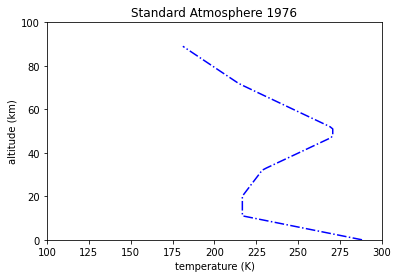

In [17]:
import matplotlib.pyplot as plt

h = []
t76 = []
for i in range(90):
    alt = i * 1000.0
    h.append(i)
    [airDensity, temperature, pressure, speedOfSoundMps] = earth.StdAtm1976(alt)
    t76.append(temperature)
    
plt.plot(t76, h, '-.', color='blue')
plt.xlabel('temperature (K)')
plt.ylabel('altitude (km)')
plt.title('Standard Atmosphere 1976')
plt.xlim([100, 300])
plt.ylim([0, 100])
#plt.grid()

In [18]:
from IPython.display import Image
Image(url= "images/StdAtm1976.png")

## Vector Class

Make a vector class for 3 element vectors.

In [19]:
class ppVector3(ppUnitTest):
    
    def __init__(self, x, y, z):
        self.X = x
        self.Y = y
        self.Z = z
        
    # defining how to print the class
    def __str__(self):
        return "(%s, %s, %s)" % (self.X, self.Y, self.Z)
    
    # overloading the + to add vectors
    def __add__(self, o):
        x = self.X + o.X
        y = self.Y + o.Y
        z = self.Z + o.Z
        return ppVector3(x,y,z)
    
    # overloading the - to subtract vectors
    def __sub__(self, o):
        x = self.X - o.X
        y = self.Y - o.Y
        z = self.Z - o.Z
        return ppVector3(x,y,z)
    
    # overloading the ^ for cross product
    def __xor__(self, o):
        x = self.Y * o.Z - self.Z * o.Y
        y = self.Z * o.X - self.X * o.Z
        z = self.X * o.Y - self.Y * o.X
        return ppVector3(x,y,z)
    
    # overloading the * to multiply scalars to a vector
    def __mul__(self, s):
        x = self.X * s
        y = self.Y * s
        z = self.Z * s
        return ppVector3(x,y,z)
    
    # overloading the / to divide a vector by a scalar
    def __truediv__(self, s):
        x = self.X / s
        y = self.Y / s
        z = self.Z / s
        return ppVector3(x,y,z)
    
    __rmul__ = __mul__
    
    def Set(self, x, y, z):
        self.X = x
        self.Y = y
        self.Z = z
        
    def Magnitude(self):
        magnitude = math.sqrt(self.X*self.X + self.Y*self.Y + self.Z*self.Z)
        return magnitude
        
    def UnitTest(self):
        v1 = ppVector3(21,33,19)
        self.TestValue( 21, v1.X, "ppVector3 init X", 1e-6)
        self.TestValue( 33, v1.Y, "ppVector3 init Y", 1e-6)
        self.TestValue( 19, v1.Z, "ppVector3 init Z", 1e-6)
        v2 = ppVector3(21,33,19)
        v3 = ppVector3(79,67,81)
        v1 = v2 + v3
        self.TestValue( 100, v1.X, "ppVector3 add X", 1e-6)
        self.TestValue( 100, v1.Y, "ppVector3 add Y", 1e-6)
        self.TestValue( 100, v1.Z, "ppVector3 add Z", 1e-6)
        v4 = ppVector3(0,3,-4)
        self.TestValue( 5, v4.Magnitude(), "ppVector3 magnitude", 1e-6)
        v4.Set( 87, 16.9, -3.1 )
        self.TestValue(   87, v4.X, "ppVector3 Set X", 1e-6)
        self.TestValue( 16.9, v4.Y, "ppVector3 Set Y", 1e-6)
        self.TestValue( -3.1, v4.Z, "ppVector3 Set Z", 1e-6)
        v5 = v3 - v2
        self.TestValue( 58, v5.X, "ppVector3 sub X", 1e-6)
        self.TestValue( 34, v5.Y, "ppVector3 sub Y", 1e-6)
        self.TestValue( 62, v5.Z, "ppVector3 sub Z", 1e-6)
        v5 = v2 - v3
        self.TestValue( -58, v5.X, "ppVector3 sub X", 1e-6)
        self.TestValue( -34, v5.Y, "ppVector3 sub Y", 1e-6)
        self.TestValue( -62, v5.Z, "ppVector3 sub Z", 1e-6)
        v6 = ppVector3(4,12,2)
        v7 = ppVector3(13,5,7)
        v8 = v6 ^ v7
        self.TestValue(   74, v8.X, "ppVector3 cross X", 1e-6)
        self.TestValue(   -2, v8.Y, "ppVector3 cross Y", 1e-6)
        self.TestValue( -136, v8.Z, "ppVector3 cross Z", 1e-6)
        v9 = 2 * v6
        self.TestValue(   8, v9.X, "ppVector3 mul X", 1e-6)
        self.TestValue(  24, v9.Y, "ppVector3 mul Y", 1e-6)
        self.TestValue(   4, v9.Z, "ppVector3 mul Z", 1e-6)
        v10 = v7 / 2
        self.TestValue(  6.5, v10.X, "ppVector3 div X", 1e-6)
        self.TestValue(  2.5, v10.Y, "ppVector3 div Y", 1e-6)
        self.TestValue(  3.5, v10.Z, "ppVector3 div Z", 1e-6)
        v11 = v10
        self.TestValue(  6.5, v11.X, "ppVector3 = X", 1e-6)
        self.TestValue(  2.5, v11.Y, "ppVector3 = Y", 1e-6)
        self.TestValue(  3.5, v11.Z, "ppVector3 = Z", 1e-6)
            
        print("Number of ppVector3 failed tests: ", self.FailCount)

In [20]:
myVector = ppVector3(0,0,0)
myVector.UnitTest()

Number of ppVector3 failed tests:  0


## Quaternion Class

Create a quaternion class.  Reference for checking [quaternion rotation](https://www.andre-gaschler.com/rotationconverter/).  Quaternion multiplication checked [here](https://www.vcalc.com/wiki/vCalc/Quaternion+Multiplication).

$t=q*r=t_0 + \mathbf{i}t_1 + \mathbf{j}t_2 + \mathbf{k}t_3$  
$t_0 = q_0r_0 - q_1r_1 - q_2r_2 - q_3r_3$  
$t_1 = q_1r_0 + q_0r_1 - q_3r_2 + q_2r_3$  
$t_2 = q_2r_0 + q_3r_1 + q_0r_2 - q_1r_3$  
$t_3 = q_3r_0 - q_2r_1 + q_1r_2 + q_0r_3$  

System b to a -> $q_{b/a}$

$u^b = q_{b/a}^{-1} * u^a * q_{b/a}$, and $q_{b/a}^{-1} = q_{a/b}$  
$u^c = q_{c/b}^{-1} q_{b/a}^{-1} \, u^a \, q_{b/a} q_{c/b}$

$v^{frd} = q_{\phi}^{-1} q_{\theta}^{-1} q_{\psi}^{-1} \, v^{ned} \, q_{\psi} q_{\theta} q_{\phi}$

$q_{frd/ned} = q_{\psi} q_{\theta} q_{\phi} = 
\begin{matrix}
\cos\frac{\phi}{2}\cos\frac{\theta}{2}\cos\frac{\psi}{2} + \sin\frac{\phi}{2}\sin\frac{\theta}{2}\sin\frac{\psi}{2}\\
\sin\frac{\phi}{2}\cos\frac{\theta}{2}\cos\frac{\psi}{2} - \cos\frac{\phi}{2}\sin\frac{\theta}{2}\sin\frac{\psi}{2} \\
\cos\frac{\phi}{2}\sin\frac{\theta}{2}\cos\frac{\psi}{2} + \sin\frac{\phi}{2}\cos\frac{\theta}{2}\sin\frac{\psi}{2} \\
\cos\frac{\phi}{2}\cos\frac{\theta}{2}\sin\frac{\psi}{2} - \sin\frac{\phi}{2}\sin\frac{\theta}{2}\cos\frac{\psi}{2}
\end{matrix}
$

$q_{ned/ecf} = 
\begin{matrix}
\phantom{-} \cos\frac{lon}{2} \cos(\frac{lat}{2} + 45^{\circ}) \\
\phantom{-} \sin\frac{lon}{2} \sin(\frac{lat}{2} + 45^{\circ}) \\
-\cos\frac{lon}{2} \sin(\frac{lat}{2} + 45^{\circ}) \\
\phantom{-} \sin\frac{lon}{2} \cos(\frac{lat}{2} + 45^{\circ})
\end{matrix}
$

$\omega^{frd} = q_{frd/ned}^{-1} q_{ned/ecf}^{-1} \, \omega^{ecf} \, q_{ned/ecf} q_{frd/ned}$

$F^{ecf} = q_{ecf/ned}^{-1} q_{ned/frd}^{-1} \, F^{frd} \, q_{ned/frd} q_{ecf/ned}$  
$\phantom{F^{ecf}} = q_{ned/ecf} q_{frd/ned} \, F^{frd} \, q_{frd/ned}^{-1} q_{ned/ecf}^{-1}$

$v^{ecf} = q_{ecf/ned}^{-1} q_{ned/frd}^{-1} \, v^{frd} \, q_{ned/frd} q_{ecf/ned}$  
$\phantom{v^{ecf}} = q_{ned/ecf} q_{frd/ned} \, v^{frd} \, q_{frd/ned}^{-1} q_{ned/ecf}^{-1}$  
  
$u^{ned} = q_{ned/frd}^{-1} \, u^{frd} \, q_{ned/frd} $  
$q_{ned/frd}^{-1} = q_{frd/ned}$  
$u^{ned} = q_{frd/ned} \, 
\begin{bmatrix}
0 \\
u
\end{bmatrix}
\, q_{frd/ned}^{-1} $  

In [21]:
class ppQuaternion(ppUnitTest):
    
    def __init__(self, n, x, y, z):
        self.N = n
        self.X = x
        self.Y = y
        self.Z = z
    
    # defining how to print the class
    def __repr__(self):
        return "(%s, %s, %s, %s)" % (self.N, self.X, self.Y, self.Z)
    
    # overloading the ~ for quaternion inverse
    def __invert__(self):
        n = self.N
        x = -self.X
        y = -self.Y
        z = -self.Z
        return ppQuaternion(n,x,y,z)
    
    # overloading the + to add quaternions
    def __add__(self, o):
        n = self.N + o.N
        x = self.X + o.X
        y = self.Y + o.Y
        z = self.Z + o.Z
        return ppQuaternion(n,x,y,z)
    
    # overlaoding the * to multiply quaternions and multiple scalars and quaternions
    def __mul__(self,o):
        n=0
        x=0
        y=0
        z=0
        if isinstance(o, ppQuaternion):
            n = self.N*o.N - self.X*o.X - self.Y*o.Y - self.Z*o.Z
            x = self.N*o.X + self.X*o.N + self.Y*o.Z - self.Z*o.Y
            y = self.N*o.Y + self.Y*o.N + self.Z*o.X - self.X*o.Z
            z = self.N*o.Z + self.Z*o.N + self.X*o.Y - self.Y*o.X
        # TODO: ppVector3 is a special case for angular differential equations
        #  this would probably be best moved out of here and create
        #  and angular velocity class that handles quaternions.  As is,
        #  this now depends on the ppVector3 class
        elif isinstance(o, ppVector3):
            n = -(self.X*o.X + self.Y*o.Y + self.Z*o.Z)
            x =   self.N*o.X + self.Y*o.Z - self.Z*o.Y
            y =   self.N*o.Y + self.Z*o.X - self.X*o.Z
            z =   self.N*o.Z + self.X*o.Y - self.Y*o.X
        else:
            n = self.N * o
            x = self.X * o
            y = self.Y * o
            z = self.Z * o
        return ppQuaternion(n,x,y,z)
    
    # so that scalar * quaternion is the same as quaternion * scalar
    __rmul__ = __mul__
    
    def Normalize(self):
        magnitude = math.sqrt(self.N*self.N + self.X*self.X + self.Y*self.Y + self.Z*self.Z)
        
        if magnitude != 0:
            self.N = self.N / magnitude
            self.X = self.X / magnitude
            self.Y = self.Y / magnitude
            self.Z = self.Z / magnitude
        
    def SetRollPitchYaw(self, roll, pitch, yaw):
        qroll  = ppQuaternion( math.cos(0.5*roll) , math.sin(0.5*roll), 0.0                , 0.0)
        qpitch = ppQuaternion( math.cos(0.5*pitch), 0.0               , math.sin(0.5*pitch), 0.0)
        qyaw   = ppQuaternion( math.cos(0.5*yaw)  , 0.0               , 0.0                , math.sin(0.5*yaw))

        # ZYX rotation
        q = qyaw*qpitch*qroll
        q.Normalize()
        
        self.N = q.N
        self.X = q.X
        self.Y = q.Y
        self.Z = q.Z
        
    def SetLatLon(self, lat, lon):
        n =  math.cos(0.5*lon)*math.cos(0.5*lat + 0.25*math.pi)
        x =  math.sin(0.5*lon)*math.sin(0.5*lat + 0.25*math.pi)
        y = -math.cos(0.5*lon)*math.sin(0.5*lat + 0.25*math.pi)
        z =  math.sin(0.5*lon)*math.cos(0.5*lat + 0.25*math.pi)
        
        q = ppQuaternion( n, x, y, z )
        q.Normalize()
        
        self.N = q.N
        self.X = q.X
        self.Y = q.Y
        self.Z = q.Z
        
    def SetQfrdWrtEcf(self, roll, pitch, yaw, lat, lon):
        qroll  = ppQuaternion( math.cos(0.5*roll) , math.sin(0.5*roll), 0.0                , 0.0)
        qpitch = ppQuaternion( math.cos(0.5*pitch), 0.0               , math.sin(0.5*pitch), 0.0)
        qyaw   = ppQuaternion( math.cos(0.5*yaw)  , 0.0               , 0.0                , math.sin(0.5*yaw))

        hLon = 0.5*lon
        hLat = 0.5*lat + 0.25*math.pi
        qlon = ppQuaternion(math.cos(hLon), 0, 0, math.sin(hLon))
        qlat = ppQuaternion(math.cos(hLat), 0, -math.sin(hLat), 0)
        
        # ZYX rotation
        q = qlon*qlat*qyaw*qpitch*qroll
        
        self.N = q.N
        self.X = q.X
        self.Y = q.Y
        self.Z = q.Z
        
    def SetPlanetRotation(self, rotationAngle_rad):
        n = math.cos(0.5*rotationAngle_rad)
        z = math.sin(0.5*rotationAngle_rad)
        
        q = ppQuaternion(n, 0.0, 0.0, z)
        q.Normalize()
        
        self.N = q.N
        self.X = q.X
        self.Y = q.Y
        self.Z = q.Z
        
    def EulerAnglesFromQ(self):
        q0 = self.N
        q1 = self.X
        q2 = self.Y
        q3 = self.Z
        
        c11 = q0*q0 + q1*q1 - q2*q2 - q3*q3
        c12 = 2.0*(q1*q2 + q0*q3)
        c13 = 2.0*(q1*q3 - q0*q2)
        c23 = 2.0*(q2*q3 + q0*q1)
        c33 = q0*q0 - q1*q1 - q2*q2 + q3*q3
        
        roll  =  math.atan2(c23,c33)
        pitch = -math.asin(c13)
        yaw   =  math.atan2(c12,c11)

        return [roll, pitch, yaw] 
              
    def EulerAnglesFromQold(self):
        qnn = self.N * self.N
        qxx = self.X * self.X
        qyy = self.Y * self.Y
        qzz = self.Z * self.Z
        
        img = qxx + qyy + qzz + qnn
        assert img != 0, "EulerAnglesFromQ all elements 0 for quaternion"
        img = 1.0 / img

        m11 = (qnn + qxx - qyy - qzz)*img
        m12 = 2.0*(self.X*self.Y + self.Z*self.N)*img
        m13 = 2.0*(self.X*self.Z - self.Y*self.N)*img
        m23 = 2.0*(self.Y*self.Z + self.X*self.N)*img
        m33 = (qnn - qxx - qyy + qzz)*img

        roll = 0
        pitch = 0
        yaw = 0
        if abs(m13) >= 1.0:
            m21 = 2.0*(self.X*self.Y - self.Z*self.N)*img
            m31 = 2.0*(self.X*self.Z + self.Y*self.N)*img;
            roll  = 0.0
            halfPi = 0.5*math.pi
            pitch = -halfPi if (m13 > 0.0) else halfPi
            yaw   = math.atan2(-m21, -m31/m13)
        else:
            roll  = math.atan2(m23,m33)  # Roll
            pitch = math.asin(-m13)      # Pitch
            yaw   = math.atan2(m12,m11)  # Yaw

        return [roll, pitch, yaw]
        
    def UnitTest(self):
        q0 = ppQuaternion(4,7,8,9)
        q0i = ~q0
        self.TestValue( 4, q0i.N, "ppQuaternion inverse", 1e-6)
        self.TestValue(-7, q0i.X, "ppQuaternion inverse", 1e-6)
        self.TestValue(-8, q0i.Y, "ppQuaternion inverse", 1e-6)
        self.TestValue(-9, q0i.Z, "ppQuaternion inverse", 1e-6)
        q1 = ppQuaternion(2,3,4,5)
        q2 = ppQuaternion(8,9,10,11)
        q3 = q1 + q2
        self.TestValue(10, q3.N, "ppQuaternion add", 1e-6)
        self.TestValue(12, q3.X, "ppQuaternion add", 1e-6)
        self.TestValue(14, q3.Y, "ppQuaternion add", 1e-6)
        self.TestValue(16, q3.Z, "ppQuaternion add", 1e-6)
        q4 = q1 * q2
        self.TestValue(-106, q4.N, "ppQuaternion multiply", 1e-6)
        self.TestValue(36, q4.X, "ppQuaternion multiply", 1e-6)
        self.TestValue(64, q4.Y, "ppQuaternion multiply", 1e-6)
        self.TestValue(56, q4.Z, "ppQuaternion multiply", 1e-6)
        q5 = 7.0 * q1
        self.TestValue(14, q5.N, "ppQuaternion scalar multiply", 1e-6)
        self.TestValue(21, q5.X, "ppQuaternion scalar multiply", 1e-6)
        self.TestValue(28, q5.Y, "ppQuaternion scalar multiply", 1e-6)
        self.TestValue(35, q5.Z, "ppQuaternion scalar multiply", 1e-6)
        q6 = q2 * 10
        self.TestValue(80, q6.N, "ppQuaternion scalar multiply", 1e-6)
        self.TestValue(90, q6.X, "ppQuaternion scalar multiply", 1e-6)
        self.TestValue(100, q6.Y, "ppQuaternion scalar multiply", 1e-6)
        self.TestValue(110, q6.Z, "ppQuaternion scalar multiply", 1e-6)
        q6.SetRollPitchYaw(0.3,-0.7,3.11)
        self.TestValue(-0.0365642, q6.N, "ppQuaternion Euler", 1e-6)
        self.TestValue(0.3412225, q6.X, "ppQuaternion Euler", 1e-6)
        self.TestValue(0.1350051, q6.Y, "ppQuaternion Euler", 1e-6)
        self.TestValue(0.9295181, q6.Z, "ppQuaternion Euler", 1e-6)
        [roll, pitch, yaw] = q6.EulerAnglesFromQ()
        self.TestValue( 0.3, roll, "ppQuaternion EulerFromQ", 1e-6)
        self.TestValue(-0.7, pitch, "ppQuaternion EulerFromQ", 1e-6)
        self.TestValue(3.11, yaw, "ppQuaternion EulerFromQ", 1e-6)
        q7 = ppQuaternion(0.6680766, 0.2325211, 0.1160514, 0.6972372)
        [roll, pitch, yaw] = q7.EulerAnglesFromQ()
        self.TestValue( 0.5, roll, "ppQuaternion EulerFromQ", 1e-6)
        self.TestValue(-0.17, pitch, "ppQuaternion EulerFromQ", 1e-6)
        self.TestValue(1.57, yaw, "ppQuaternion EulerFromQ", 1e-6)
        q8 = ppQuaternion(6,-6,6,6)
        q8.Normalize()
        self.TestValue( 0.5, q8.N, "ppQuaternion Normalize", 1e-6)
        self.TestValue(-0.5, q8.X, "ppQuaternion Normalize", 1e-6)
        self.TestValue( 0.5, q8.Y, "ppQuaternion Normalize", 1e-6)
        self.TestValue( 0.5, q8.Z, "ppQuaternion Normalize", 1e-6)
        q9 = ppQuaternion(1,3,-2,7)
        q9.Normalize()
        mag = math.sqrt(1 + 9 + 4 + 49)
        self.TestValue( 1.0/mag, q9.N, "ppQuaternion Normalize 2", 1e-6)
        self.TestValue( 3.0/mag, q9.X, "ppQuaternion Normalize 2", 1e-6)
        self.TestValue(-2.0/mag, q9.Y, "ppQuaternion Normalize 2", 1e-6)
        self.TestValue( 7.0/mag, q9.Z, "ppQuaternion Normalize 2", 1e-6)
        
        print("Number of ppQuaternion failed tests: ", self.FailCount)

In [22]:
q1 = ppQuaternion(9,4,5,6)
q1.UnitTest()

Number of ppQuaternion failed tests:  0


## Matrix Class

Create a 3x3 matrix class.

In [23]:
class ppMatrix3x3(ppUnitTest):
    A11 = 1
    A12 = 0
    A13 = 0
    
    A21 = 0
    A22 = 1
    A23 = 0
    
    A31 = 0
    A32 = 0
    A33 = 1
    
    def __mul__(self, v):
        if isinstance(v, ppVector3):
            x = self.A11 * v.X + self.A12 * v.Y + self.A13 * v.Z
            y = self.A21 * v.X + self.A22 * v.Y + self.A23 * v.Z
            z = self.A31 * v.X + self.A32 * v.Y + self.A33 * v.Z
            return ppVector3(x,y,z)
        elif isinstance(v, ppMatrix3x3):
            a11 = self.A11*v.A11 + self.A12*v.A21 + self.A13*v.A31
            a12 = self.A11*v.A12 + self.A12*v.A22 + self.A13*v.A32
            a13 = self.A11*v.A13 + self.A12*v.A23 + self.A13*v.A33

            a21 = self.A21*v.A11 + self.A22*v.A21 + self.A23*v.A31
            a22 = self.A21*v.A12 + self.A22*v.A22 + self.A23*v.A32
            a23 = self.A21*v.A13 + self.A22*v.A23 + self.A23*v.A33
            
            a31 = self.A31*v.A11 + self.A32*v.A21 + self.A33*v.A31
            a32 = self.A31*v.A12 + self.A32*v.A22 + self.A33*v.A32
            a33 = self.A31*v.A13 + self.A32*v.A23 + self.A33*v.A33
            
            a = ppMatrix3x3()
            a.SetRow1( a11, a12, a13 )
            a.SetRow2( a21, a22, a23 )
            a.SetRow3( a31, a32, a33 )
            return a
        
        else:
            a11 = self.A11 * v
            a12 = self.A12 * v
            a13 = self.A13 * v
            a21 = self.A21 * v
            a22 = self.A22 * v
            a23 = self.A23 * v
            a31 = self.A31 * v
            a32 = self.A32 * v
            a33 = self.A33 * v
            a = ppMatrix3x3()
            a.SetRow1( a11, a12, a13 )
            a.SetRow2( a21, a22, a23 )
            a.SetRow3( a31, a32, a33 )
            return a
            
            
    def SetRow1(self, a11, a12, a13):
        self.A11 = a11
        self.A12 = a12
        self.A13 = a13
        
    def SetRow2(self, a21, a22, a23):
        self.A21 = a21
        self.A22 = a22
        self.A23 = a23
        
    def SetRow3(self, a31, a32, a33):
        self.A31 = a31
        self.A32 = a32
        self.A33 = a33
        
    # defining how to print the class
    def __str__(self):
        row1 = "(%s, %s, %s)\n" % (self.A11, self.A12, self.A13)
        row2 = "(%s, %s, %s)\n" % (self.A21, self.A22, self.A23)
        row3 = "(%s, %s, %s)" % (self.A31, self.A32, self.A33)
        return row1+row2+row3
    
    def Determinant(self):
        d1 = self.A11*(self.A22*self.A33 - self.A23*self.A32)
        d2 = self.A12*(self.A23*self.A31 - self.A21*self.A33)
        d3 = self.A13*(self.A21*self.A32 - self.A22*self.A31)
        return d1+d2+d3
    
    def Inverse(self):
        D = self.Determinant()

        im = ppMatrix3x3()

        # make sure D is not 0
        if abs(D) > 1e-12:
            a11 = (self.A22*self.A33 - self.A23*self.A32)/D
            a12 = (self.A13*self.A32 - self.A12*self.A33)/D
            a13 = (self.A12*self.A23 - self.A13*self.A22)/D

            a21 = (self.A23*self.A31 - self.A21*self.A33)/D
            a22 = (self.A11*self.A33 - self.A13*self.A31)/D
            a23 = (self.A13*self.A21 - self.A11*self.A23)/D

            a31 = (self.A21*self.A32 - self.A22*self.A31)/D
            a32 = (self.A12*self.A31 - self.A11*self.A32)/D
            a33 = (self.A11*self.A22 - self.A12*self.A21)/D
            
            im.SetRow1(a11, a12, a13)
            im.SetRow2(a21, a22, a23)
            im.SetRow3(a31, a32, a33)
            
        return im
            
    def Transpose(self):        
        at = ppMatrix3x3()
        at.SetRow1(self.A11, self.A21, self.A31)
        at.SetRow2(self.A12, self.A22, self.A32)
        at.SetRow3(self.A13, self.A23, self.A33)
        return at
    
    def QuaternionToMatrix(self, q):
        n = q.N;
        x = q.X;
        y = q.Y;
        z = q.Z;

        self.SetRow1( n*n + x*x - y*y - z*z,       2.0*(x*y - n*z),       2.0*(x*z + n*y) )
        self.SetRow2(       2.0*(x*y + n*z), n*n - x*x + y*y - z*z,       2.0*(y*z - n*x) )
        self.SetRow3(       2.0*(x*z - n*y),       2.0*(y*z + n*x), n*n - x*x - y*y + z*z ) 
    
    def UnitTest(self):
        m1 = ppMatrix3x3()
        m1.SetRow1(1,2,3)
        m1.SetRow2(4,5,6)
        m1.SetRow3(7,3,9)
        self.TestValue(-30, m1.Determinant(), "ppMatrix3x3 Determinant", 1e-6)
        m1.SetRow1(1,2,3)
        m1.SetRow2(0,1,4)
        m1.SetRow3(5,6,0)
        self.TestValue(1, m1.Determinant(), "ppMatrix3x3 Determinant", 1e-6)
        m1 = m1.Inverse()
        self.TestValue(-24, m1.A11, "ppMatrix3x3 Inverse A11", 1e-6)
        self.TestValue( 18, m1.A12, "ppMatrix3x3 Inverse A12", 1e-6)
        self.TestValue(  5, m1.A13, "ppMatrix3x3 Inverse A13", 1e-6)
        self.TestValue( 20, m1.A21, "ppMatrix3x3 Inverse A21", 1e-6)
        self.TestValue(-15, m1.A22, "ppMatrix3x3 Inverse A22", 1e-6)
        self.TestValue( -4, m1.A23, "ppMatrix3x3 Inverse A23", 1e-6)
        self.TestValue( -5, m1.A31, "ppMatrix3x3 Inverse A31", 1e-6)
        self.TestValue(  4, m1.A32, "ppMatrix3x3 Inverse A32", 1e-6)
        self.TestValue(  1, m1.A33, "ppMatrix3x3 Inverse A33", 1e-6)
        
        m2 = ppMatrix3x3()
        m2.SetRow1(1,2,3)
        m2.SetRow2(4,5,6)
        m2.SetRow3(7,2,9)
        m2 = m2.Inverse()
        self.TestValue(-11/12, m2.A11, "ppMatrix3x3 Inverse A11", 1e-6)
        self.TestValue(   1/3, m2.A12, "ppMatrix3x3 Inverse A12", 1e-6)
        self.TestValue(  1/12, m2.A13, "ppMatrix3x3 Inverse A13", 1e-6)
        self.TestValue(  -1/6, m2.A21, "ppMatrix3x3 Inverse A21", 1e-6)
        self.TestValue(   1/3, m2.A22, "ppMatrix3x3 Inverse A22", 1e-6)
        self.TestValue(  -1/6, m2.A23, "ppMatrix3x3 Inverse A23", 1e-6)
        self.TestValue(   3/4, m2.A31, "ppMatrix3x3 Inverse A31", 1e-6)
        self.TestValue(  -1/3, m2.A32, "ppMatrix3x3 Inverse A32", 1e-6)
        self.TestValue(  1/12, m2.A33, "ppMatrix3x3 Inverse A33", 1e-6)
        
        m3 = ppMatrix3x3()
        m3.SetRow1( 1,2,3)
        m3.SetRow2(-4,5,6)
        m3.SetRow3( 7,8.1,9)
        m4 = m3.Transpose()
        self.TestValue(   1, m3.A11, "ppMatrix3x3 Transpose A11", 1e-6)
        self.TestValue(   2, m3.A12, "ppMatrix3x3 Transpose A12", 1e-6)
        self.TestValue(   3, m3.A13, "ppMatrix3x3 Transpose A13", 1e-6)
        self.TestValue(  -4, m3.A21, "ppMatrix3x3 Transpose A21", 1e-6)
        self.TestValue(   5, m3.A22, "ppMatrix3x3 Transpose A22", 1e-6)
        self.TestValue(   6, m3.A23, "ppMatrix3x3 Transpose A23", 1e-6)
        self.TestValue(   7, m3.A31, "ppMatrix3x3 Transpose A31", 1e-6)
        self.TestValue( 8.1, m3.A32, "ppMatrix3x3 Transpose A32", 1e-6)
        self.TestValue(   9, m3.A33, "ppMatrix3x3 Transpose A33", 1e-6)
        self.TestValue(   1, m4.A11, "ppMatrix3x3 Transpose A11", 1e-6)
        self.TestValue(  -4, m4.A12, "ppMatrix3x3 Transpose A12", 1e-6)
        self.TestValue(   7, m4.A13, "ppMatrix3x3 Transpose A13", 1e-6)
        self.TestValue(   2, m4.A21, "ppMatrix3x3 Transpose A21", 1e-6)
        self.TestValue(   5, m4.A22, "ppMatrix3x3 Transpose A22", 1e-6)
        self.TestValue( 8.1, m4.A23, "ppMatrix3x3 Transpose A23", 1e-6)
        self.TestValue(   3, m4.A31, "ppMatrix3x3 Transpose A31", 1e-6)
        self.TestValue(   6, m4.A32, "ppMatrix3x3 Transpose A32", 1e-6)
        self.TestValue(   9, m4.A33, "ppMatrix3x3 Transpose A33", 1e-6)
        
        q = ppQuaternion(0.7, 0.4, 3.2, -0.87)
        q.Normalize()
        m4.QuaternionToMatrix(q)
        self.TestValue( -0.8883823, m4.A11, "ppMatrix3x3 Quaternion A11", 1e-7)
        self.TestValue(  0.3243782, m4.A12, "ppMatrix3x3 Quaternion A12", 1e-7)
        self.TestValue(  0.3248933, m4.A13, "ppMatrix3x3 Quaternion A13", 1e-7)
        self.TestValue(  0.1152238, m4.A21, "ppMatrix3x3 Quaternion A21", 1e-7)
        self.TestValue(  0.8425504, m4.A22, "ppMatrix3x3 Quaternion A22", 1e-7)
        self.TestValue( -0.5261486, m4.A23, "ppMatrix3x3 Quaternion A23", 1e-7)
        self.TestValue( -0.4444101, m4.A31, "ppMatrix3x3 Quaternion A31", 1e-7)
        self.TestValue( -0.4299857, m4.A32, "ppMatrix3x3 Quaternion A32", 1e-7)
        self.TestValue( -0.7858829, m4.A33, "ppMatrix3x3 Quaternion A33", 1e-7)
        
        m1.SetRow1(2,6,3)
        m1.SetRow2(1,1,8)
        m1.SetRow3(5,7,-6)
        
        v1 = ppVector3(9,11,-4)
        v2 = m1 * v1
        self.TestValue(  72, v2.X, "ppMatrix3x3 Matrix * Vector X", 1e-7)
        self.TestValue( -12, v2.Y, "ppMatrix3x3 Matrix * Vector Y", 1e-7)
        self.TestValue( 146, v2.Z, "ppMatrix3x3 Matrix * Vector Z", 1e-7)
        
        m1.SetRow1(6,3,17)
        m1.SetRow2(-4,-0.1,7)
        m1.SetRow3(14,5,-1)
        m2.SetRow1(5,0,-6)
        m2.SetRow2(3,8,2)
        m2.SetRow3(-1,-4,-9)
        m3 = m1 * m2
        self.TestValue(    22, m3.A11, "ppMatrix3x3 Matrix * Matrix A11", 1e-7)
        self.TestValue(   -44, m3.A12, "ppMatrix3x3 Matrix * Matrix A12", 1e-7)
        self.TestValue(  -183, m3.A13, "ppMatrix3x3 Matrix * Matrix A13", 1e-7)
        self.TestValue( -27.3, m3.A21, "ppMatrix3x3 Matrix * Matrix A21", 1e-7)
        self.TestValue( -28.8, m3.A22, "ppMatrix3x3 Matrix * Matrix A22", 1e-7)
        self.TestValue( -39.2, m3.A23, "ppMatrix3x3 Matrix * Matrix A23", 1e-7)
        self.TestValue(    86, m3.A31, "ppMatrix3x3 Matrix * Matrix A31", 1e-7)
        self.TestValue(    44, m3.A32, "ppMatrix3x3 Matrix * Matrix A32", 1e-7)
        self.TestValue(   -65, m3.A33, "ppMatrix3x3 Matrix * Matrix A33", 1e-7)
        
        m5 = m2 * 2
        self.TestValue(    10, m5.A11, "ppMatrix3x3 Matrix * Scalar A11", 1e-7)
        self.TestValue(     0, m5.A12, "ppMatrix3x3 Matrix * Scalar A12", 1e-7)
        self.TestValue(   -12, m5.A13, "ppMatrix3x3 Matrix * Scalar A13", 1e-7)
        self.TestValue(     6, m5.A21, "ppMatrix3x3 Matrix * Scalar A21", 1e-7)
        self.TestValue(    16, m5.A22, "ppMatrix3x3 Matrix * Scalar A22", 1e-7)
        self.TestValue(     4, m5.A23, "ppMatrix3x3 Matrix * Scalar A23", 1e-7)
        self.TestValue(    -2, m5.A31, "ppMatrix3x3 Matrix * Scalar A31", 1e-7)
        self.TestValue(    -8, m5.A32, "ppMatrix3x3 Matrix * Scalar A32", 1e-7)
        self.TestValue(   -18, m5.A33, "ppMatrix3x3 Matrix * Scalar A33", 1e-7)
        
        print("Number of ppMatrix3x3 failed tests: ", self.FailCount)

In [24]:
myMatrix = ppMatrix3x3()
print(myMatrix)
myMatrix.UnitTest()

(1, 0, 0)
(0, 1, 0)
(0, 0, 1)
Number of ppMatrix3x3 failed tests:  0


## Equations of Motion

The equations of motion.

In [25]:
class ppSimulation(ppConvert):
    Time = 0.0
    TimeStep = 0.1
    Data = {}
    IC = {}
    
    AeroModelInput = []
    
    ReferenceWingSpan = 0
    ReferenceWingChord = 0
    ReferenceWingArea = 0
    
    Position = ppVector3(0, 0, 0)
    
    TotalMass = 0
    GrossWeight = 0
    TrueAirspeed = 0
    BodyVelocity = ppVector3(0, 0, 0)
    BodyAccel = ppVector3(0, 0, 0)
    BodyForce = ppVector3(0, 0, 0)
    BodyAngle = ppVector3(0, 0, 0)
    BodyAngularRate = ppVector3(0, 0, 0)
    BodyAngularAccel = ppVector3(0, 0, 0)
    
    gvJx = 0
    gvJy = 0
    gvJz = 0
    gvJxz = 0
    Gamma = 0
    InertiaMatrix = ppMatrix3x3()
    InertiaMatrixInverse = ppMatrix3x3()
    
    # moment components
    Ml = 0
    Mm = 0
    Mn = 0
    
    totalCoefficientOfDrag = 0
    
    # define outputs
    EnglishLabels = ['gePosition_ft_X', 'gePosition_ft_Y', 'gePosition_ft_Z', 
                     'feVelocity_ft_s_X', 'feVelocity_ft_s_Y', 'feVelocity_ft_s_Z', 
                     'altitudeMsl_ft', 'longitude_deg', 'latitude_deg', 'localGravity_ft_s2', 
                     'eulerAngle_deg_Yaw', 'eulerAngle_deg_Pitch', 'eulerAngle_deg_Roll', 
                     'bodyAngularRateWrtEi_deg_s_Roll', 'bodyAngularRateWrtEi_deg_s_Pitch', 
                     'bodyAngularRateWrtEi_deg_s_Yaw', 
                     'altitudeRateWrtMsl_ft_min', 'speedOfSound_ft_s', 'airDensity_slug_ft3', 
                     'ambientPressure_lbf_ft2', 'ambientTemperature_dgR', 
                     'aero_bodyForce_lbf_X', 'aero_bodyForce_lbf_Y', 'aero_bodyForce_lbf_Z', 
                     'aero_bodyMoment_ftlbf_L', 'aero_bodyMoment_ftlbf_M', 'aero_bodyMoment_ftlbf_N', 
                     'mach', 'dynamicPressure_lbf_ft2', 'trueAirspeed_nmi_h']
    
    EnglishData = {}
    
    time = []
    eiPosition_m_X = []
    eiPosition_m_Y = []
    eiPosition_m_Z = []
    gePosition_m_X = []
    gePosition_m_Y = []
    gePosition_m_Z = []
    feVelocity_m_s_X = []
    feVelocity_m_s_Y = []
    feVelocity_m_s_Z = []
    altitudeMsl_m = []
    longitude_rad = []
    latitude_rad = []
    localGravity_m_s2 = []
    eulerAngle_Roll = []
    eulerAngle_Pitch = []
    eulerAngle_Yaw = []
    bodyAngularRateWrtEi_rad_s_Roll = []
    bodyAngularRateWrtEi_rad_s_Pitch = []
    bodyAngularRateWrtEi_rad_s_Yaw = []
    trueAirspeed = []
        
    def AdvanceTime(self):
        self.time.append(self.Time)
        self.Time += self.TimeStep
        
    def AddAeroModelInput(self, input):
        self.AeroModelInput = input
        
    def EvaluateAeroModel(self):
        for d in self.AeroModelInput:
            gvAeroModel.Set(d, self.Data[d])
        gvAeroModel.Update()

    def Clear(self):
        self.Time = 0.0
        self.Data.clear()
        self.EnglishData.clear()
        self.AeroModelInput.clear()
        
        self.time.clear()
        self.eiPosition_m_X.clear()
        self.eiPosition_m_Y.clear()
        self.eiPosition_m_Z.clear()
        self.gePosition_m_X.clear()
        self.gePosition_m_Y.clear()
        self.gePosition_m_Z.clear()
        self.feVelocity_m_s_X.clear()
        self.feVelocity_m_s_Y.clear()
        self.feVelocity_m_s_Z.clear()
        self.altitudeMsl_m.clear()
        self.longitude_rad.clear()
        self.latitude_rad.clear()
        self.localGravity_m_s2.clear()
        
        self.eulerAngle_Roll.clear()
        self.eulerAngle_Pitch.clear()
        self.eulerAngle_Yaw.clear()
        
        self.bodyAngularRateWrtEi_rad_s_Roll.clear()
        self.bodyAngularRateWrtEi_rad_s_Pitch.clear()
        self.bodyAngularRateWrtEi_rad_s_Yaw.clear()
    
        self.trueAirspeed.clear()
        
    def GenerateEnglishUnits(self):
        self.EnglishData.clear()
        for key in self.EnglishLabels:
            self.EnglishData[key] = []
        
        # TODO: extract units from name
        self.EnglishData['gePosition_ft_X'] = self.ToEnglish(self.gePosition_m_X,"m")
        self.EnglishData['gePosition_ft_Y'] = self.ToEnglish(self.gePosition_m_Y,"m")
        self.EnglishData['gePosition_ft_Z'] = self.ToEnglish(self.gePosition_m_Z,"m")
        self.EnglishData['feVelocity_m_s_X'] = self.ToEnglish(self.feVelocity_m_s_X,"m")
        self.EnglishData['feVelocity_m_s_Y'] = self.ToEnglish(self.feVelocity_m_s_Y,"m")
        self.EnglishData['feVelocity_m_s_Z'] = self.ToEnglish(self.feVelocity_m_s_Z,"m")
        
        self.EnglishData['altitudeMsl_ft'] = self.ToEnglish(self.altitudeMsl_m,"m")
        self.EnglishData['longitude_deg'] = self.ToEnglish(self.longitude_rad,"rad")
        self.EnglishData['latitude_deg'] = self.ToEnglish(self.latitude_rad,"rad")
        self.EnglishData['localGravity_ft_s2'] = self.ToEnglish(self.localGravity_m_s2,"m")
        
        self.EnglishData['eulerAngle_deg_Roll'] = self.ToEnglish(self.eulerAngle_Roll,"rad")
        self.EnglishData['eulerAngle_deg_Pitch'] = self.ToEnglish(self.eulerAngle_Pitch,"rad")
        self.EnglishData['eulerAngle_deg_Yaw'] = self.ToEnglish(self.eulerAngle_Yaw,"rad")
        
        self.EnglishData['bodyAngularRateWrtEi_deg_s_Roll'] = \
            self.ToEnglish(self.bodyAngularRateWrtEi_rad_s_Roll,"rad")
        self.EnglishData['bodyAngularRateWrtEi_deg_s_Pitch'] = \
            self.ToEnglish(self.bodyAngularRateWrtEi_rad_s_Pitch,"rad")
        self.EnglishData['bodyAngularRateWrtEi_deg_s_Yaw'] = \
            self.ToEnglish(self.bodyAngularRateWrtEi_rad_s_Yaw,"rad")
        
        self.EnglishData['trueAirspeed_nmi_h'] = self.ToEnglish(self.trueAirspeed,"m_s")
     
    def NormalizeAngle(self, value, lower, upper):
        """
        Returns a value between the range lower and upper.
        Example: NormalizeAngle(181, -180, 180) returns -179
        """
        angleRange = upper - lower
        rangeValue = value - lower
        return (rangeValue - (math.floor(rangeValue / angleRange) * angleRange)) + lower
      
    def SetValue(self, label, defValue = 0):
        value = 0.0
        infoStr = "none"
        
        if label in self.IC:
            value = self.IC[label]
            infoStr = "[IC case]"
        else:
            value = defValue
            infoStr = "[default]"
        print("++", label, "=", value, infoStr)
        return value
        
    def ResetSimulation(self, ic):
        self.Clear()
    
        self.IC.clear()
        self.IC = self.SetIC(ic)
        #self.IC = ic.copy()
        print(self.IC)
        
        #self.GrossWeight = self.SetValue("grossWeight", 1)
        
        self.TimeStep = self.SetValue("timeStep", 0.1)
        
        self.TotalMass = self.SetValue("totalMass", 1)
        assert self.TotalMass != 0, "TotalMass is 0"

        self.ReferenceWingSpan = self.SetValue("referenceWingSpan")
        self.ReferenceWingChord = self.SetValue("referenceWingChord")

        wingArea = self.ReferenceWingSpan * self.ReferenceWingChord
        self.ReferenceWingArea = self.SetValue("referenceWingArea", wingArea)

        gvAeroModel.Set("aeroBodyForceCoefficient_X")
        gvAeroModel.Set("aeroBodyForceCoefficient_Y")
        gvAeroModel.Set("aeroBodyForceCoefficient_Z")

        gvAeroModel.Set("aeroBodyMomentCoefficient_Roll")
        gvAeroModel.Set("aeroBodyMomentCoefficient_Pitch")
        gvAeroModel.Set("aeroBodyMomentCoefficient_Yaw")
        
        self.TrueAirspeed = self.SetValue("trueAirspeed")
        
        angleOfAttack = self.SetValue("angleOfAttack")
        angleOfSideslip = self.SetValue("angleOfSideslip")
        u = self.TrueAirspeed * math.cos(angleOfAttack) * math.cos(angleOfSideslip);
        v = self.TrueAirspeed * math.sin(angleOfSideslip);
        w = self.TrueAirspeed * math.sin(angleOfAttack) * math.cos(angleOfSideslip);
        self.BodyVelocity.Set(u, v, w)

        self.BodyAccel.Set(0, 0, 0)
        
        # Set the rotation quaternion based on the Euler angles
        rollEulerAngle  = self.SetValue("eulerAngle_Roll")
        pitchEulerAngle = self.SetValue("eulerAngle_Pitch")
        yawEulerAngle   = self.SetValue("eulerAngle_Yaw")
        self.BodyAngle.Set( rollEulerAngle, pitchEulerAngle, yawEulerAngle )

        # Set angular rates
        P = self.SetValue("eulerAngleRate_Roll")
        Q = self.SetValue("eulerAngleRate_Pitch")
        R = self.SetValue("eulerAngleRate_Yaw")
        self.BodyAngularRate.Set( P, Q, R )
        
        # Set the inertia matrix
        i11 =  self.SetValue("bodyMomentOfInertia_X")
        i12 = -self.SetValue("bodyProductOfInertia_XY")
        i13 = -self.SetValue("bodyProductOfInertia_XZ")

        i21 = -self.SetValue("bodyProductOfInertia_YX")
        i22 =  self.SetValue("bodyMomentOfInertia_Y")
        i23 = -self.SetValue("bodyProductOfInertia_YZ")

        i31 = -self.SetValue("bodyProductOfInertia_XZ")
        i32 = -self.SetValue("bodyProductOfInertia_YZ")
        i33 =  self.SetValue("bodyMomentOfInertia_Z")

        self.InertiaMatrix.SetRow1(i11, i12, i13)
        self.InertiaMatrix.SetRow2(i21, i22, i23)
        self.InertiaMatrix.SetRow3(i31, i32, i33)
        
        self.InertiaMatrixInverse = self.InertiaMatrix.Inverse()
        
        self.gvJx = self.InertiaMatrix.A11
        self.gvJy = self.InertiaMatrix.A22
        self.gvJz = self.InertiaMatrix.A33
        self.gvJxz = self.InertiaMatrix.A13
        self.Gamma = (self.gvJx*self.gvJz) - (self.gvJxz*self.gvJxz)
        
        self.Ml = 0
        self.Mm = 0
        self.Mn = 0
    
    def AdamsBashforth(self, current, past):
        k2 = [1.5, -0.5]
        k3 = [23.0/12.0, -16.0/12.0, 5.0/12.0]
        
        x = self.TimeStep * (k2[0]*current.X + k2[1]*past.X)
        y = self.TimeStep * (k2[0]*current.Y + k2[1]*past.Y)
        z = self.TimeStep * (k2[0]*current.Z + k2[1]*past.Z)
        
        return [x, y, z]
    
    def RungeKutta4(self, Fdot, arg):
        h = self.TimeStep

        k1 = []
        arg1 = []
        for (a, f) in zip(arg, Fdot):
            k = h*f(arg)
            k1.append(k)
            arg1.append(a + 0.5*k)
        
        k2 = []
        arg2 = []
        for (a, f) in zip(arg, Fdot):
            k = h*f(arg1)
            k2.append(k)
            arg2.append(a + 0.5*k)
    
        k3 = []
        arg3 = []
        for (a, f) in zip(arg, Fdot):
            k = h*f(arg2)
            k3.append(k)
            arg3.append(a + k)

        k4 = []
        for f in Fdot:
            k4.append( h*f(arg3))

        result = []
        for (a, kc1, kc2, kc3, kc4) in zip(arg, k1, k2, k3, k4):
            result.append(a + (kc1 + 2.0*kc2 + 2.0*kc3 + kc4) / 6.0)

        return result
        
    def Reset(self, ic):
        pass
        
    def Operate(self):
        pass
    
    def Run(self, numberOfSeconds):
        endTime = int(numberOfSeconds / self.TimeStep) + 1
        for i in range(endTime):
            self.Operate()
        print("======done=======")
        
    def UnitTest(self):
        # test normalize angle between -180 and 180 (and -pi and pi)
        pi = math.pi
        for i in range(360):
            ang = i
            if ang > 179:
                ang -= 360
            self.TestValue(ang, self.NormalizeAngle(i, -180.0, 180.0), "NormalizeAngle", 0.001)
            
            ri = math.radians(i)
            rang = math.radians(ang)
            self.TestValue(rang, self.NormalizeAngle(ri, -pi, pi), "NormalizeAngle", 1e-6)
        
        
        
        print("Number of ppSimulation failed tests: ", self.FailCount)


Number of ppSimulation failed tests:  0


[Text(0.5, 1.0, 'Normalize -pi to pi')]

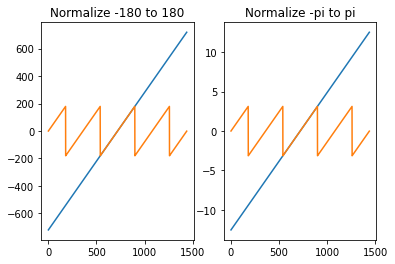

In [26]:
import matplotlib.pyplot as plt

simUnitTest = ppSimulation()
simUnitTest.UnitTest()

# make a plot normalizing the angles between -180 and 180
t = []
x = []
nx = []
rx = []
rnx = []
for a in range(1440):
    t.append(a)
    x.append(a - 720)
    na = simUnitTest.NormalizeAngle( (a-720.0), -180.0, 180.0 )
    nx.append( na )
    
    rx.append( math.radians(a-720.0) )
    rna = simUnitTest.NormalizeAngle( math.radians(a-720.0), -math.pi, math.pi )
    rnx.append( rna )
    
figAng1, (pa1, pa2) = plt.subplots(1,2)
pa1.plot(t,x,t,nx)
pa1.set(title='Normalize -180 to 180')
pa2.plot(t,rx,t,rnx)
pa2.set(title='Normalize -pi to pi')

### Flat Earth

Create a simulation for a flat Earth model. Singularities exist at the poles.  Vehicle must be symmetric about the x body axis.  Vehicle pitch must stay below $90^\circ$.

<u>Force Equations</u>  
$ \dot{U} = RV - QW - g_D \, \sin \theta + \frac{X_A + X_T}{m} $  
$ \dot{V} = PW - RU + g_D \, \sin \phi \, \cos \theta + \frac{Y_A + Y_T}{m} $  
$ \dot{W} = QU - PV + g_D \, \cos \phi \, \cos \theta + \frac{Z_A + Z_T}{m} $  
In vector form,  
$ \dot{\vec{v}} = \frac{F}{m} + R_{n/b} 
\begin{pmatrix} 0 \\ 0 \\ g_D \end{pmatrix} - \vec{\omega} \times \vec{v} $  
where $ R_{n/b} $ is the rotation matrix from NED to body.  
$ 
R_{n/b} = 
\begin{bmatrix} 
1 &         0 &        0 \\
0 &  \cos \phi & \sin \phi \\
0 & -\sin \phi & \cos \phi
\end{bmatrix} 
\begin{bmatrix} 
\cos \theta &         0 & -\sin \theta \\
0           &         1 &            0 \\
\sin \theta &         0 & \cos \theta
\end{bmatrix}
\begin{bmatrix} 
 \cos \psi &  \sin \psi & 0 \\
-\sin \psi &  \cos \psi & 0 \\
         0 &          0 & 1
\end{bmatrix}
$  
$ R_{b/n} = [R_{n/b}]^T $  

<u>Kinematic equations</u>   
$ \dot{\phi} = P + \tan \theta \, (Q \sin \phi + R \cos \phi) $  
$ \dot{\theta} = Q \cos \phi - R \sin \phi $  
$ \dot{\psi} = (Q \sin \phi + R \cos \phi) \, / \, \cos \theta $  
In vector form,  
$ \dot{\Phi} = H {\omega}^b $, where $H = 
\begin{pmatrix}
1 & \sin \phi \tan \theta & \cos \phi \tan \theta \\
0 & \cos \phi             & -\sin \phi \\
0 & \sin \phi / \cos \theta & \cos \phi / \cos \theta
\end{pmatrix} $  

<u>Moment Equations</u>  
$ \Gamma \dot{P} = J_{xz} [J_x - J_y + J_z]PQ - [J_z(J_z - J_y) + J^2_{xz}]QR + l J_z + n J_{xz}$  
$ J_y \dot{Q} = (J_z - J_x)PR - J_{xz}(P^2 - R^2) + m $  
$ \Gamma \dot{R} = [(J_x - J_y)J_x + J^2_{xz}]PQ - J_{xz}[J_x - J_y + J_z]QR + l J_{xz} n J_x $  
$ \Gamma = J_x J_z - J^2_{xz} $  
In vector form,  
$ \dot{\omega^b_{b/i}} = J^{-1}(M^b - \omega^b_{b/i} J \omega^b_{b/i} ) $

<u>Navigation Equations</u>  
$ \dot{p_N} = U c\theta c\psi + V(-c\phi s\psi + s\phi s\theta c\psi) 
+ W(s\phi s\psi + c\phi s\theta c\psi)$  
$ \dot{p_E} = U c\theta s\psi + V(c\phi c\psi + s\phi s\theta s\psi)
+ W(-s\phi c\psi + c\phi s\theta c\psi) $  
$ \dot{h} = U s\theta - V s\phi c\theta - W c\phi c\theta $  
In vector form,  
$ \dot{\vec{p}} = R_{b/n} \vec{v} $

In [27]:
class ppFlatEarth(ppSimulation):

    gD = 0
    mass = 0
    
    Planet = ppEarth()
    
    # state values
    X = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    # state DFE
    Xdot = []
    
    # the indices of the state list
    Ui = 0
    Vi = 1
    Wi = 2
    
    ϕi = 3
    θi = 4
    ψi = 5
    
    Pi = 6
    Qi = 7
    Ri = 8
    
    Ni = 9
    Ei = 10
    Zi = 11
    
    # aerodynamic forces in body frame
    Xa = 0
    Ya = 0
    Za = 0
    
    # thrust forces in body frame
    Xt = 0
    Yt = 0
    Zt = 0
    
    def Udot(self, state):
        V = state[self.Vi]
        W = state[self.Wi]
        Q = state[self.Qi]
        R = state[self.Ri]
        sinθ = math.sin(state[self.θi])
        
        assert self.mass != 0.0, "Udot mass is 0"
        value =  R*V - Q*W - self.gD*sinθ + (self.Xa + self.Xt) / self.mass
        return value
    
    def Vdot(self, state):
        U = state[self.Ui]
        W = state[self.Wi]
        P = state[self.Pi]
        R = state[self.Ri]
        sinϕ = math.sin(state[self.ϕi])
        cosθ = math.cos(state[self.θi])
        
        assert self.mass != 0.0, "Vdot mass is 0"
        value = -R*U + P*W + self.gD*sinϕ*cosθ + (self.Ya + self.Yt) / self.mass
        return value
    
    def Wdot(self, state):
        U = state[self.Ui]
        V = state[self.Vi]
        P = state[self.Pi]
        Q = state[self.Qi]
        cosϕ = math.cos(state[self.ϕi])
        cosθ = math.cos(state[self.θi])
        
        assert self.mass != 0.0, "Wdot mass is 0"
        value =  Q*U - P*V + self.gD*cosϕ*cosθ + (self.Za + self.Zt) / self.mass
        return value
    
    def ϕdot(self, state):
        P = state[self.Pi]
        Q = state[self.Qi]
        R = state[self.Ri]
        
        assert state[self.θi] < abs(math.radians(90.0)), "θdot tanθ is 90"
        tanθ = math.tan(state[self.θi])
        sinϕ = math.sin(state[self.ϕi])
        cosϕ = math.cos(state[self.ϕi])
        
        value = P + tanθ * (Q*sinϕ + R*cosϕ)
        return value
    
    def θdot(self, state):
        Q = state[self.Qi]
        R = state[self.Ri]
        cosϕ = math.cos(state[self.ϕi])
        sinϕ = math.sin(state[self.ϕi])
        
        value = Q*cosϕ - R*sinϕ
        return value
    
    def ψdot(self, state):
        Q = state[self.Qi]
        R = state[self.Ri]
        cosϕ = math.cos(state[self.ϕi])
        sinϕ = math.sin(state[self.ϕi])
        cosθ = math.cos(state[self.θi])
        
        assert cosθ != 0.0, "ψdot cosθ is 0"
        value = (Q*sinϕ + R*cosϕ) / cosθ
        return value
    
    def Pdot(self, state):
        P = state[self.Pi]
        Q = state[self.Qi]
        R = state[self.Ri]
        Jx = self.gvJx
        Jy = self.gvJy
        Jz = self.gvJz
        Jxz = self.gvJxz
        l = self.Ml
        n = self.Mn
        
        assert self.Gamma != 0.0, "Pdot Gamma is 0"
        value = (Jxz * (Jx - Jy + Jz)*P*Q - (Jz*(Jz - Jy) + Jxz*Jxz)*Q*R + Jz*l + Jxz*n) / self.Gamma
        return value
        
    def Qdot(self, state):
        P = state[self.Pi]
        Q = state[self.Qi]
        R = state[self.Ri]
        Jx = self.gvJx
        Jy = self.gvJy
        Jz = self.gvJz
        Jxz = self.gvJxz
        m = self.Mm

        assert Jy != 0.0, "Qdot Jy is 0"
        value = ((Jz - Jx)*P*R - Jxz*(P*P - R*R) + m) / Jy
        return value
        
    def Rdot(self, state):
        P = state[self.Pi]
        Q = state[self.Qi]
        R = state[self.Ri]
        Jx = self.gvJx
        Jy = self.gvJy
        Jz = self.gvJz
        Jxz = self.gvJxz
        l = self.Ml
        n = self.Mn
        
        assert self.Gamma != 0.0, "Pdot Gamma is 0"
        value = (((Jx - Jy)*Jx + Jxz*Jxz)*P*Q - Jxz*(Jx - Jy + Jz)*Q*R + Jxz*l + Jx*n) / self.Gamma
        return value
        
    def Ndot(self, state):
        U = state[self.Ui]
        V = state[self.Vi]
        W = state[self.Wi]
        cosϕ = math.cos(state[self.ϕi])
        sinϕ = math.sin(state[self.ϕi])
        cosθ = math.cos(state[self.θi])
        sinθ = math.sin(state[self.θi])
        cosψ = math.cos(state[self.ψi])
        sinψ = math.sin(state[self.ψi])
        
        value = U*cosθ*cosψ + V*(-cosϕ*sinψ + sinϕ*sinθ*cosψ)
        + W*(sinϕ*sinψ + cosϕ*sinθ*cosψ)
        return value
    
    def Edot(self, state):
        U = state[self.Ui]
        V = state[self.Vi]
        W = state[self.Wi]
        cosϕ = math.cos(state[self.ϕi])
        sinϕ = math.sin(state[self.ϕi])
        cosθ = math.cos(state[self.θi])
        sinθ = math.sin(state[self.θi])
        cosψ = math.cos(state[self.ψi])
        sinψ = math.sin(state[self.ψi])
        
        value = U*cosθ*sinψ + V*(cosϕ*cosψ + sinϕ*sinθ*sinψ)
        + W*(-sinϕ*cosψ + cosϕ*sinθ*sinψ)
        return value
    
    def Zdot(self, state):
        U = state[self.Ui]
        V = state[self.Vi]
        W = state[self.Wi]
        cosϕ = math.cos(state[self.ϕi])
        sinϕ = math.sin(state[self.ϕi])
        cosθ = math.cos(state[self.θi])
        sinθ = math.sin(state[self.θi])
        
        value = U*sinθ - V*sinϕ*cosθ - W*cosϕ*cosθ
        return value
        
    def Reset(self, ic):
        self.ResetSimulation(ic)
        
        self.gD = self.Planet.GravityConstant()
        self.mass = self.TotalMass
        
        self.Xdot.clear()
        self.Xdot = [self.Udot, self.Vdot, self.Wdot, self.ϕdot, self.θdot, self.ψdot, 
                     self.Pdot, self.Qdot, self.Rdot, self.Ndot, self.Edot, self.Zdot]
        
        self.X[self.Ui] = self.BodyVelocity.X
        self.X[self.Vi] = self.BodyVelocity.Y
        self.X[self.Wi] = self.BodyVelocity.Z
        
        self.X[self.ϕi] = self.BodyAngle.X
        self.X[self.θi] = self.BodyAngle.Y
        self.X[self.ψi] = self.BodyAngle.Z
        
        self.X[self.Pi] = self.BodyAngularRate.X
        self.X[self.Qi] = self.BodyAngularRate.Y
        self.X[self.Ri] = self.BodyAngularRate.Z
        
        self.X[self.Ni] = self.Position.X
        self.X[self.Ei] = self.Position.Y
        self.X[self.Zi] = self.SetValue("altitudeMsl")
        
        self.Xa = 0
        self.Ya = 0
        self.Za = 0
        
        self.Xt = 0
        self.Yt = 0
        self.Zt = 0
        
    def Operate(self):
        
        # save output data
        self.localGravity_m_s2.append(self.gD)
        self.altitudeMsl_m.append(self.X[self.Zi])
        self.eulerAngle_Roll.append(self.X[self.ϕi])
        self.eulerAngle_Pitch.append(self.X[self.θi])
        self.eulerAngle_Yaw.append( self.NormalizeAngle(self.X[self.ψi],-math.pi,math.pi) )
        self.trueAirspeed.append(self.TrueAirspeed)
        
        # integrate the equations
        self.X = self.RungeKutta4(self.Xdot, self.X)
        
        # Now advance time and update state equations
        self.AdvanceTime()
        
        u = self.X[self.Ui]
        v = self.X[self.Vi]
        w = self.X[self.Wi]
        self.TrueAirspeed = math.sqrt(u*u + v*v + w*w)
        
        # get dynamic pressure:  q = 1/2 rho v^2
        density = self.Planet.AirDensity(self.X[self.Zi])
        dynamicPressure = 0.5 * density * (self.TrueAirspeed)**2

        # Get the qS factor for getting dimensional forces and moments
        qS = dynamicPressure * self.ReferenceWingArea

        # Compute the aerodynamic loads
        assert self.TrueAirspeed != 0, "TrueAirspeed is 0 to model"
        self.Data["trueAirspeed"] = self.TrueAirspeed * self.MeterToFeet
        self.Data["bodyAngularRate_Roll"] = self.X[self.Pi]
        self.Data["bodyAngularRate_Pitch"] = self.X[self.Qi]
        self.Data["bodyAngularRate_Yaw"] = self.X[self.Ri]
        self.EvaluateAeroModel()
        
        # Aero forces (Newtons) body
        self.Xa = qS * gvAeroModel.DataFromName("aeroBodyForceCoefficient_X")
        self.Ya = qS * gvAeroModel.DataFromName("aeroBodyForceCoefficient_Y")
        self.Za = qS * gvAeroModel.DataFromName("aeroBodyForceCoefficient_Z")
        
        # Aero moments
        self.Ml = qS * self.ReferenceWingSpan  * gvAeroModel.DataFromName("aeroBodyMomentCoefficient_Roll")
        self.Mm = qS * self.ReferenceWingChord * gvAeroModel.DataFromName("aeroBodyMomentCoefficient_Pitch")
        self.Mn = qS * self.ReferenceWingSpan  * gvAeroModel.DataFromName("aeroBodyMomentCoefficient_Yaw")

### Oblate, Rotating Earth  (Stevens and Lewis)

$ \dot{q_0} = -0.5 * (Pq_1 + Qq_2 + Rq_3) $  
$ \dot{q_1} = 0.5 * (Pq_0 + Rq_2 - Qq_3) $  
$ \dot{q_2} = 0.5 * (Qq_0 - Rq_1 + Pq_3) $  
$ \dot{q_3} = 0.5 * (Rq_0 + Qq_1 - Pq_2) $  

$ \dot{P_x} = V_x $  
$ \dot{P_y} = V_y $  
$ \dot{P_z} = V_z $  
where $P$ and $V$ are in the ECEF frame.

$ \dot{v_x} = \frac{F_x}{m} + 2 \omega_e V_y + g_x + P_x \omega^2_e $  
$ \dot{v_y} = \frac{F_y}{m} - 2 \omega_e V_x + g_y + P_y \omega^2_e $  
$ \dot{v_z} = \frac{F_z}{m} + g_z  $  
where $\omega_e$ is the rotation rate of Earth.  The terms $g_x$, $g_y$, and $g_z$ are the $J_2$ gravity components in ECEF. This acceleration equation is in the ECEF frame.

$ \Gamma \dot{P} = J_{xz} [J_x - J_y + J_z]PQ - [J_z(J_z - J_y) + J^2_{xz}]QR + l J_z + n J_{xz}$  
$ J_y \dot{Q} = (J_z - J_x)PR - J_{xz}(P^2 - R^2) + m $  
$ \Gamma \dot{R} = [(J_x - J_y)J_x + J^2_{xz}]PQ - J_{xz}[J_x - J_y + J_z]QR + l J_{xz} n J_x $  
where $ \Gamma = J_x J_z - J^2_{xz} $  

In [28]:
class slEarthSim(ppSimulation):
    Planet = ppEarth()
    RotationAngle = 0
    EarthRotation = ppQuaternion(0, 0, 0, Planet.RotationRate)
        
    # Earth rotatation in body frame
    Per = 0
    Qer = 0
    Rer = 0
    
    # quaternion frame rotations
    #  i = inertial frame ECI
    #  e = earth centered, earth fixed ECEF
    #  n = north east down NED
    #  b = body forward right down FRD
    Qe2n = ppQuaternion(1,0,0,0)
    Qn2b = ppQuaternion(1,0,0,0)
    Qe2b = ppQuaternion(1,0,0,0)
    Qi2e = ppQuaternion(1,0,0,0)
    
    QforceEcf = ppQuaternion(0,0,0,0)
    
    # ECEF gravity components
    Gx = 0
    Gy = 0
    Gz = 0
    
    # state values: quaternion, position, acceleration and angular rates
    X = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    # the state differential equations
    Xdot = []
    
    # the indices of the state list
    Qni = 0
    Qxi = 1
    Qyi = 2
    Qzi = 3
    
    Xi = 4
    Yi = 5
    Zi = 6
    
    Vxi = 7
    Vyi = 8
    Vzi = 9
    
    Pi = 10
    Qi = 11
    Ri = 12
    
    def Qstate(self,state):
        q0 = state[self.Qni]
        q1 = state[self.Qxi]
        q2 = state[self.Qyi]
        q3 = state[self.Qzi]
        p = state[self.Pi] - self.Per
        q = state[self.Qi] - self.Qer
        r = state[self.Ri] - self.Rer
        return q0, q1, q2, q3, p, q, r
    def QnDot(self, state):
        q0, q1, q2, q3, p, q, r = self.Qstate(state)
        qnDot = -0.5*(q1*p + q2*q + q3*r)
        return qnDot
    def QxDot(self, state):
        q0, q1, q2, q3, p, q, r = self.Qstate(state)
        qxDot = 0.5*(q0*p + q2*r - q3*q)
        return qxDot
    def QyDot(self, state):
        q0, q1, q2, q3, p, q, r = self.Qstate(state)
        qyDot = 0.5*(q0*q - q1*r + q3*p )
        return qyDot
    def QzDot(self, state):
        q0, q1, q2, q3, p, q, r = self.Qstate(state)
        qzDot = 0.5*(q0*r + q1*q - q2*p)
        return qzDot
    
    def PxDot(self, state):
        return state[self.Vxi]
    def PyDot(self, state):
        return state[self.Vyi]
    def PzDot(self, state):
        return state[self.Vzi]
    
    def VxDot(self, state):
        w = self.Planet.RotationRate
        assert self.TotalMass != 0, "VxDot mass is 0"
        ax = self.QforceEcf.X / self.TotalMass
        if ax != 0:
            print("ax:",ax)
        xDot = ax + 2.0 * w * state[self.Vyi] + self.Gx + state[self.Xi] * w**2
        return xDot
    def VyDot(self, state):
        w = self.Planet.RotationRate
        assert self.TotalMass != 0, "VyDot mass is 0"
        ay = self.QforceEcf.Y / self.TotalMass
        yDot = ay - 2.0 * w * state[self.Vxi] + self.Gy + state[self.Yi] * w**2 
        return yDot
    def VzDot(self, state):
        assert self.TotalMass != 0, "VzDot mass is 0"
        az = self.QforceEcf.Z / self.TotalMass
        return (az + self.Gz)
    
    def Wstate(self, state):
        P = state[self.Pi]
        Q = state[self.Qi]
        R = state[self.Ri]
        Jx = self.gvJx
        Jy = self.gvJy
        Jz = self.gvJz
        Jxz = self.gvJxz
        Gamma = self.Gamma
        l = self.Ml
        m = self.Mm
        n = self.Mn
        return P, Q, R, Jx, Jy, Jz, Jxz, Gamma, l, m, n
    def Pdot(self, state):
        P, Q, R, Jx, Jy, Jz, Jxz, Gamma, l, m, n = self.Wstate(state)
        assert Gamma != 0, "Pdot Gamma is 0"
        pDot = (Jxz * (Jx - Jy + Jz)*P*Q - (Jz*(Jz - Jy) + Jxz*Jxz)*Q*R + Jz*l + Jxz*n) / Gamma
        return pDot
    def Qdot(self, state):
        P, Q, R, Jx, Jy, Jz, Jxz, Gamma, l, m, n = self.Wstate(state)
        assert Jy != 0.0, "Qdot Jy is 0"
        qDot = ((Jz - Jx)*P*R - Jxz*(P*P - R*R) + m) / Jy
        return qDot
    def Rdot(self, state):
        P, Q, R, Jx, Jy, Jz, Jxz, Gamma, l, m, n = self.Wstate(state)
        assert Gamma != 0.0, "Rdot Gamma is 0"
        rDot = (((Jx - Jy)*Jx + Jxz*Jxz)*P*Q - Jxz*(Jx - Jy + Jz)*Q*R + Jxz*l + Jx*n) / Gamma
        return rDot
    
    def Reset(self, ic):
        self.ResetSimulation(ic)
        
        self.RotationAngle = 0
        
        self.Planet.Latitude = self.SetValue("latitude")
        self.Planet.Longitude = self.SetValue("longitude")
        self.Planet.Altitude = self.SetValue("altitudeMsl")
        [x, y, z] = self.Planet.LlaToPcpf()
        self.Position.X = x
        self.Position.Y = y
        self.Position.Z = z
        
        # initialize the frd/ecf quaternion
        roll  = self.BodyAngle.X
        pitch = self.BodyAngle.Y
        yaw   = self.BodyAngle.Z
        lat = self.Planet.Latitude
        lon = self.Planet.Longitude
        self.Qe2b.SetQfrdWrtEcf(roll , pitch , yaw, lat, lon)
        
        # transform u,v,w to ECEF velocities
        Vecf = ppVector3(0,0,0)
        Vecf = self.Qe2b * self.BodyVelocity * ~self.Qe2b
        
        #self.mass = self.GrossWeight / self.gD
        
        self.Xdot.clear()
        self.Xdot = [self.QnDot, self.QxDot, self.QyDot, self.QzDot,
                     self.PxDot, self.PyDot, self.PzDot,
                     self.VxDot, self.VyDot, self.VzDot,
                     self.Pdot, self.Qdot, self.Rdot] 
        
        self.X[self.Qni] = self.Qe2b.N
        self.X[self.Qxi] = self.Qe2b.X
        self.X[self.Qyi] = self.Qe2b.Y
        self.X[self.Qzi] = self.Qe2b.Z
        
        self.X[self.Xi] = self.Position.X
        self.X[self.Yi] = self.Position.Y
        self.X[self.Zi] = self.Position.Z
        
        self.X[self.Vxi] = Vecf.X
        self.X[self.Vyi] = Vecf.Y
        self.X[self.Vzi] = Vecf.Z
        print("Vecf: ", Vecf.X, Vecf.Y, Vecf.Z)
        
        self.X[self.Pi] = self.BodyAngularRate.X
        self.X[self.Qi] = self.BodyAngularRate.Y
        self.X[self.Ri] = self.BodyAngularRate.Z
        
    def Operate(self):
        # create quaternions
 
        # TODO: need a check case the Q rotations are correct
        # set q frd/ecf (e2b) ECF to body
        self.Qe2b.N = self.X[self.Qni]
        self.Qe2b.X = self.X[self.Qxi]
        self.Qe2b.Y = self.X[self.Qyi]
        self.Qe2b.Z = self.X[self.Qzi]
        
        # set q ned/ecf (e2n) ECF to NED
        self.Qe2n.SetLatLon(self.Planet.Latitude, self.Planet.Longitude)
        
        # set q frd/ned (n2b) NED to body
        self.Qn2b = ~self.Qe2n * self.Qe2b
        
        # get the euler angles from the quaternion
        [roll, pitch, yaw] = self.Qn2b.EulerAnglesFromQ()
        
        # rotate the ECF position to ECI to get the inertial position
        self.Qi2e.SetPlanetRotation(self.RotationAngle)
        qgePosition = ppQuaternion( 0, self.X[self.Xi], self.X[self.Yi], self.X[self.Zi] )
        qeiPosition = self.Qi2e * qgePosition * ~self.Qi2e
        
        # save output data
        self.altitudeMsl_m.append(self.Planet.Altitude)
        self.latitude_rad.append(self.Planet.Latitude)
        self.longitude_rad.append(self.Planet.Longitude)
        self.gePosition_m_X.append(self.X[self.Xi])
        self.gePosition_m_Y.append(self.X[self.Yi])
        self.gePosition_m_Z.append(self.X[self.Zi])
        
        self.eulerAngle_Roll.append(roll)
        self.eulerAngle_Pitch.append(pitch)
        self.eulerAngle_Yaw.append(yaw)
        
        self.trueAirspeed.append(self.TrueAirspeed)
        #cosRot = math.cos(self.RotationAngle)
        #sinRot = math.sin(self.RotationAngle)
        #self.eiPosition_m_X.append(cosRot*self.X[self.Xi] - sinRot*self.X[self.Yi])
        #self.eiPosition_m_Y.append(sinRot*self.X[self.Xi] + cosRot*self.X[self.Yi])
        #self.eiPosition_m_Z.append(self.X[self.Zi])
        self.eiPosition_m_X.append(qeiPosition.X)
        self.eiPosition_m_Y.append(qeiPosition.Y)
        self.eiPosition_m_Z.append(qeiPosition.Z)
        
        # get earth rotation in the body frame
        wEarthFrd = ~self.Qe2b * self.EarthRotation * self.Qe2b
        
        # TODO: need to add body forces and rotate them to ECEF frame
        
        # set the Earth rotation in the body frame
        self.Per = wEarthFrd.X
        self.Qer = wEarthFrd.Y
        self.Rer = wEarthFrd.Z
        
        x = self.X[self.Xi]
        y = self.X[self.Yi]
        z = self.X[self.Zi]
        [self.Gx, self.Gy, self.Gz] = self.Planet.GravityJ2( x, y, z )
        g = ppVector3(self.Gx, self.Gy, self.Gz)
        self.localGravity_m_s2.append(g.Magnitude())
        
        # integrate the equations
        self.X = self.RungeKutta4(self.Xdot, self.X)
        
        # advance time and set up for next integration
        self.AdvanceTime()
        
        # get the new true airspeed
        vel = ppVector3(self.X[self.Vxi], self.X[self.Vyi], self.X[self.Vzi])
        self.TrueAirspeed = vel.Magnitude()
        
        # get dynamic pressure:  q = 1/2 rho v^2
        density = self.Planet.AirDensity(self.Planet.Altitude)
        dynamicPressure = 0.5 * density * (self.TrueAirspeed)**2

        # Get the qS factor for getting dimensional forces and moments
        qS = dynamicPressure * self.ReferenceWingArea
        
        # Compute the aerodynamic loads from the DAVE-ML model
        #  set the DAVE-ML model inputs
        assert self.TrueAirspeed != 0, "TrueAirspeed is 0 to model"
        self.Data["trueAirspeed"] = self.TrueAirspeed * self.MeterToFeet
        self.Data["bodyAngularRate_Roll"] = self.X[self.Pi]
        self.Data["bodyAngularRate_Pitch"] = self.X[self.Qi]
        self.Data["bodyAngularRate_Yaw"] = self.X[self.Ri]
        self.EvaluateAeroModel()
        
        drag = qS * self.totalCoefficientOfDrag
        QforceFrb = ppVector3(-drag, 0, 0)
        self.QforceEcf = self.Qe2b * QforceFrb * ~self.Qe2b
        
        # calculate the dimentionsal aero moments
        self.Ml = qS * self.ReferenceWingSpan  * gvAeroModel.DataFromName("aeroBodyMomentCoefficient_Roll")
        self.Mm = qS * self.ReferenceWingChord * gvAeroModel.DataFromName("aeroBodyMomentCoefficient_Pitch")
        self.Mn = qS * self.ReferenceWingSpan  * gvAeroModel.DataFromName("aeroBodyMomentCoefficient_Yaw")
        
        # update the latitude, longitude and altitude from ECEF X, Y, Z position
        self.Planet.PcpfToLlaZhu(self.X[self.Xi], self.X[self.Yi], self.X[self.Zi])
            
        # rotate the earth
        self.RotationAngle = self.Planet.RotationRate * self.Time

## Check Cases

### Check with Kinematics

Using 2D constant acceleration kinematics with no aerodynamic effects, the $y$ displacement (height) equation is:  $v_f = v_0 + gt$.  A true airspeed of 424 m/s at $45^{\circ}$ is 300 m/s in x and 300 m/s in y.  At the maximum height, $v_f = 0 \, m/s$.  Using $g = 9.82 \, m/s^2$, you get $0 = 300 - (9.82)t$.  Solving for time to reach the maximum height, $t = 300/9.82 = 30.55$ seconds.

In [29]:
ppLoadDml('models/noAero.dml')

root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  Zero Aero Output
creation date:  2021-07-21
file version:  Initial version
-variableDef-
 varDefStruct.name:  aeroBodyForceCoefficient_X
 varDefStruct.varID:  CX
 varDefStruct.units:  kgm2
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  True
 varDefStruct.initialValue:  0.0
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  True
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  aeroBodyForceCoefficient_Y
 varDefStruct.varID:  CY
 varDefStruct.units:  kgm2
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  True
 varDefStruct.initialValue:  0.0
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  True
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.na

In [30]:
%%time
ic = {
    "timeStep": [0.01, "s"],
    "totalMass": [5.0, "kg"],
    "bodyMomentOfInertia_X": [0.1, "kgm2"],
    "bodyMomentOfInertia_Y": [0.1, "kgm2"],
    "bodyMomentOfInertia_Z": [0.1, "kgm2"],
    "altitudeMsl": [10.0, "m"],
    "referenceWingChord": [0.2, "m"],
    "referenceWingSpan": [0.2, "m"],
    "referenceWingArea": [0.031415, "m2"],
    "trueAirspeed": [424.264, "m_s"],
    "angleOfAttack": [-45, "deg"]
}
flatEarthSim = ppFlatEarth()
flatEarthSim.Reset(ic)
flatEarthSim.Run(61.0)

========= SetIC ==============
{'timeStep': 0.01, 'totalMass': 5.0, 'bodyMomentOfInertia_X': 0.1, 'bodyMomentOfInertia_Y': 0.1, 'bodyMomentOfInertia_Z': 0.1, 'altitudeMsl': 10.0, 'referenceWingChord': 0.2, 'referenceWingSpan': 0.2, 'referenceWingArea': 0.031415, 'trueAirspeed': 424.264, 'angleOfAttack': -0.7853981633974483}
++ timeStep = 0.01 [IC case]
++ totalMass = 5.0 [IC case]
++ referenceWingSpan = 0.2 [IC case]
++ referenceWingChord = 0.2 [IC case]
++ referenceWingArea = 0.031415 [IC case]
++ trueAirspeed = 424.264 [IC case]
++ angleOfAttack = -0.7853981633974483 [IC case]
++ angleOfSideslip = 0 [default]
++ eulerAngle_Roll = 0 [default]
++ eulerAngle_Pitch = 0 [default]
++ eulerAngle_Yaw = 0 [default]
++ eulerAngleRate_Roll = 0 [default]
++ eulerAngleRate_Pitch = 0 [default]
++ eulerAngleRate_Yaw = 0 [default]
++ bodyMomentOfInertia_X = 0.1 [IC case]
++ bodyProductOfInertia_XY = 0 [default]
++ bodyProductOfInertia_XZ = 0 [default]
++ bodyProductOfInertia_YX = 0 [default]
++ body

In [31]:
max(flatEarthSim.altitudeMsl_m)

4598.721461301354

In [32]:
tMax = 300/9.82
print(tMax)

30.54989816700611


The time calculated above ($t = 30.55$ seconds) matches closely to the plot of the data from the EOM.

The maximum height in kinematics is: $y = \frac{1}{2} (v_0y + v_fy)t + y_0$.  Substituting in the equation, you get $y = \frac{1}{2}(300 + 0)(30.55) + 10$.

In [33]:
yMax = 0.5*(300 + 0)*(tMax) + 10
print(yMax)

4592.4847250509165


The maximum height calculated from the 2D kinematics of 4592 meters is within 10 meters of the EOM calculated value of 4600 meters.

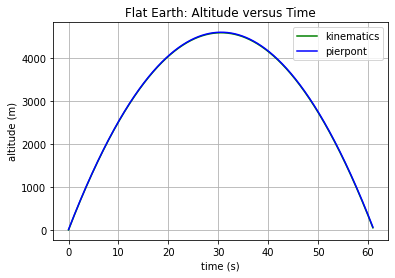

In [34]:
import matplotlib.pyplot as plt

y = []
for t in  flatEarthSim.time:
    y.append(300*t - 0.5*9.81*t*t)

fig, ck = plt.subplots()
ck.plot( flatEarthSim.time, y, 'g', flatEarthSim.time, flatEarthSim.altitudeMsl_m, 'b')
ck.legend(["kinematics","pierpont"])

ck.set(xlabel='time (s)', ylabel='altitude (m)',
       title='Flat Earth: Altitude versus Time')
ck.grid()

### Read NESC Check Cases

Function to read in check cases from NESC.  The function gets columns of data from the check case CSV files.

In [35]:
import csv

def GetCheckCaseData(fileName):
    # open the CSV file as read-only
    csvFile = open(fileName,'r')
    # strip the newline character from the header line
    headerLine = csvFile.readline().rstrip("\n")
    # make a list of headers
    header = headerLine.split(',')
    print("number of headers: ", len(header))
    print(header)
    
    # create a data dictionary with header names as keys
    Data = {}
    for h in header:
        Data[h] = []
        
    # read each row in the datafile and add the data to the data dictionary
    for row in csv.reader(csvFile):
        for (i,d) in zip(header, row):
            Data[i].append( float(d) )
            
    return Data

Data checks:  
L-2: $ D(x,y) = [\Sigma (x_i - y_i)^2]^{1/2} $  
L-Infinity-Norm: $ max_i | x_i - y_i | $  

Manhattan distance: $ \Sigma_i | x_i - y_i | $

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import math

def MinDeltaAngleDeg(angle1, angle2):
    """
    Returns the minimum delta between two angles.
    Examples:  
      20 is returned if angle1=30 and angle2=10
      20 is returned if angle1=-170 and angle2=170
    """
    delta = angle1 - angle2
    twoPi = 360.0
    if abs(delta) > abs( angle1 - (angle2 - twoPi) ):
        delta = angle1 - (angle2 - twoPi)
    if abs(delta) > abs( (angle1 - twoPi) - angle2 ):
        delta = (angle1 - twoPi) - angle2
    return delta

print("MinDeltaAngle check")
print(MinDeltaAngleDeg( 170,160),"=", 10)
print(MinDeltaAngleDeg(-160,170),"=", 30)
print(MinDeltaAngleDeg(  20,-20),"=", 40)
    
def NescCheckData(data, checkData, isAng):
    l2Sum = 0
    manSum = 0
    infNorm = 0
    for (x, y) in zip(data, checkData):
        dxy = x - y
        if isAng:
            dxy = MinDeltaAngleDeg( x, y )
        l2Sum += dxy**2
        dist = abs(dxy)
        
        manSum += dist
        if dist > infNorm:
            infNorm = dist
    return math.sqrt(l2Sum), infNorm 

def PrintErrorTable(tableTitle, labels, simData, checkData):
    print ("{:<25} {:<25} {:<25}".format('Variable', 'L2', 'L-Infinity-Norm'))
    print ("{:<25} {:<25} {:<25}".format('--------', '--', '---------------'))
    barLinf = {}
    for i in labels:
        tmpDist = NescCheckData(checkData[i], simData.EnglishData[i], i.find("_deg_"))
        print ("{:<25} {:<25} {:<25}".format(i, tmpDist[0], tmpDist[1]))
        barLinf[i] = tmpDist[1]
       
    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(barLinf.keys()))
    #plt.xlim([0, 10])
    ax.barh(y_pos, barLinf.values(), align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(barLinf.keys())
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('L-Infinity Norm')
    ax.set_title(tableTitle)

    plt.show()
    
data1 = [  1,   2, 3,   4, 5]
data2 = [1.2, 2.2, 3, 3.9, 5]

dists = NescCheckData(data1, data2, False)
print("L-2 Norm: ", dists)

data3 = [  160,   20 ]
data4 = [ -160,   30 ]

dists = NescCheckData(data3, data4, True)
print("L-2 Norm: ", dists)

MinDeltaAngle check
10 = 10
30.0 = 30
40 = 40
L-2 Norm:  (0.3000000000000001, 0.20000000000000018)
L-2 Norm:  (41.23105625617661, 40.0)


In [37]:
def MakeFlatEarthPlots(simData, checkData, simCheckLabel):
    fig0, ah = plt.subplots()
    ah.plot(checkData['time'], checkData['altitudeMsl_ft'],'g',
            simData.time, simData.EnglishData['altitudeMsl_ft'], 'b')
    ah.legend([simCheckLabel,"pierpont"])
    ah.set(xlabel='time (s)', ylabel='Altitude (ft)', title='Flat Earth: Altitude versus Time')
    ah.grid()
    
    fig1, ad = plt.subplots()
    ad.plot(checkData['time'], checkData['eulerAngle_deg_Roll'],'g',
            simData.time, simData.EnglishData['eulerAngle_deg_Roll'], 'b')
    ad.legend([simCheckLabel,"pierpont"])
    ad.set(xlabel='time (s)', ylabel='Roll (deg)', title='Flat Earth: Roll versus Time')
    ad.grid()

    fig2, ap = plt.subplots()
    ap.plot(checkData['time'], checkData['eulerAngle_deg_Pitch'],'g',
            simData.time, simData.EnglishData['eulerAngle_deg_Pitch'], 'b')
    ap.legend([simCheckLabel,"pierpont"])
    ap.set(xlabel='time (s)', ylabel='Pitch (deg)', title='Flat Earth: Pitch versus Time')
    ap.grid()
    
    fig3, ay = plt.subplots()
    ay.plot(checkData['time'], checkData['eulerAngle_deg_Yaw'],'g',
            simData.time, simData.EnglishData['eulerAngle_deg_Yaw'], 'b')
    ay.legend([simCheckLabel,"pierpont"])
    ay.set(xlabel='time (s)', ylabel='Yaw (deg)', title='Flat Earth: Yaw versus Time')
    ay.grid()

    fig4, asp = plt.subplots()
    asp.plot(checkData['time'], checkData['trueAirspeed_nmi_h'],'g', 
             simData.time, simData.EnglishData['trueAirspeed_nmi_h'], 'b')
    asp.legend([simCheckLabel,"pierpont"])
    asp.set(xlabel='time (s)', ylabel='airspeed (knots)', title='Flat Earth: True Airspeed versus Time')
    asp.grid()

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def MakePlot(simData, checkData, simCaseLabel):
    fig1 = plt.figure(constrained_layout=True)
    spec1 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig1)

    ax1 = fig1.add_subplot(spec1[0, 0])
    ax1.plot(checkData['time'], checkData['altitudeMsl_ft'],'g', 
             simData.time, simData.EnglishData['altitudeMsl_ft'], 'b')
    ax1.set(xlabel='time (s)', ylabel='altitude (ft)', title='Altitude versus Time')
    ax1.legend([simCaseLabel,"pierpont"])
    ax2 = fig1.add_subplot(spec1[0, 1])
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.plot(checkData['time'], checkData['localGravity_ft_s2'],'g',
             simData.time, simData.EnglishData['localGravity_ft_s2'], 'b')
    ax2.set(xlabel='time (s)', ylabel='localGravity (ft_s2)', title='Gravity versus Time')
    ax2.legend([simCaseLabel,"pierpont"])

    fig2, ad = plt.subplots()
    ad.plot(checkData['time'], checkData['gePosition_ft_X'],'g',
            simData.time, simData.EnglishData['gePosition_ft_X'], 'b')
    ad.legend([simCaseLabel,"pierpont"])
    ad.set(xlabel='time (s)', ylabel='gePosition_ft_X', title='ECEF X versus Time')
    ad.grid()

    fig5, ad = plt.subplots()
    ad.plot(checkData['time'], checkData['eulerAngle_deg_Roll'],'g', 
            simData.time, simData.EnglishData['eulerAngle_deg_Roll'], 'b')
    ad.legend([simCaseLabel,"pierpont"])
    ad.set(xlabel='time (s)', ylabel='Roll (deg)', title='Oblate Earth: Roll versus Time')
    ad.grid()

    fig5a, ap = plt.subplots()
    ap.plot(checkData['time'], checkData['eulerAngle_deg_Pitch'],'g', 
            simData.time, simData.EnglishData['eulerAngle_deg_Pitch'], 'b')
    ap.legend([simCaseLabel,"pierpont"])
    ap.set(xlabel='time (s)', ylabel='Pitch (deg)', title='Oblate Earth: Pitch versus Time')
    ap.grid()
    
    fig5b, ay = plt.subplots()
    ay.plot(checkData['time'], checkData['eulerAngle_deg_Yaw'],'g', 
            simData.time, simData.EnglishData['eulerAngle_deg_Yaw'], 'b')
    ay.legend([simCaseLabel,"pierpont"])
    ay.set(xlabel='time (s)', ylabel='Yaw (deg)', title='Oblate Earth: Yaw versus Time')
    ay.grid()

### Dragless Sphere - 1

Property    | English Value    | SI Value 
:----------:|-----------------:|:--------
$ I_{xx} $  | 3.6 slug-ft$^2$  | 4.881 kg-m$^2$   
$ I_{yy} $  | 3.6 slug-ft$^2$  | 4.881 kg-m$^2$  
$ I_{zz} $  | 3.6 slug-ft$^2$  | 4.881 kg-m$^2$  
$ m $       | 1.0 slug         | 14.5939 kg  
$ S $       | 0.1963495 ft$^2$ | 0.0182414654525 m$^2$  

In [39]:
ixx = 3.6 * gvConvert.Slugft2ToKgm2
print("ixx=", ixx)
mass = 1.0 * gvConvert.SlugToKg
print("mass=", mass)
S = 0.1963495 * gvConvert.SqFeetToSqMeter
print("S=", S)

ixx= 4.88094466281336
mass= 14.593902937
S= 0.018241465452480003


#### Flat Earth

In [40]:
%%time
#
print("====================")
checkFile = "NESC-check-cases/Atmospheric_checkcases/Atmos_01_DroppedSphere/Atmos_01_sim_01.csv"
gvCC1 = GetCheckCaseData(checkFile)
#
print("====================")
ppLoadDml('models/noAero.dml')
#
# 1 slug = 14.5939 kg
# 3.6 slug-ft2 = 4.881 kg-m2
# 30000 ft = 9144 m
# 0.1963495 ft2 = 0.0182414654525 m2
#
ic = {
    "totalMass": [1.0, "slug"],
    "bodyMomentOfInertia_X": [3.6, "slugft2"],
    "bodyMomentOfInertia_Y": [3.6, "slugft2"],
    "bodyMomentOfInertia_Z": [3.6, "slugft2"],
    "altitudeMsl": [30000, "ft"],
    "referenceWingChord": [0.2, "ft"],
    "referenceWingSpan": [0.2, "ft"],
    "referenceWingArea": [0.1963495, "ft2"]
}
gvFlatEarthSim = ppFlatEarth()
gvFlatEarthSim.Reset(ic)
gvFlatEarthSim.Run(30.0)
gvFlatEarthSim.GenerateEnglishUnits()

number of headers:  31
['time', 'gePosition_ft_X', 'gePosition_ft_Y', 'gePosition_ft_Z', 'feVelocity_ft_s_X', 'feVelocity_ft_s_Y', 'feVelocity_ft_s_Z', 'altitudeMsl_ft', 'longitude_deg', 'latitude_deg', 'localGravity_ft_s2', 'eulerAngle_deg_Yaw', 'eulerAngle_deg_Pitch', 'eulerAngle_deg_Roll', 'bodyAngularRateWrtEi_deg_s_Roll', 'bodyAngularRateWrtEi_deg_s_Pitch', 'bodyAngularRateWrtEi_deg_s_Yaw', 'altitudeRateWrtMsl_ft_min', 'speedOfSound_ft_s', 'airDensity_slug_ft3', 'ambientPressure_lbf_ft2', 'ambientTemperature_dgR', 'aero_bodyForce_lbf_X', 'aero_bodyForce_lbf_Y', 'aero_bodyForce_lbf_Z', 'aero_bodyMoment_ftlbf_L', 'aero_bodyMoment_ftlbf_M', 'aero_bodyMoment_ftlbf_N', 'mach', 'dynamicPressure_lbf_ft2', 'trueAirspeed_nmi_h']
root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  Zero Aero Output
creation date:  2021-07-21
file version:  Initial version
-variableDef-
 varDefStruct.name:  aeroBodyForceCoefficient_X
 varDefStruct.varID:  CX
 varDefStruct.units:  kgm2
 varDefStruct.axi

Variable                  L2                        L-Infinity-Norm          
--------                  --                        ---------------          
altitudeMsl_ft            607.9947105071013         77.22782399366406        
trueAirspeed_nmi_h        30.300144397638636        2.917378529996199        
eulerAngle_deg_Roll       1.2569020649616232        0.1253996817079627       
eulerAngle_deg_Pitch      0.0                       0                        
eulerAngle_deg_Yaw        0.0                       0                        


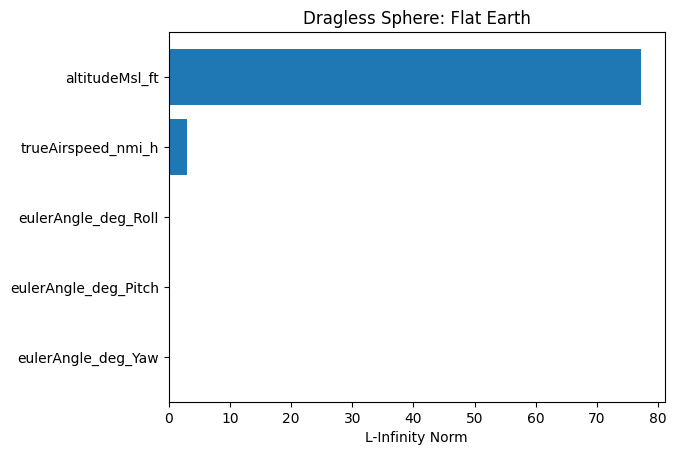

In [41]:
gvFlatEarthLabel = \
[
    'altitudeMsl_ft', 'trueAirspeed_nmi_h',
    'eulerAngle_deg_Roll', 'eulerAngle_deg_Pitch', 'eulerAngle_deg_Yaw'
]

PrintErrorTable("Dragless Sphere: Flat Earth", gvFlatEarthLabel, gvFlatEarthSim, gvCC1)

#### Oblate, Rotating Earth

In [42]:
%%time
ic = {
    "totalMass": [1.0, "slug"],
    "bodyMomentOfInertia_X": [3.6, "slugft2"],
    "bodyMomentOfInertia_Y": [3.6, "slugft2"],
    "bodyMomentOfInertia_Z": [3.6, "slugft2"],
    "altitudeMsl": [30000, "ft"],
    "referenceWingChord": [0.2, "ft"],
    "referenceWingSpan": [0.2, "ft"],
    "referenceWingArea": [0.1963495, "ft2"]
}
gvOblateRotatingEarth = slEarthSim()
gvOblateRotatingEarth.Reset(ic)
gvOblateRotatingEarth.Run(30)
gvOblateRotatingEarth.GenerateEnglishUnits()

========= SetIC ==============
{'totalMass': 14.593902937, 'bodyMomentOfInertia_X': 4.88094466281336, 'bodyMomentOfInertia_Y': 4.88094466281336, 'bodyMomentOfInertia_Z': 4.88094466281336, 'altitudeMsl': 9144.0, 'referenceWingChord': 0.06096000000000001, 'referenceWingSpan': 0.06096000000000001, 'referenceWingArea': 0.018241465452480003}
++ timeStep = 0.1 [default]
++ totalMass = 14.593902937 [IC case]
++ referenceWingSpan = 0.06096000000000001 [IC case]
++ referenceWingChord = 0.06096000000000001 [IC case]
++ referenceWingArea = 0.018241465452480003 [IC case]
++ trueAirspeed = 0 [default]
++ angleOfAttack = 0 [default]
++ angleOfSideslip = 0 [default]
++ eulerAngle_Roll = 0 [default]
++ eulerAngle_Pitch = 0 [default]
++ eulerAngle_Yaw = 0 [default]
++ eulerAngleRate_Roll = 0 [default]
++ eulerAngleRate_Pitch = 0 [default]
++ eulerAngleRate_Yaw = 0 [default]
++ bodyMomentOfInertia_X = 4.88094466281336 [IC case]
++ bodyProductOfInertia_XY = 0 [default]
++ bodyProductOfInertia_XZ = 0 [def

Variable                  L2                        L-Infinity-Norm          
--------                  --                        ---------------          
altitudeMsl_ft            0.132658503212526         0.02048735810240032      
longitude_deg             1.840404761574716e-10     3.1393235335245e-11      
latitude_deg              0.0                       0                        
localGravity_ft_s2        8.923802486168079e-05     9.171880087421869e-06    
gePosition_ft_X           0.1343059782985569        0.020609743893146515     
gePosition_ft_Y           6.717601039765743e-05     1.1453364173519276e-05   
gePosition_ft_Z           0.0                       0                        
eulerAngle_deg_Roll       2.5437306921432218e-08    2.5527049640761135e-09   
eulerAngle_deg_Pitch      3.632333118253663e-19     4.079942171239155e-20    
eulerAngle_deg_Yaw        4.446769635169959e-16     3.7272118343786e-17      


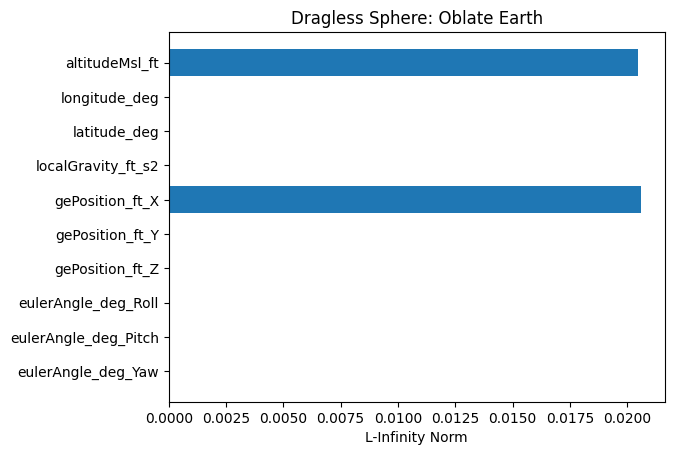

In [43]:
gvOblateEarthLabel = \
[
    'altitudeMsl_ft', 'longitude_deg', 'latitude_deg', 'localGravity_ft_s2', 
    'gePosition_ft_X', 'gePosition_ft_Y', 'gePosition_ft_Z', 
    'eulerAngle_deg_Roll', 'eulerAngle_deg_Pitch', 'eulerAngle_deg_Yaw'
]

PrintErrorTable("Dragless Sphere: Oblate Earth", gvOblateEarthLabel, gvOblateRotatingEarth, gvCC1)

### Dragless Tumbling Brick - 2

Property    | English Value    | SI Value 
:----------:|-----------------:|:--------
$ I_{xx} $  | 0.001894220 slug-ft$^2$  | 0.002568217477249 kg-m$^2$   
$ I_{yy} $  | 0.006211019 slug-ft$^2$  | 0.00842101104799105 kg-m$^2$  
$ I_{zz} $  | 0.007194665 slug-ft$^2$  | 0.00975465595123675 kg-m$^2$  
$ m $       | 0.155404754 slug         | 2.2679619056149 kg  
$ S $       | 0.22222 ft$^2$ | 0.020644913548800003 m$^2$  
$ b $       | 0.33333 ft     | 0.1016 m  
$ \bar{c} $ | 0.66667 ft     | 0.2032 m  

In [44]:
mass = 0.155404754 * gvConvert.SlugToKg
print("m=", mass)

ixx = 0.001894220 * gvConvert.Slugft2ToKgm2
print("Ixx=", ixx)
iyy = 0.006211019 * gvConvert.Slugft2ToKgm2
print("Iyy=", iyy)
izz = 0.007194665 * gvConvert.Slugft2ToKgm2
print("Izz=", izz)

cbar = 0.66667 * gvConvert.FeetToMeter
print("cbar=", cbar)
b = 0.33333 * gvConvert.FeetToMeter
print("b=", b)
s = 0.22222 * gvConvert.SqFeetToSqMeter
print("s=", s)

m= 2.2679618958243624
Ixx= 0.002568217499776201
Iyy= 0.008421011121856215
Izz= 0.009754656036800024
cbar= 0.203201016
b= 0.101598984
s= 0.020644913548800003


#### Flat Earth

In [45]:
%%time
checkFile = "NESC-check-cases/Atmospheric_checkcases/Atmos_02_TumblingBrickNoDamping/Atmos_02_sim_01.csv"
gvCC2 = GetCheckCaseData(checkFile)
#
print("====================")
ppLoadDml('models/noAero.dml')
CheckModel()
#
ic = {
    "totalMass": [0.155404754, "slug"],
    "bodyMomentOfInertia_X": [0.001894220, "slugft2"],
    "bodyMomentOfInertia_Y": [0.006211019, "slugft2"],
    "bodyMomentOfInertia_Z": [0.007194665, "slugft2"],
    "altitudeMsl": [30000, "ft"],
    "referenceWingChord": [0.66667, "ft"],
    "referenceWingSpan": [0.33333, "ft"],
    "referenceWingArea": [0.22222, "ft"],
    "eulerAngleRate_Roll": [10, "deg_s"],
    "eulerAngleRate_Pitch": [20, "deg_s"],
    "eulerAngleRate_Yaw": [30, "deg_s"]
}
gvFlatEarthSim.Reset(ic)
gvFlatEarthSim.Run(30.0)
gvFlatEarthSim.GenerateEnglishUnits()

number of headers:  31
['time', 'gePosition_ft_X', 'gePosition_ft_Y', 'gePosition_ft_Z', 'feVelocity_ft_s_X', 'feVelocity_ft_s_Y', 'feVelocity_ft_s_Z', 'altitudeMsl_ft', 'longitude_deg', 'latitude_deg', 'localGravity_ft_s2', 'eulerAngle_deg_Yaw', 'eulerAngle_deg_Pitch', 'eulerAngle_deg_Roll', 'bodyAngularRateWrtEi_deg_s_Roll', 'bodyAngularRateWrtEi_deg_s_Pitch', 'bodyAngularRateWrtEi_deg_s_Yaw', 'altitudeRateWrtMsl_ft_min', 'speedOfSound_ft_s', 'airDensity_slug_ft3', 'ambientPressure_lbf_ft2', 'ambientTemperature_dgR', 'aero_bodyForce_lbf_X', 'aero_bodyForce_lbf_Y', 'aero_bodyForce_lbf_Z', 'aero_bodyMoment_ftlbf_L', 'aero_bodyMoment_ftlbf_M', 'aero_bodyMoment_ftlbf_N', 'mach', 'dynamicPressure_lbf_ft2', 'trueAirspeed_nmi_h']
root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  Zero Aero Output
creation date:  2021-07-21
file version:  Initial version
-variableDef-
 varDefStruct.name:  aeroBodyForceCoefficient_X
 varDefStruct.varID:  CX
 varDefStruct.units:  kgm2
 varDefStruct.axi

Variable                  L2                        L-Infinity-Norm          
--------                  --                        ---------------          
altitudeMsl_ft            607.972054527782          77.22500410951034        
trueAirspeed_nmi_h        30.278799187883976        2.9152206853502776       
eulerAngle_deg_Roll       0.9696393367797839        0.1253209330691334       
eulerAngle_deg_Pitch      0.8533820770548749        0.11575857923671151      
eulerAngle_deg_Yaw        0.2980578394513776        0.03904847535990541      


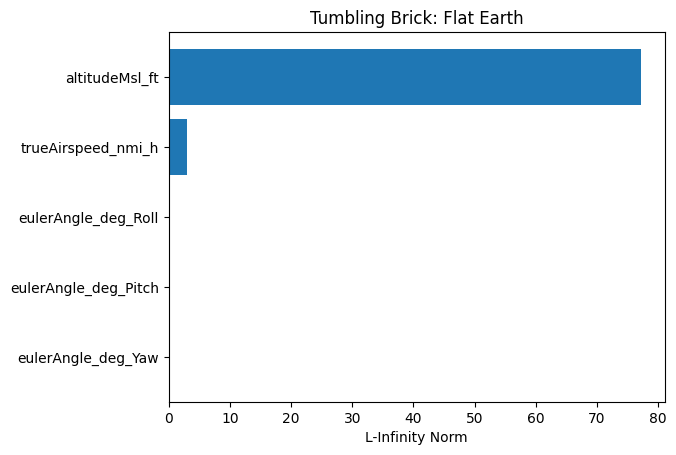

In [46]:
PrintErrorTable("Tumbling Brick: Flat Earth", gvFlatEarthLabel, gvFlatEarthSim, gvCC2)

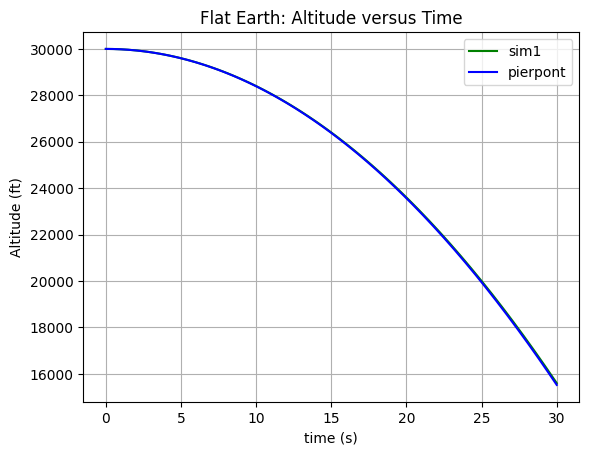

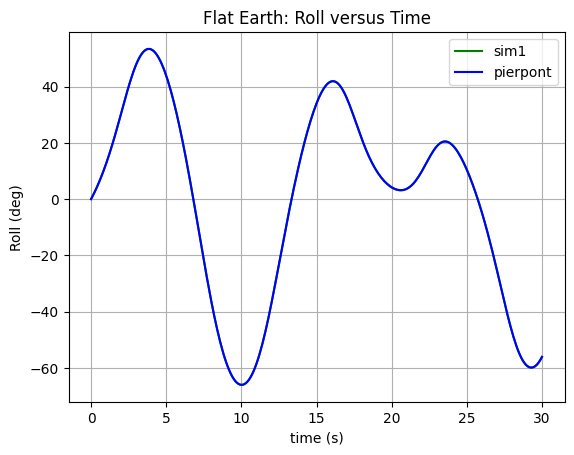

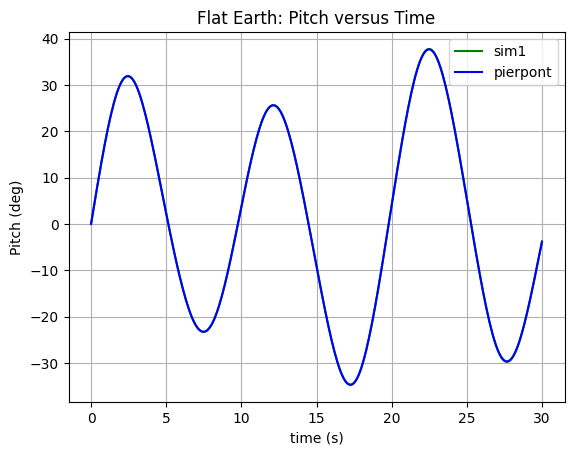

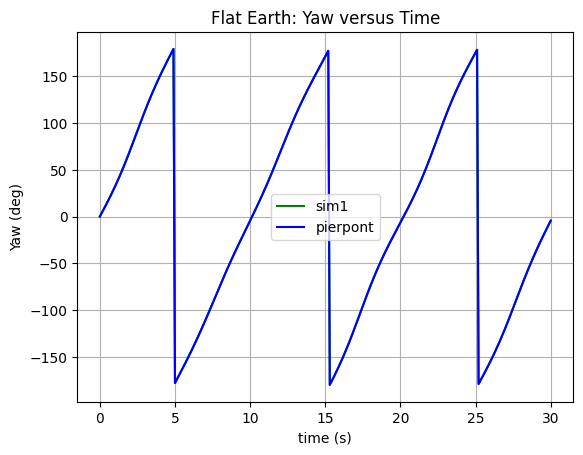

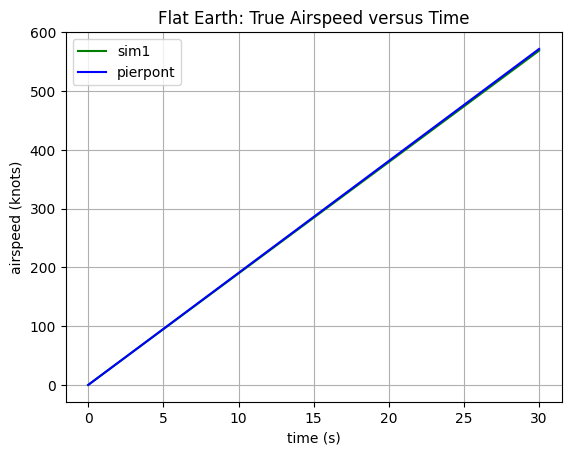

In [47]:
MakeFlatEarthPlots(gvFlatEarthSim, gvCC2, "sim1")

#### Oblate, Rotating Earth

In [48]:
%%time
ic = {
    "totalMass": [0.155404754, "slug"],
    "bodyMomentOfInertia_X": [0.001894220, "slugft2"],
    "bodyMomentOfInertia_Y": [0.006211019, "slugft2"],
    "bodyMomentOfInertia_Z": [0.007194665, "slugft2"],
    "altitudeMsl": [30000, "ft"],
    "referenceWingChord": [0.66667, "ft"],
    "referenceWingSpan": [0.33333, "ft"],
    "referenceWingArea": [0.22222, "ft"],
    "eulerAngleRate_Roll": [10, "deg_s"],
    "eulerAngleRate_Pitch": [20, "deg_s"],
    "eulerAngleRate_Yaw": [30, "deg_s"]
}
gvOblateRotatingEarth.Reset(ic)
gvOblateRotatingEarth.Run(30)
gvOblateRotatingEarth.GenerateEnglishUnits()

========= SetIC ==============
{'totalMass': 2.2679618958243624, 'bodyMomentOfInertia_X': 0.002568217499776201, 'bodyMomentOfInertia_Y': 0.008421011121856215, 'bodyMomentOfInertia_Z': 0.009754656036800024, 'altitudeMsl': 9144.0, 'referenceWingChord': 0.203201016, 'referenceWingSpan': 0.101598984, 'referenceWingArea': 0.067732656, 'eulerAngleRate_Roll': 0.17453292519943295, 'eulerAngleRate_Pitch': 0.3490658503988659, 'eulerAngleRate_Yaw': 0.5235987755982988}
++ timeStep = 0.1 [default]
++ totalMass = 2.2679618958243624 [IC case]
++ referenceWingSpan = 0.101598984 [IC case]
++ referenceWingChord = 0.203201016 [IC case]
++ referenceWingArea = 0.067732656 [IC case]
++ trueAirspeed = 0 [default]
++ angleOfAttack = 0 [default]
++ angleOfSideslip = 0 [default]
++ eulerAngle_Roll = 0 [default]
++ eulerAngle_Pitch = 0 [default]
++ eulerAngle_Yaw = 0 [default]
++ eulerAngleRate_Roll = 0.17453292519943295 [IC case]
++ eulerAngleRate_Pitch = 0.3490658503988659 [IC case]
++ eulerAngleRate_Yaw = 0.5

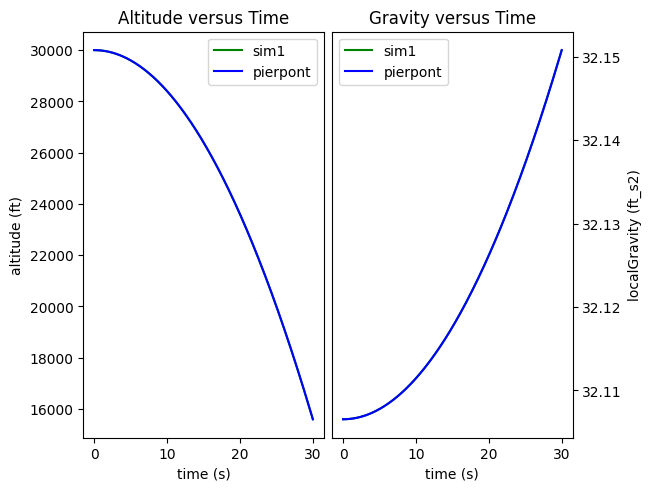

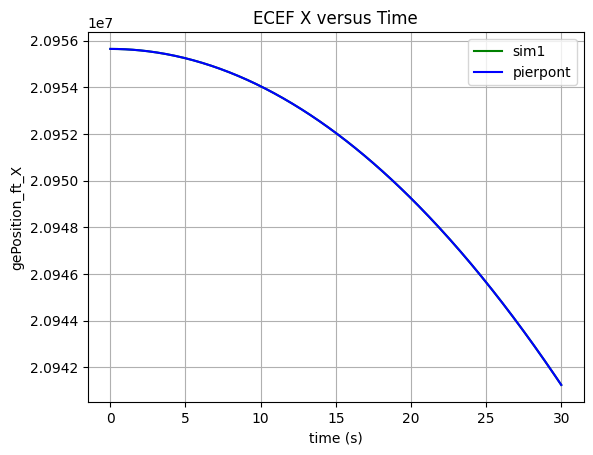

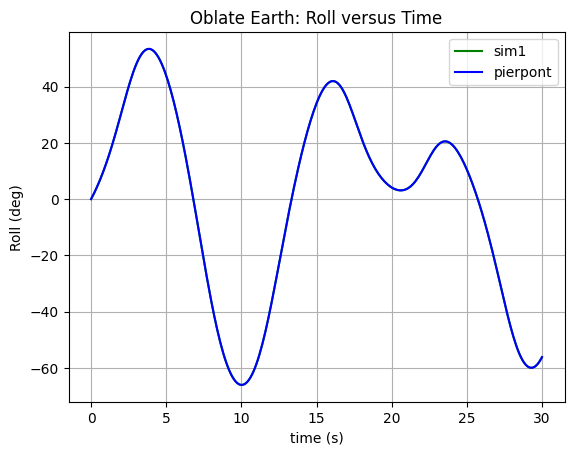

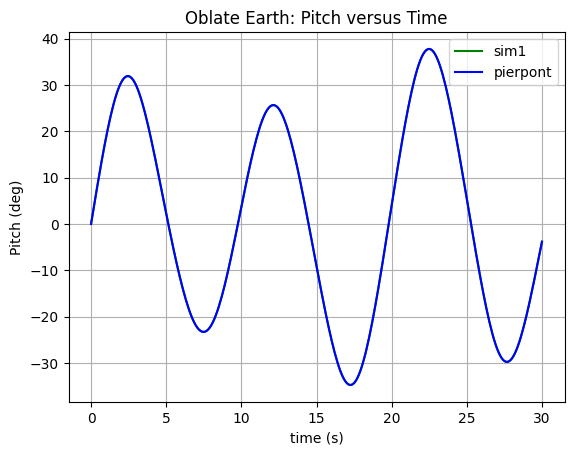

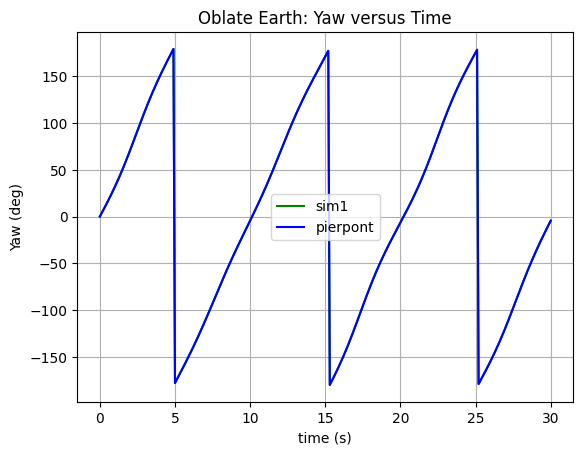

In [49]:
MakePlot(gvOblateRotatingEarth, gvCC2, "sim1")

Variable                  L2                        L-Infinity-Norm          
--------                  --                        ---------------          
altitudeMsl_ft            0.132658503212526         0.02048735810240032      
longitude_deg             1.840404761574716e-10     3.1393235335245e-11      
latitude_deg              0.0                       0                        
localGravity_ft_s2        8.923802486168079e-05     9.171880087421869e-06    
gePosition_ft_X           0.1343059782985569        0.020609743893146515     
gePosition_ft_Y           6.717601039765743e-05     1.1453364173519276e-05   
gePosition_ft_Z           0.0                       0                        
eulerAngle_deg_Roll       0.02661660809333747       0.003678374584481503     
eulerAngle_deg_Pitch      0.025190519978331032      0.0034552761165556056    
eulerAngle_deg_Yaw        0.01326283857690703       0.0019424252806858888    


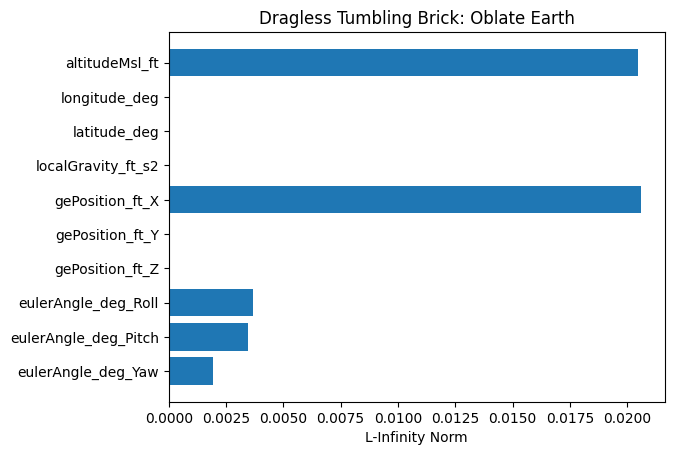

In [50]:
PrintErrorTable("Dragless Tumbling Brick: Oblate Earth", gvOblateEarthLabel, gvOblateRotatingEarth, gvCC2)

### Tumbling Brick Damping - 3

Tumbling brick with damping check case

#### Flat Earth

Run a simulation for 30 seconds at a time step of 0.1 seconds.

In [51]:
%%time
checkFile = "NESC-check-cases/Atmospheric_checkcases/Atmos_03_TumblingBrickDamping/Atmos_03_sim_01.csv"
gvCC3 = GetCheckCaseData(checkFile)
#
print("====================")
ppLoadDml('models/NESC/brick_aero_mod.dml')
CheckModel()
#
ic = {
    "totalMass": [0.155404754, "slug"],
    "bodyMomentOfInertia_X": [0.001894220, "slugft2"],
    "bodyMomentOfInertia_Y": [0.006211019, "slugft2"],
    "bodyMomentOfInertia_Z": [0.007194665, "slugft2"],
    "altitudeMsl": [30000, "ft"],
    "referenceWingChord": [0.66667, "ft"],
    "referenceWingSpan": [0.33333, "ft"],
    "referenceWingArea": [0.22222, "ft2"],
    "eulerAngleRate_Roll": [10, "deg_s"],
    "eulerAngleRate_Pitch": [20, "deg_s"],
    "eulerAngleRate_Yaw": [30, "deg_s"]
}
inputs = ["trueAirspeed", "bodyAngularRate_Roll", "bodyAngularRate_Pitch", "bodyAngularRate_Yaw"]
gvFlatEarthSim.Reset(ic)
gvFlatEarthSim.AddAeroModelInput(inputs)
gvFlatEarthSim.Run(30.0)
gvFlatEarthSim.GenerateEnglishUnits()

number of headers:  31
['time', 'gePosition_ft_X', 'gePosition_ft_Y', 'gePosition_ft_Z', 'feVelocity_ft_s_X', 'feVelocity_ft_s_Y', 'feVelocity_ft_s_Z', 'altitudeMsl_ft', 'longitude_deg', 'latitude_deg', 'localGravity_ft_s2', 'eulerAngle_deg_Yaw', 'eulerAngle_deg_Pitch', 'eulerAngle_deg_Roll', 'bodyAngularRateWrtEi_deg_s_Roll', 'bodyAngularRateWrtEi_deg_s_Pitch', 'bodyAngularRateWrtEi_deg_s_Yaw', 'altitudeRateWrtMsl_ft_min', 'speedOfSound_ft_s', 'airDensity_slug_ft3', 'ambientPressure_lbf_ft2', 'ambientTemperature_dgR', 'aero_bodyForce_lbf_X', 'aero_bodyForce_lbf_Y', 'aero_bodyForce_lbf_Z', 'aero_bodyMoment_ftlbf_L', 'aero_bodyMoment_ftlbf_M', 'aero_bodyMoment_ftlbf_N', 'mach', 'dynamicPressure_lbf_ft2', 'trueAirspeed_nmi_h']
root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  Example brick aerodynamic model
creation date:  2012-10-05
file version:  Mod D, 2021-05-01
-variableDef-
 varDefStruct.name:  referenceWingArea
 varDefStruct.varID:  SWING
 varDefStruct.units:  ft2
 varDef

Variable                  L2                        L-Infinity-Norm          
--------                  --                        ---------------          
altitudeMsl_ft            607.9829747297271         77.22618244503428        
trueAirspeed_nmi_h        30.29929205599481         2.9172948944294603       
eulerAngle_deg_Roll       4.115319287865008         0.4073996530980857       
eulerAngle_deg_Pitch      2.4299375300946506        0.3420764770645235       
eulerAngle_deg_Yaw        9.941099709629293         0.8768454992063255       


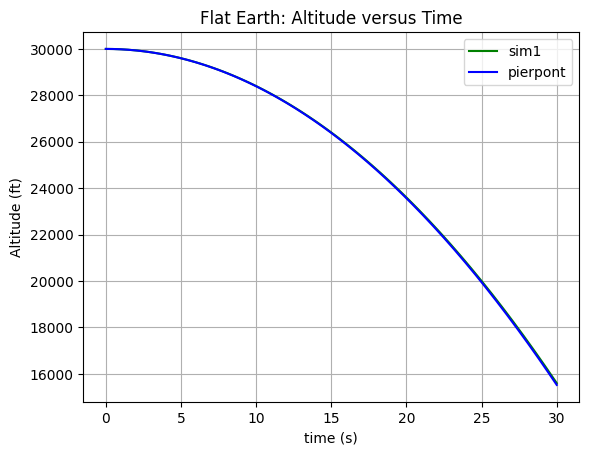

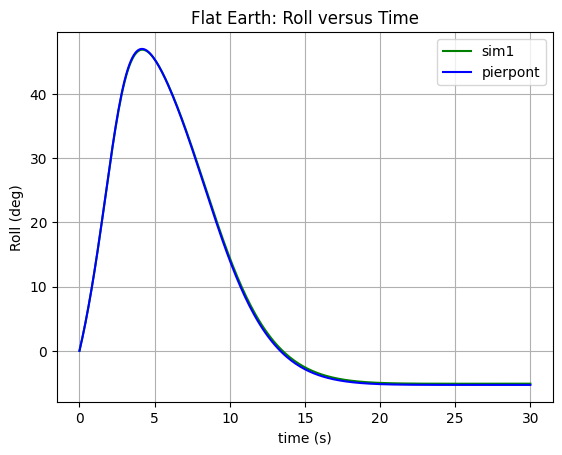

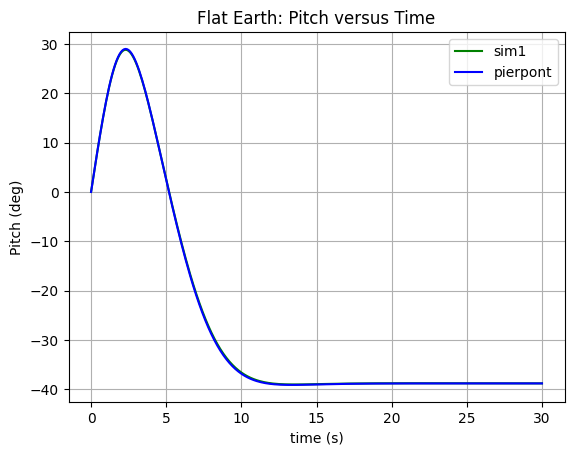

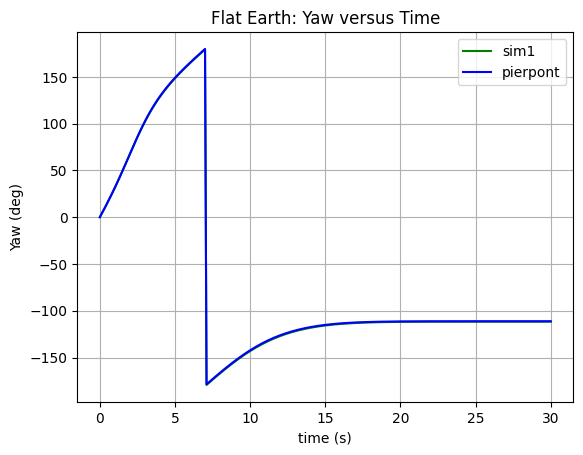

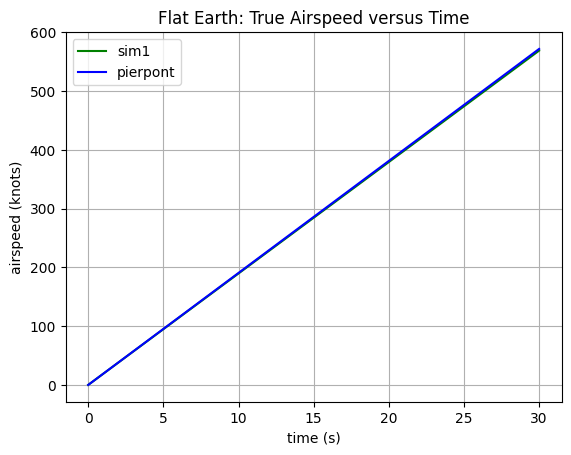

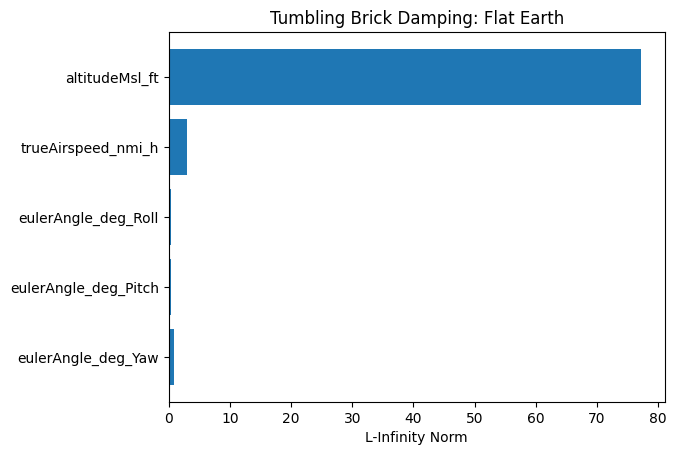

In [52]:
MakeFlatEarthPlots(gvFlatEarthSim, gvCC3, "sim1")
PrintErrorTable("Tumbling Brick Damping: Flat Earth", gvFlatEarthLabel, gvFlatEarthSim, gvCC3)

#### Oblate, Rotating Earth

In [53]:
%%time
ic = {
    "totalMass": [0.155404754, "slug"],
    "bodyMomentOfInertia_X": [0.001894220, "slugft2"],
    "bodyMomentOfInertia_Y": [0.006211019, "slugft2"],
    "bodyMomentOfInertia_Z": [0.007194665, "slugft2"],
    "altitudeMsl": [30000, "ft"],
    "referenceWingChord": [0.66667, "ft"],
    "referenceWingSpan": [0.33333, "ft"],
    "referenceWingArea": [0.22222, "ft2"],
    "eulerAngleRate_Roll": [10.0, "deg_s"],
    "eulerAngleRate_Pitch": [20.0, "deg_s"],
    "eulerAngleRate_Yaw": [30.0, "deg_s"]
}
inputs = ["trueAirspeed", "bodyAngularRate_Roll", "bodyAngularRate_Pitch", "bodyAngularRate_Yaw"]
gvOblateRotatingEarth.Reset(ic)
gvOblateRotatingEarth.AddAeroModelInput(inputs)
gvOblateRotatingEarth.Run(30)
gvOblateRotatingEarth.GenerateEnglishUnits()

========= SetIC ==============
{'totalMass': 2.2679618958243624, 'bodyMomentOfInertia_X': 0.002568217499776201, 'bodyMomentOfInertia_Y': 0.008421011121856215, 'bodyMomentOfInertia_Z': 0.009754656036800024, 'altitudeMsl': 9144.0, 'referenceWingChord': 0.203201016, 'referenceWingSpan': 0.101598984, 'referenceWingArea': 0.020644913548800003, 'eulerAngleRate_Roll': 0.17453292519943295, 'eulerAngleRate_Pitch': 0.3490658503988659, 'eulerAngleRate_Yaw': 0.5235987755982988}
++ timeStep = 0.1 [default]
++ totalMass = 2.2679618958243624 [IC case]
++ referenceWingSpan = 0.101598984 [IC case]
++ referenceWingChord = 0.203201016 [IC case]
++ referenceWingArea = 0.020644913548800003 [IC case]
++ trueAirspeed = 0 [default]
++ angleOfAttack = 0 [default]
++ angleOfSideslip = 0 [default]
++ eulerAngle_Roll = 0 [default]
++ eulerAngle_Pitch = 0 [default]
++ eulerAngle_Yaw = 0 [default]
++ eulerAngleRate_Roll = 0.17453292519943295 [IC case]
++ eulerAngleRate_Pitch = 0.3490658503988659 [IC case]
++ eulerA

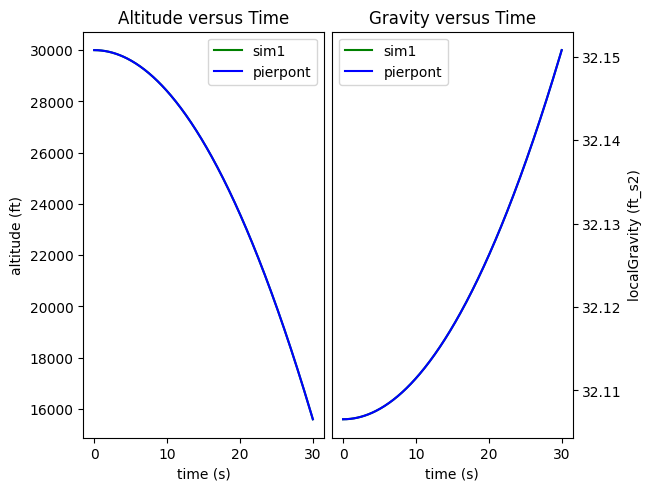

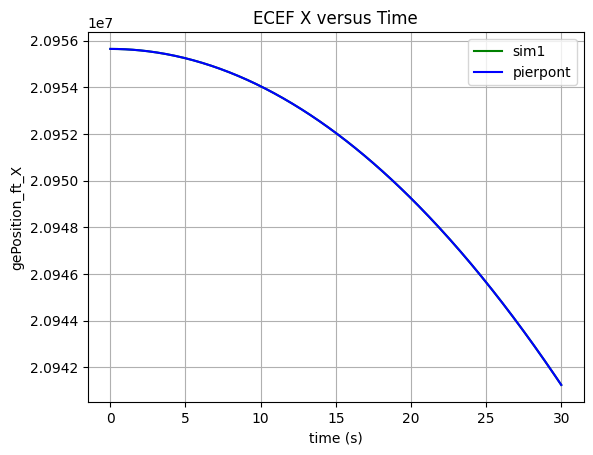

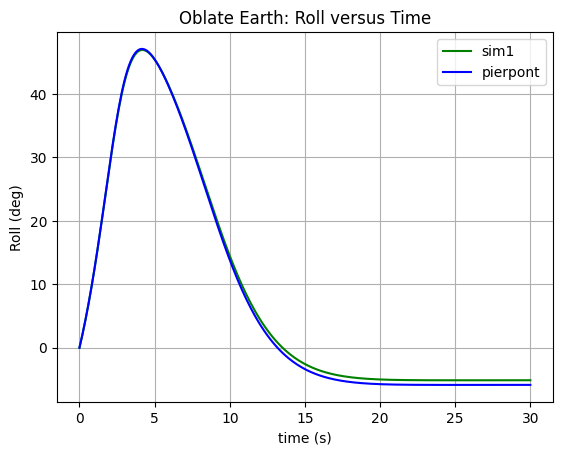

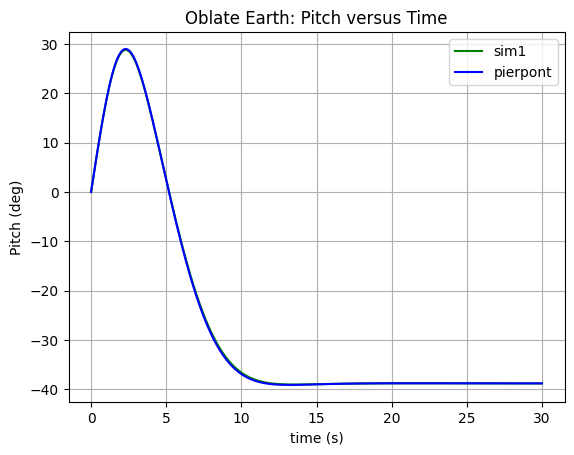

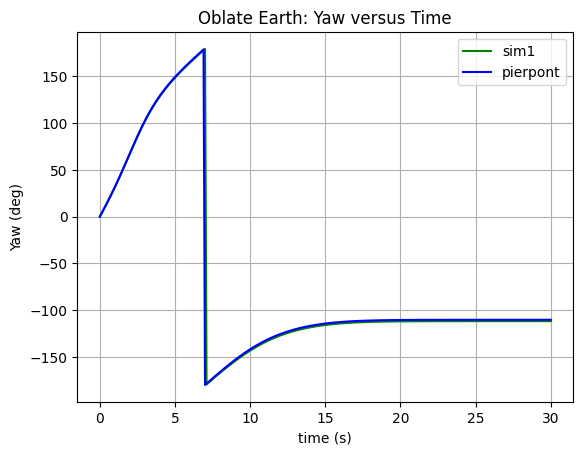

In [54]:
MakePlot(gvOblateRotatingEarth, gvCC3, "sim1")

Variable                  L2                        L-Infinity-Norm          
--------                  --                        ---------------          
altitudeMsl_ft            0.1411402118223276        0.02177725810179254      
longitude_deg             2.0649476793351563e-10    3.5255035334494107e-11   
latitude_deg              0.0                       0                        
localGravity_ft_s2        1.0779742411875166e-05    6.735199136187475e-07    
gePosition_ft_X           0.14276753800880893       0.021909743547439575     
gePosition_ft_Y           7.537771387173215e-05     1.2863464171175565e-05   
gePosition_ft_Z           0.0                       0                        
eulerAngle_deg_Roll       11.016248991497301        0.8105152209742009       
eulerAngle_deg_Pitch      2.787238066784144         0.40670110493388734      
eulerAngle_deg_Yaw        22.54233249753164         1.5857787776205328       


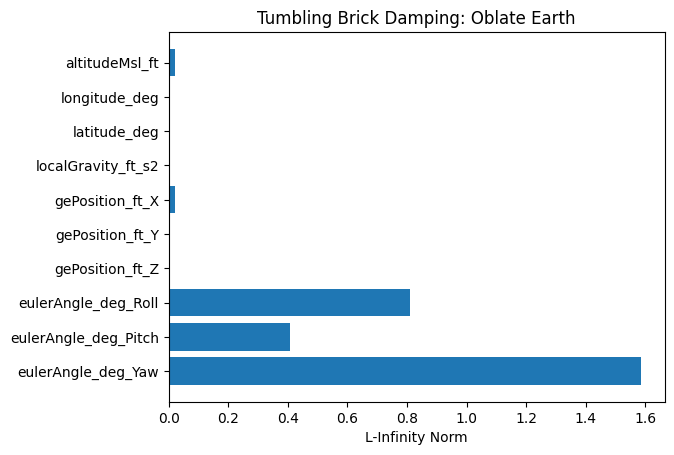

In [55]:
PrintErrorTable("Tumbling Brick Damping: Oblate Earth", gvOblateEarthLabel, gvOblateRotatingEarth, gvCC3)

### Sphere dropping over rotating, ellipsoidal Earth - 6

In [56]:
%%time
ppLoadDml('models/NESC/cannonball_inertia.dml')
CheckModel()
#
ic = {
    "totalMass": [1.0, "slug"],
    "bodyMomentOfInertia_X": [3.6, "slugft2"],
    "bodyMomentOfInertia_Y": [3.6, "slugft2"],
    "bodyMomentOfInertia_Z": [3.6, "slugft2"],
    "altitudeMsl": [30000, "ft"],
    "referenceWingChord": [0.2, "ft"],
    "referenceWingSpan": [0.2, "ft"],
    "referenceWingArea": [0.1963495, "ft2"]
}
gvOblateRotatingEarth.Reset(ic)
gvOblateRotatingEarth.totalCoefficientOfDrag = 0.1
gvOblateRotatingEarth.Run(30)
gvOblateRotatingEarth.GenerateEnglishUnits()

root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  Example cannonball inertia model
creation date:  2012-10-04
file version:  Initial version
-variableDef-
 varDefStruct.name:  bodyMomentOfInertia_Roll
 varDefStruct.varID:  XIXX
 varDefStruct.units:  slugft2
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  True
 varDefStruct.initialValue:  3.6
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  True
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  bodyMomentOfInertia_Pitch
 varDefStruct.varID:  XIYY
 varDefStruct.units:  slugft2
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  True
 varDefStruct.initialValue:  3.6
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  True
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variab

number of headers:  31
['time', 'gePosition_ft_X', 'gePosition_ft_Y', 'gePosition_ft_Z', 'feVelocity_ft_s_X', 'feVelocity_ft_s_Y', 'feVelocity_ft_s_Z', 'altitudeMsl_ft', 'longitude_deg', 'latitude_deg', 'localGravity_ft_s2', 'eulerAngle_deg_Yaw', 'eulerAngle_deg_Pitch', 'eulerAngle_deg_Roll', 'bodyAngularRateWrtEi_deg_s_Roll', 'bodyAngularRateWrtEi_deg_s_Pitch', 'bodyAngularRateWrtEi_deg_s_Yaw', 'altitudeRateWrtMsl_ft_min', 'speedOfSound_ft_s', 'airDensity_slug_ft3', 'ambientPressure_lbf_ft2', 'ambientTemperature_dgR', 'aero_bodyForce_lbf_X', 'aero_bodyForce_lbf_Y', 'aero_bodyForce_lbf_Z', 'aero_bodyMoment_ftlbf_L', 'aero_bodyMoment_ftlbf_M', 'aero_bodyMoment_ftlbf_N', 'mach', 'dynamicPressure_lbf_ft2', 'trueAirspeed_nmi_h']
Variable                  L2                        L-Infinity-Norm          
--------                  --                        ---------------          
altitudeMsl_ft            1623.5211209467052        325.78303920045437       
longitude_deg             2.115

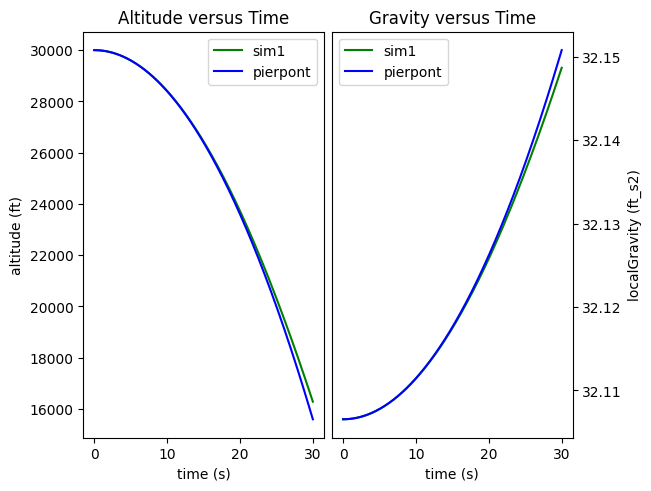

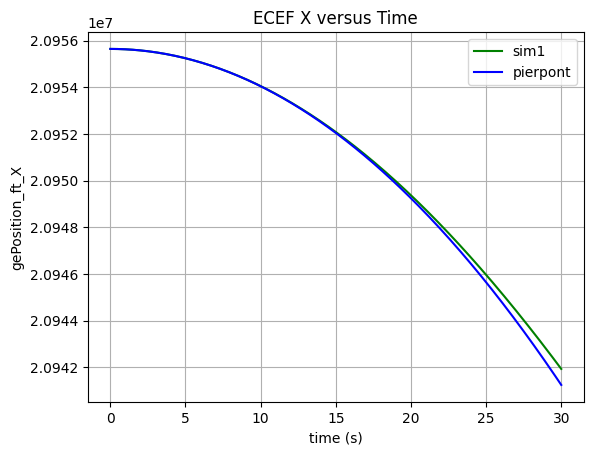

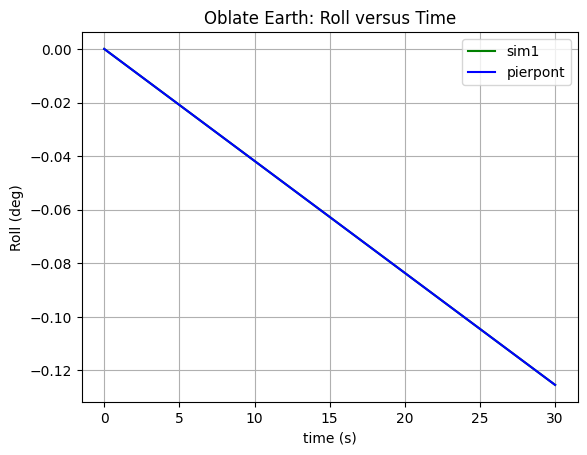

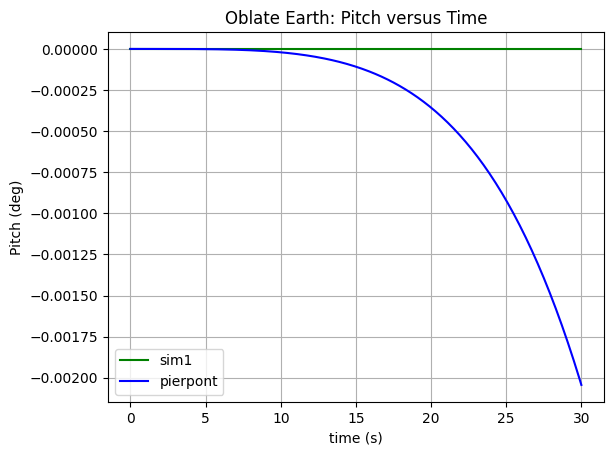

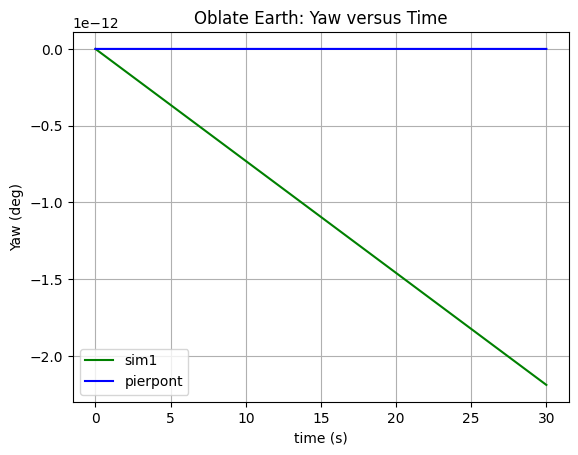

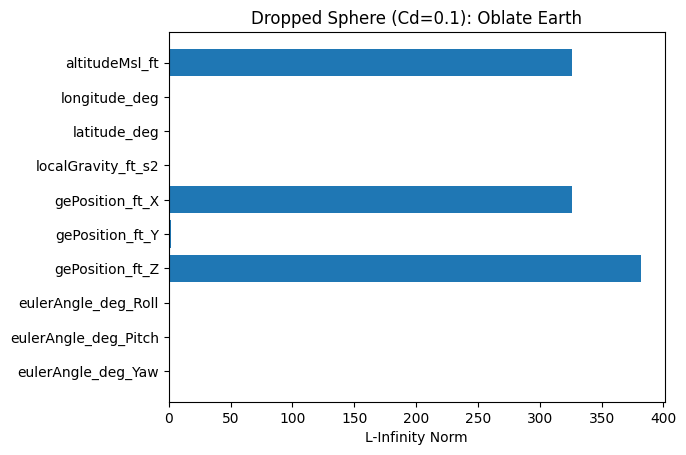

In [57]:
checkFile = "NESC-check-cases/Atmospheric_checkcases/Atmos_06_DroppedSphereEllipsoidalNoWind/Atmos_06_sim_01.csv"
gvCC6 = GetCheckCaseData(checkFile)
MakePlot(gvOblateRotatingEarth, gvCC6, "sim1")
PrintErrorTable("Dropped Sphere (Cd=0.1): Oblate Earth", gvOblateEarthLabel, gvOblateRotatingEarth, gvCC6)

### Stevens and Lewis Orbit

In [58]:
h = 422000  # height in meters (about ISS alt); sim on pg 43 uses 100km
gd = 9.80665
a = 6378137.0
wz = 7.292115e-5

vy = math.sqrt(gd*(a + h)) - wz*(a + h)
print("vy: ", vy, " m/s")

vy:  7670.310336088278  m/s


The vehicle in the simulation is a solid brick.  The moment of inertia of a brick:

$ I_{x} = \frac{1}{12} m ( y^2 + z^2 ) $  
$ I_{y} = \frac{1}{12} m ( x^2 + z^2 ) $  
$ I_{z} = \frac{1}{12} m ( x^2 + y^2 ) $  

The dimensions of the brick as stated by Stevens and Lewis is 2 x 5 x 8 units.  
Coordinate origin is at the center of mass of the brick.  
8 unit side is parallel to the x-axis  
5 unit side is parallel to the y-axis  

For simplicity, the brick units are meters and the mass is 1kg.

$ I_{x} = \frac{1}{12} (1) (2^2 + 5^2) = 2.41667 $  
$ I_{y} = \frac{1}{12} (1) (8^2 + 2^2) = 5.667 $  
$ I_{z} = \frac{1}{12} (1) (8^2 + 5^2) = 7.41667 $  

In [59]:
%%time
#ppLoadDml('models/NESC/brick_inertia.dml')
#CheckModel()
ppLoadDml('models/noAero.dml')
#
ic = {
    "timeStep": [1.0, "s"],
    "totalMass": [1.0, "kg"],
    "bodyMomentOfInertia_X": [2.4167, "kgm2"],
    "bodyMomentOfInertia_Y": [5.667, "kgm2"],
    "bodyMomentOfInertia_Z": [7.417, "kgm2"],
    "altitudeMsl": [100000.0, "m"],
    "trueAirspeed": [9000.0, "m_s"],
    "referenceWingChord": [8.0, "m"],
    "referenceWingSpan": [5.0, "m"]
}
#
gvOblateRotatingEarth.Reset(ic)
gvOblateRotatingEarth.totalCoefficientOfDrag = 0.0
gvOblateRotatingEarth.Run(20000)
gvOblateRotatingEarth.GenerateEnglishUnits()

root tag:  {http://daveml.org/2010/DAVEML}DAVEfunc
Model:  Zero Aero Output
creation date:  2021-07-21
file version:  Initial version
-variableDef-
 varDefStruct.name:  aeroBodyForceCoefficient_X
 varDefStruct.varID:  CX
 varDefStruct.units:  kgm2
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  True
 varDefStruct.initialValue:  0.0
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  True
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.name:  aeroBodyForceCoefficient_Y
 varDefStruct.varID:  CY
 varDefStruct.units:  kgm2
 varDefStruct.axisSystem:  None
 varDefStruct.sign:  None
 varDefStruct.alias:  None
 varDefStruct.symbol:  None
 varDefStruct.hasInitialValue:  True
 varDefStruct.initialValue:  0.0
 varDefStruct.isStdAIAA:  True
 varDefStruct.isOutput:  True
 varDefStruct.hasMath:  False
 varDefStruct.codeText:  None
-variableDef-
 varDefStruct.na

In [60]:
from IPython.display import Image
Image(url= "images/SLOrbit.JPG", width=600, height=600)

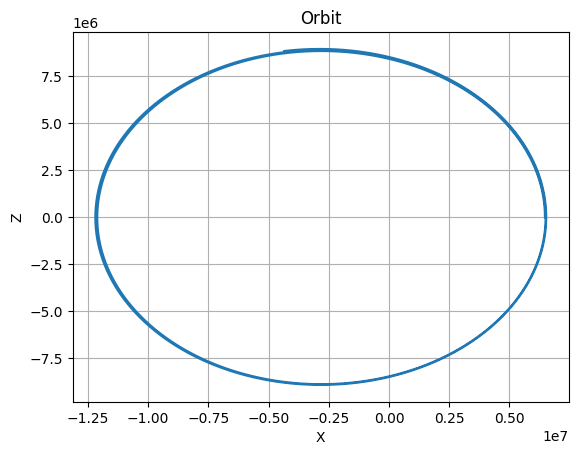

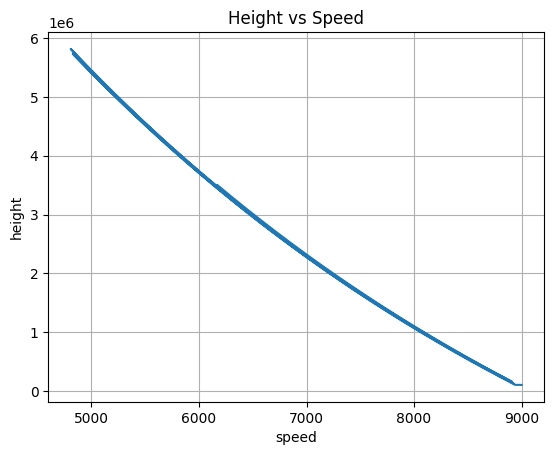

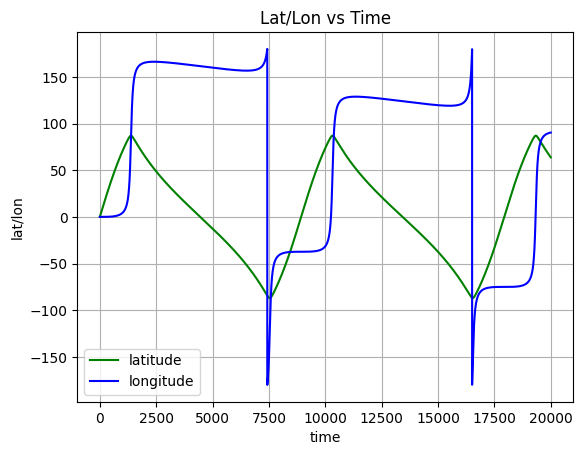

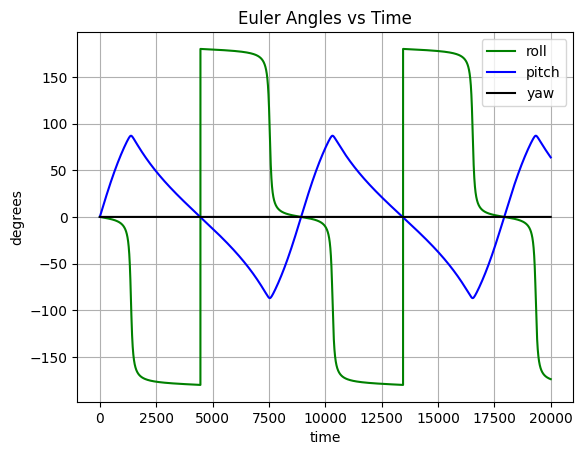

In [61]:
fig1, a = plt.subplots()
a.plot(gvOblateRotatingEarth.eiPosition_m_X, gvOblateRotatingEarth.eiPosition_m_Z)
a.set(xlabel='X', ylabel='Z', title='Orbit')
a.grid()

fig2, b = plt.subplots()
b.plot(gvOblateRotatingEarth.trueAirspeed, gvOblateRotatingEarth.altitudeMsl_m)
b.set(xlabel='speed', ylabel='height', title='Height vs Speed')
b.grid()

fig3, c = plt.subplots()
c.plot(gvOblateRotatingEarth.time, gvOblateRotatingEarth.EnglishData['latitude_deg'],'g',
       gvOblateRotatingEarth.time, gvOblateRotatingEarth.EnglishData['longitude_deg'], 'b')
c.legend(["latitude","longitude"])
c.set(xlabel='time', ylabel='lat/lon', title='Lat/Lon vs Time')
c.grid()

fig4, d = plt.subplots()
d.plot(gvOblateRotatingEarth.time, gvOblateRotatingEarth.EnglishData['eulerAngle_deg_Roll'],'g',
       gvOblateRotatingEarth.time, gvOblateRotatingEarth.EnglishData['eulerAngle_deg_Pitch'], 'b',
       gvOblateRotatingEarth.time, gvOblateRotatingEarth.EnglishData['eulerAngle_deg_Yaw'], 'k')
d.legend(["roll","pitch","yaw"])
d.set(xlabel='time', ylabel='degrees', title='Euler Angles vs Time')
d.grid()